<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2024-05-10 21:34:58.692758: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 21:34:58.721621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 21:34:58.721645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 21:34:58.722772: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 21:34:58.728354: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 21:34:58.729192: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-05-10 21:34:59.891757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2024-05-10 21:35:19.516518: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

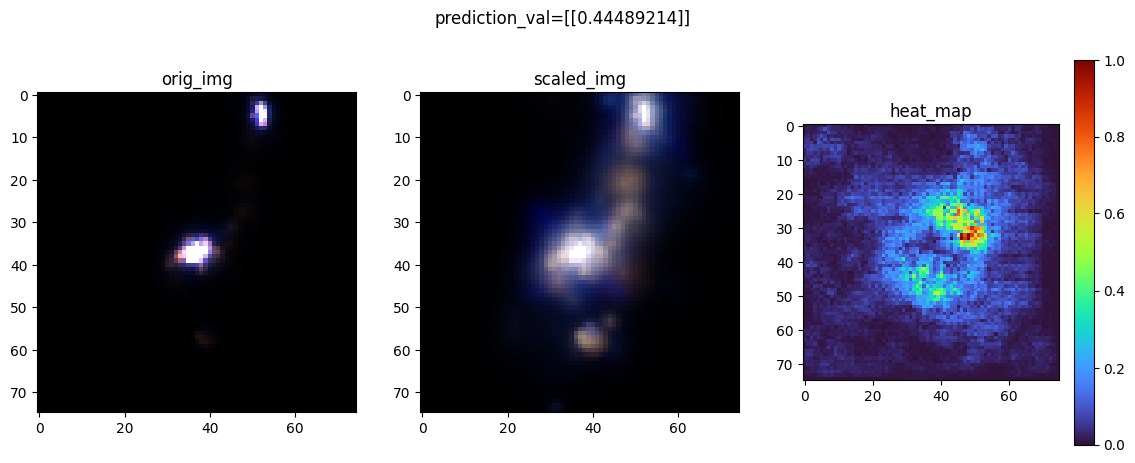

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

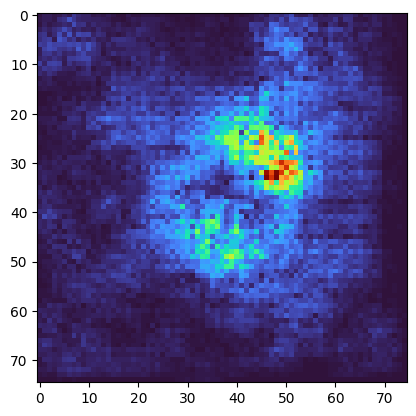

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

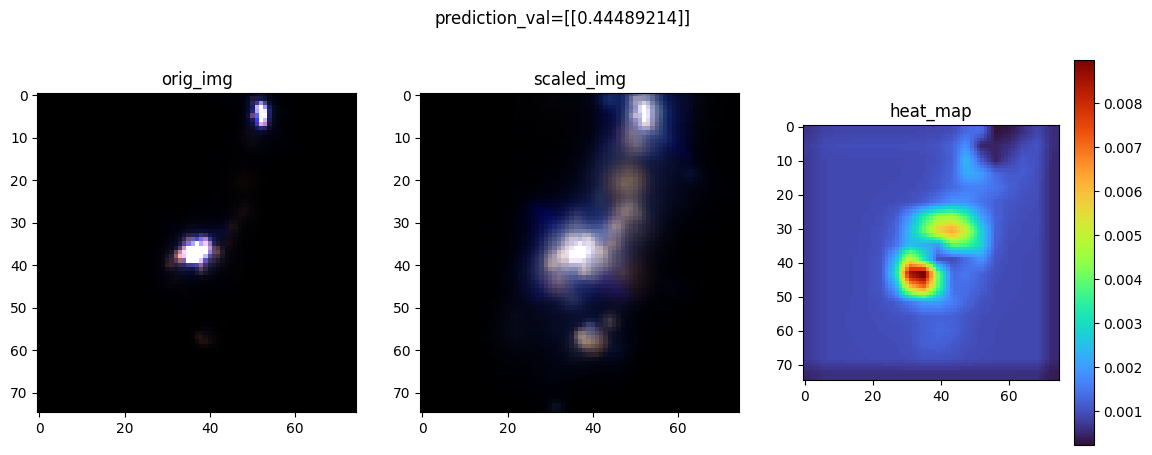

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'heat_map')

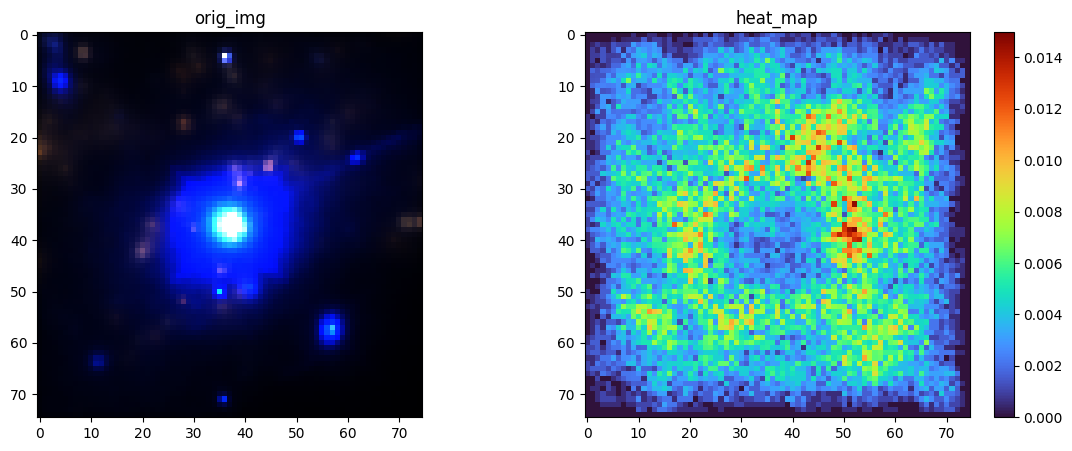

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


2024-05-10 21:35:30.781410: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 6:32 - loss: 0.7078 - accuracy: 0.5938

  2/338 [..............................] - ETA: 19s - loss: 0.7078 - accuracy: 0.5781 

  3/338 [..............................] - ETA: 19s - loss: 0.7083 - accuracy: 0.5521

  4/338 [..............................] - ETA: 19s - loss: 0.7092 - accuracy: 0.5078

  5/338 [..............................] - ETA: 19s - loss: 0.7088 - accuracy: 0.5125

  6/338 [..............................] - ETA: 19s - loss: 0.7081 - accuracy: 0.5260

  7/338 [..............................] - ETA: 19s - loss: 0.7069 - accuracy: 0.5536

  8/338 [..............................] - ETA: 19s - loss: 0.7071 - accuracy: 0.5391

  9/338 [..............................] - ETA: 19s - loss: 0.7070 - accuracy: 0.5347

 10/338 [..............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.5344

 11/338 [..............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.5256

 12/338 [>.............................] - ETA: 18s - loss: 0.7068 - accuracy: 0.5156

 13/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5168

 14/338 [>.............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5156

 15/338 [>.............................] - ETA: 18s - loss: 0.7060 - accuracy: 0.5167

 16/338 [>.............................] - ETA: 18s - loss: 0.7056 - accuracy: 0.5215

 17/338 [>.............................] - ETA: 18s - loss: 0.7054 - accuracy: 0.5202

 18/338 [>.............................] - ETA: 18s - loss: 0.7047 - accuracy: 0.5312

 19/338 [>.............................] - ETA: 18s - loss: 0.7044 - accuracy: 0.5345

 20/338 [>.............................] - ETA: 18s - loss: 0.7041 - accuracy: 0.5344

 21/338 [>.............................] - ETA: 18s - loss: 0.7042 - accuracy: 0.5283

 22/338 [>.............................] - ETA: 18s - loss: 0.7040 - accuracy: 0.5270

 23/338 [=>............................] - ETA: 17s - loss: 0.7037 - accuracy: 0.5299

 24/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.5312

 25/338 [=>............................] - ETA: 17s - loss: 0.7034 - accuracy: 0.5275

 26/338 [=>............................] - ETA: 17s - loss: 0.7033 - accuracy: 0.5240

 27/338 [=>............................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5278

 28/338 [=>............................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5279

 29/338 [=>............................] - ETA: 17s - loss: 0.7027 - accuracy: 0.5269

 30/338 [=>............................] - ETA: 17s - loss: 0.7025 - accuracy: 0.5271

 31/338 [=>............................] - ETA: 17s - loss: 0.7025 - accuracy: 0.5242

 32/338 [=>............................] - ETA: 17s - loss: 0.7021 - accuracy: 0.5283

 33/338 [=>............................] - ETA: 17s - loss: 0.7020 - accuracy: 0.5294

 34/338 [==>...........................] - ETA: 17s - loss: 0.7017 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 17s - loss: 0.7016 - accuracy: 0.5321

 36/338 [==>...........................] - ETA: 17s - loss: 0.7015 - accuracy: 0.5304

 37/338 [==>...........................] - ETA: 17s - loss: 0.7013 - accuracy: 0.5321

 38/338 [==>...........................] - ETA: 16s - loss: 0.7011 - accuracy: 0.5329

 39/338 [==>...........................] - ETA: 16s - loss: 0.7008 - accuracy: 0.5345

 40/338 [==>...........................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5352

 41/338 [==>...........................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5373

 42/338 [==>...........................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5327

 43/338 [==>...........................] - ETA: 16s - loss: 0.7004 - accuracy: 0.5334

 44/338 [==>...........................] - ETA: 16s - loss: 0.7001 - accuracy: 0.5355

 45/338 [==>...........................] - ETA: 16s - loss: 0.6999 - accuracy: 0.5368

 46/338 [===>..........................] - ETA: 16s - loss: 0.6996 - accuracy: 0.5401

 47/338 [===>..........................] - ETA: 16s - loss: 0.6994 - accuracy: 0.5406

 48/338 [===>..........................] - ETA: 16s - loss: 0.6992 - accuracy: 0.5410

 49/338 [===>..........................] - ETA: 16s - loss: 0.6990 - accuracy: 0.5427

 50/338 [===>..........................] - ETA: 16s - loss: 0.6991 - accuracy: 0.5400

 51/338 [===>..........................] - ETA: 16s - loss: 0.6989 - accuracy: 0.5404

 52/338 [===>..........................] - ETA: 16s - loss: 0.6986 - accuracy: 0.5433

 53/338 [===>..........................] - ETA: 16s - loss: 0.6984 - accuracy: 0.5454

 54/338 [===>..........................] - ETA: 16s - loss: 0.6981 - accuracy: 0.5475

 55/338 [===>..........................] - ETA: 16s - loss: 0.6980 - accuracy: 0.5483

 56/338 [===>..........................] - ETA: 15s - loss: 0.6979 - accuracy: 0.5485

 57/338 [====>.........................] - ETA: 15s - loss: 0.6975 - accuracy: 0.5515

 58/338 [====>.........................] - ETA: 15s - loss: 0.6975 - accuracy: 0.5501

 59/338 [====>.........................] - ETA: 15s - loss: 0.6975 - accuracy: 0.5493

 60/338 [====>.........................] - ETA: 15s - loss: 0.6974 - accuracy: 0.5500

 61/338 [====>.........................] - ETA: 15s - loss: 0.6973 - accuracy: 0.5497

 62/338 [====>.........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5504

 63/338 [====>.........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5496

 64/338 [====>.........................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5503

 65/338 [====>.........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5481

 66/338 [====>.........................] - ETA: 15s - loss: 0.6972 - accuracy: 0.5464

 67/338 [====>.........................] - ETA: 15s - loss: 0.6971 - accuracy: 0.5471

 68/338 [=====>........................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5473

 69/338 [=====>........................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5476

 70/338 [=====>........................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5464

 71/338 [=====>........................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5449

 72/338 [=====>........................] - ETA: 15s - loss: 0.6969 - accuracy: 0.5443

 73/338 [=====>........................] - ETA: 15s - loss: 0.6968 - accuracy: 0.5449

 74/338 [=====>........................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5460

 75/338 [=====>........................] - ETA: 14s - loss: 0.6967 - accuracy: 0.5454

 76/338 [=====>........................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5452

 77/338 [=====>........................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5475

 78/338 [=====>........................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5457

 79/338 [======>.......................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5447

 80/338 [======>.......................] - ETA: 14s - loss: 0.6966 - accuracy: 0.5434

 81/338 [======>.......................] - ETA: 14s - loss: 0.6965 - accuracy: 0.5436

 82/338 [======>.......................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5438

 83/338 [======>.......................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5429

 84/338 [======>.......................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5432

 85/338 [======>.......................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5430

 86/338 [======>.......................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5429

 87/338 [======>.......................] - ETA: 14s - loss: 0.6964 - accuracy: 0.5409

 88/338 [======>.......................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5412

 89/338 [======>.......................] - ETA: 14s - loss: 0.6961 - accuracy: 0.5421

 90/338 [======>.......................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5396

 91/338 [=======>......................] - ETA: 14s - loss: 0.6962 - accuracy: 0.5409

 92/338 [=======>......................] - ETA: 14s - loss: 0.6963 - accuracy: 0.5387

 93/338 [=======>......................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5390

 94/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5392

 95/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5388

 96/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5378

 97/338 [=======>......................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5380

 98/338 [=======>......................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5364

 99/338 [=======>......................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5360

100/338 [=======>......................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5356

101/338 [=======>......................] - ETA: 13s - loss: 0.6964 - accuracy: 0.5337

102/338 [========>.....................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5343

103/338 [========>.....................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5343

104/338 [========>.....................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5343

105/338 [========>.....................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5336

106/338 [========>.....................] - ETA: 13s - loss: 0.6963 - accuracy: 0.5324

107/338 [========>.....................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5327

108/338 [========>.....................] - ETA: 13s - loss: 0.6962 - accuracy: 0.5330

109/338 [========>.....................] - ETA: 13s - loss: 0.6961 - accuracy: 0.5335

110/338 [========>.....................] - ETA: 13s - loss: 0.6960 - accuracy: 0.5335

111/338 [========>.....................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5329

112/338 [========>.....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5326

113/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5326

114/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5323

115/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5326

116/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5331

117/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5321

118/338 [=========>....................] - ETA: 12s - loss: 0.6960 - accuracy: 0.5312

119/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5318

120/338 [=========>....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5323

121/338 [=========>....................] - ETA: 12s - loss: 0.6959 - accuracy: 0.5318

122/338 [=========>....................] - ETA: 12s - loss: 0.6958 - accuracy: 0.5323

123/338 [=========>....................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5335

124/338 [==========>...................] - ETA: 12s - loss: 0.6957 - accuracy: 0.5333

125/338 [==========>...................] - ETA: 12s - loss: 0.6955 - accuracy: 0.5343

126/338 [==========>...................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5335

127/338 [==========>...................] - ETA: 12s - loss: 0.6956 - accuracy: 0.5330

128/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5325

129/338 [==========>...................] - ETA: 11s - loss: 0.6957 - accuracy: 0.5315

130/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5312

131/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5310

132/338 [==========>...................] - ETA: 11s - loss: 0.6956 - accuracy: 0.5312

133/338 [==========>...................] - ETA: 11s - loss: 0.6955 - accuracy: 0.5320

134/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5326

135/338 [==========>...................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5322

136/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5317

137/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5312

138/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5312

139/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5310

140/338 [===========>..................] - ETA: 11s - loss: 0.6954 - accuracy: 0.5301

141/338 [===========>..................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5304

142/338 [===========>..................] - ETA: 11s - loss: 0.6953 - accuracy: 0.5308

143/338 [===========>..................] - ETA: 11s - loss: 0.6952 - accuracy: 0.5315

144/338 [===========>..................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5317

145/338 [===========>..................] - ETA: 11s - loss: 0.6951 - accuracy: 0.5319

146/338 [===========>..................] - ETA: 10s - loss: 0.6951 - accuracy: 0.5321

147/338 [============>.................] - ETA: 10s - loss: 0.6950 - accuracy: 0.5323

148/338 [============>.................] - ETA: 10s - loss: 0.6949 - accuracy: 0.5329

149/338 [============>.................] - ETA: 10s - loss: 0.6949 - accuracy: 0.5338

150/338 [============>.................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5340

151/338 [============>.................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5339

152/338 [============>.................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5343

153/338 [============>.................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5343

154/338 [============>.................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5341

155/338 [============>.................] - ETA: 10s - loss: 0.6946 - accuracy: 0.5345

156/338 [============>.................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5339

157/338 [============>.................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5328

158/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5324

159/338 [=============>................] - ETA: 10s - loss: 0.6947 - accuracy: 0.5326

160/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5318

161/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5314

162/338 [=============>................] - ETA: 10s - loss: 0.6948 - accuracy: 0.5307

163/338 [=============>................] - ETA: 10s - loss: 0.6949 - accuracy: 0.5299

164/338 [=============>................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5297 

165/338 [=============>................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5292

166/338 [=============>................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5294

167/338 [=============>................] - ETA: 9s - loss: 0.6948 - accuracy: 0.5298

168/338 [=============>................] - ETA: 9s - loss: 0.6949 - accuracy: 0.5286

169/338 [==============>...............] - ETA: 9s - loss: 0.6949 - accuracy: 0.5292

170/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5294

171/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5296

172/338 [==============>...............] - ETA: 9s - loss: 0.6947 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5289

174/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5280

175/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5282

176/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5282

177/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5284

178/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5277

179/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5279

180/338 [==============>...............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5276

181/338 [===============>..............] - ETA: 9s - loss: 0.6948 - accuracy: 0.5276

182/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5268

183/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5261

184/338 [===============>..............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5255

185/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5248

186/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5244

187/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5239

188/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5239

189/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5233

190/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5227

191/338 [===============>..............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5226

192/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5225

193/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5217

194/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5221

195/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5220

196/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5218

197/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5220

198/338 [================>.............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5218

199/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5217

200/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5214

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5208

202/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5207

203/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5208

204/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5210

205/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5213

206/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5217

207/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5220

208/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5221

209/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5224

210/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5223

211/338 [=================>............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5224

212/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5231

213/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5232

214/338 [=================>............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5228

215/338 [==================>...........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5231

216/338 [==================>...........] - ETA: 7s - loss: 0.6947 - accuracy: 0.5231

217/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5232

218/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5232

219/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5227

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5232

221/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5233

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5227

223/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5227

224/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5233

225/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5229

226/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5236

227/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5237

228/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5245

229/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5246

230/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5245

231/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5245

232/338 [===================>..........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5241

233/338 [===================>..........] - ETA: 6s - loss: 0.6945 - accuracy: 0.5244

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5238

235/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5242

236/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5246

237/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5245

238/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5244

239/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5250

240/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5243

241/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5242

242/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5241

243/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5242

244/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5238

245/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5240

246/338 [====================>.........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5238

247/338 [====================>.........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5240

248/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5247

249/338 [=====================>........] - ETA: 5s - loss: 0.6944 - accuracy: 0.5245

250/338 [=====================>........] - ETA: 5s - loss: 0.6943 - accuracy: 0.5253

251/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5254

252/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5255

253/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5252

254/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5255

255/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5254

256/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5247

257/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5249

258/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5247

259/338 [=====================>........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5247

260/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5254

261/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5255

262/338 [======================>.......] - ETA: 4s - loss: 0.6942 - accuracy: 0.5255

263/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5258

264/338 [======================>.......] - ETA: 4s - loss: 0.6941 - accuracy: 0.5262

265/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5264

266/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5268

267/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5263

268/338 [======================>.......] - ETA: 4s - loss: 0.6940 - accuracy: 0.5261

269/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5260

270/338 [======================>.......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5264

271/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5262

272/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5264

273/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5268

274/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5262

275/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5260

276/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5258

277/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5250

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5252

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5245

280/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5246

281/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5250

282/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5249

283/338 [========================>.....] - ETA: 3s - loss: 0.6940 - accuracy: 0.5245

284/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5248

285/338 [========================>.....] - ETA: 3s - loss: 0.6939 - accuracy: 0.5248

286/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5250

287/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5255

288/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5254

289/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5260

290/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5263

291/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5265

292/338 [========================>.....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5262

293/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5265

294/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5261

295/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5262

296/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5261

297/338 [=========================>....] - ETA: 2s - loss: 0.6937 - accuracy: 0.5259

298/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5262

299/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5262

300/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5263

301/338 [=========================>....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5263

302/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5266

303/338 [=========================>....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5267

304/338 [=========================>....] - ETA: 1s - loss: 0.6935 - accuracy: 0.5265

305/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5269

306/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5267

307/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5270

308/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5273

309/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5272

310/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5272

311/338 [==========================>...] - ETA: 1s - loss: 0.6934 - accuracy: 0.5268

312/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5270

313/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5269

314/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5274

315/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5271

316/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5274

317/338 [===========================>..] - ETA: 1s - loss: 0.6933 - accuracy: 0.5271

318/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5277

319/338 [===========================>..] - ETA: 1s - loss: 0.6932 - accuracy: 0.5277

320/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5278

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5279

322/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5278

323/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5281

324/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5283

325/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5280

326/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5281

327/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5279

328/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5277

329/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5277

330/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5281

331/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5278

332/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5276

333/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5280

334/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5281

335/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5282

336/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5277

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

338/338 [==============================] - 22s 62ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6915 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6790 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6778 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6832 - accuracy: 0.5833

  4/338 [..............................] - ETA: 18s - loss: 0.6840 - accuracy: 0.5781

  5/338 [..............................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5688

  6/338 [..............................] - ETA: 18s - loss: 0.6908 - accuracy: 0.5260

  7/338 [..............................] - ETA: 18s - loss: 0.6896 - accuracy: 0.5357

  8/338 [..............................] - ETA: 18s - loss: 0.6887 - accuracy: 0.5430

  9/338 [..............................] - ETA: 18s - loss: 0.6862 - accuracy: 0.5625

 10/338 [..............................] - ETA: 18s - loss: 0.6871 - accuracy: 0.5469

 11/338 [..............................] - ETA: 18s - loss: 0.6867 - accuracy: 0.5511

 12/338 [>.............................] - ETA: 18s - loss: 0.6873 - accuracy: 0.5469

 13/338 [>.............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5577

 14/338 [>.............................] - ETA: 18s - loss: 0.6864 - accuracy: 0.5536

 15/338 [>.............................] - ETA: 18s - loss: 0.6855 - accuracy: 0.5583

 16/338 [>.............................] - ETA: 18s - loss: 0.6856 - accuracy: 0.5566

 17/338 [>.............................] - ETA: 18s - loss: 0.6855 - accuracy: 0.5551

 18/338 [>.............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5556

 19/338 [>.............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5461

 20/338 [>.............................] - ETA: 17s - loss: 0.6867 - accuracy: 0.5391

 21/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5372

 22/338 [>.............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5398

 23/338 [=>............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5408

 24/338 [=>............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5404

 25/338 [=>............................] - ETA: 17s - loss: 0.6864 - accuracy: 0.5375

 26/338 [=>............................] - ETA: 17s - loss: 0.6859 - accuracy: 0.5385

 27/338 [=>............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5382

 28/338 [=>............................] - ETA: 17s - loss: 0.6853 - accuracy: 0.5424

 29/338 [=>............................] - ETA: 17s - loss: 0.6857 - accuracy: 0.5399

 30/338 [=>............................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5365

 31/338 [=>............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5363

 32/338 [=>............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5342

 33/338 [=>............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5322

 34/338 [==>...........................] - ETA: 17s - loss: 0.6861 - accuracy: 0.5331

 35/338 [==>...........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5321

 37/338 [==>...........................] - ETA: 16s - loss: 0.6859 - accuracy: 0.5346

 38/338 [==>...........................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5337

 39/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5312

 40/338 [==>...........................] - ETA: 16s - loss: 0.6862 - accuracy: 0.5336

 41/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5335

 42/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5320

 43/338 [==>...........................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5305

 44/338 [==>...........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5312

 45/338 [==>...........................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5299

 46/338 [===>..........................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5292

 47/338 [===>..........................] - ETA: 16s - loss: 0.6869 - accuracy: 0.5293

 48/338 [===>..........................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5286

 49/338 [===>..........................] - ETA: 16s - loss: 0.6867 - accuracy: 0.5312

 50/338 [===>..........................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5331

 51/338 [===>..........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5337

 52/338 [===>..........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5331

 53/338 [===>..........................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5318

 54/338 [===>..........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5295

 55/338 [===>..........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5301

 56/338 [===>..........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5290

 57/338 [====>.........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5296

 58/338 [====>.........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5280

 59/338 [====>.........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5291

 60/338 [====>.........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5271

 61/338 [====>.........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5287

 62/338 [====>.........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5297

 63/338 [====>.........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5253

 64/338 [====>.........................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5259

 65/338 [====>.........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5255

 66/338 [====>.........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5275

 67/338 [====>.........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5271

 68/338 [=====>........................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5276

 69/338 [=====>........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5249

 70/338 [=====>........................] - ETA: 15s - loss: 0.6877 - accuracy: 0.5219

 71/338 [=====>........................] - ETA: 15s - loss: 0.6875 - accuracy: 0.5233

 72/338 [=====>........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5247

 73/338 [=====>........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5253

 74/338 [=====>........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5258

 75/338 [=====>........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5271

 76/338 [=====>........................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5271

 77/338 [=====>........................] - ETA: 14s - loss: 0.6870 - accuracy: 0.5276

 78/338 [=====>........................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5256

 79/338 [======>.......................] - ETA: 14s - loss: 0.6869 - accuracy: 0.5269

 80/338 [======>.......................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5254

 81/338 [======>.......................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5239

 82/338 [======>.......................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5225

 83/338 [======>.......................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5218

 84/338 [======>.......................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5219

 85/338 [======>.......................] - ETA: 14s - loss: 0.6872 - accuracy: 0.5232

 86/338 [======>.......................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5247

 87/338 [======>.......................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5244

 88/338 [======>.......................] - ETA: 14s - loss: 0.6871 - accuracy: 0.5241

 89/338 [======>.......................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5260

 90/338 [======>.......................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5250

 91/338 [=======>......................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5254

 92/338 [=======>......................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5255

 93/338 [=======>......................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5259

 94/338 [=======>......................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5256

 95/338 [=======>......................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5240

 96/338 [=======>......................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5244

 97/338 [=======>......................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5232

 98/338 [=======>......................] - ETA: 13s - loss: 0.6868 - accuracy: 0.5226

 99/338 [=======>......................] - ETA: 13s - loss: 0.6869 - accuracy: 0.5221

100/338 [=======>......................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5234

101/338 [=======>......................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5251

102/338 [========>.....................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5236

103/338 [========>.....................] - ETA: 13s - loss: 0.6867 - accuracy: 0.5225

104/338 [========>.....................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5225

105/338 [========>.....................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5235

106/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5248

107/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5234

108/338 [========>.....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5240

109/338 [========>.....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5226

110/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5219

111/338 [========>.....................] - ETA: 12s - loss: 0.6864 - accuracy: 0.5217

112/338 [========>.....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5218

113/338 [=========>....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5210

114/338 [=========>....................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5219

115/338 [=========>....................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5228

116/338 [=========>....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5213

117/338 [=========>....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5214

118/338 [=========>....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5209

119/338 [=========>....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5218

120/338 [=========>....................] - ETA: 12s - loss: 0.6863 - accuracy: 0.5216

121/338 [=========>....................] - ETA: 12s - loss: 0.6862 - accuracy: 0.5222

122/338 [=========>....................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5238

123/338 [=========>....................] - ETA: 12s - loss: 0.6861 - accuracy: 0.5254

124/338 [==========>...................] - ETA: 11s - loss: 0.6860 - accuracy: 0.5270

125/338 [==========>...................] - ETA: 11s - loss: 0.6860 - accuracy: 0.5280

126/338 [==========>...................] - ETA: 11s - loss: 0.6860 - accuracy: 0.5283

127/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5290

128/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5295

129/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5305

130/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5310

131/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5320

132/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5322

133/338 [==========>...................] - ETA: 11s - loss: 0.6859 - accuracy: 0.5324

134/338 [==========>...................] - ETA: 11s - loss: 0.6858 - accuracy: 0.5347

135/338 [==========>...................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5361

136/338 [===========>..................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5365

137/338 [===========>..................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5365

138/338 [===========>..................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5362

139/338 [===========>..................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5362

140/338 [===========>..................] - ETA: 11s - loss: 0.6857 - accuracy: 0.5368

141/338 [===========>..................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5379

142/338 [===========>..................] - ETA: 11s - loss: 0.6854 - accuracy: 0.5387

143/338 [===========>..................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5389

144/338 [===========>..................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5386

145/338 [===========>..................] - ETA: 10s - loss: 0.6855 - accuracy: 0.5397

146/338 [===========>..................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5411

147/338 [============>.................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5412

148/338 [============>.................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5416

149/338 [============>.................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5424

150/338 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5419

151/338 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5424

152/338 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5432

153/338 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5439

154/338 [============>.................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5438

155/338 [============>.................] - ETA: 10s - loss: 0.6853 - accuracy: 0.5450

156/338 [============>.................] - ETA: 10s - loss: 0.6852 - accuracy: 0.5453

157/338 [============>.................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5464

158/338 [=============>................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5467

159/338 [=============>................] - ETA: 10s - loss: 0.6851 - accuracy: 0.5478

160/338 [=============>................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5480 

161/338 [=============>................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5485

162/338 [=============>................] - ETA: 9s - loss: 0.6851 - accuracy: 0.5490

163/338 [=============>................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5504

164/338 [=============>................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5511

165/338 [=============>................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5513

166/338 [=============>................] - ETA: 9s - loss: 0.6848 - accuracy: 0.5514

167/338 [=============>................] - ETA: 9s - loss: 0.6849 - accuracy: 0.5518

168/338 [=============>................] - ETA: 9s - loss: 0.6850 - accuracy: 0.5519

169/338 [==============>...............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5520

170/338 [==============>...............] - ETA: 9s - loss: 0.6850 - accuracy: 0.5522

171/338 [==============>...............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5517

172/338 [==============>...............] - ETA: 9s - loss: 0.6852 - accuracy: 0.5514

173/338 [==============>...............] - ETA: 9s - loss: 0.6852 - accuracy: 0.5520

174/338 [==============>...............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5526

175/338 [==============>...............] - ETA: 9s - loss: 0.6852 - accuracy: 0.5523

176/338 [==============>...............] - ETA: 9s - loss: 0.6851 - accuracy: 0.5536

177/338 [==============>...............] - ETA: 9s - loss: 0.6849 - accuracy: 0.5546

178/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5553

179/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5562

180/338 [==============>...............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5564

181/338 [===============>..............] - ETA: 8s - loss: 0.6848 - accuracy: 0.5563

182/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5568

183/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5575

184/338 [===============>..............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5577

185/338 [===============>..............] - ETA: 8s - loss: 0.6845 - accuracy: 0.5584

186/338 [===============>..............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5586

187/338 [===============>..............] - ETA: 8s - loss: 0.6845 - accuracy: 0.5595

188/338 [===============>..............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5592

189/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5589

190/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5592

191/338 [===============>..............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5597

192/338 [================>.............] - ETA: 8s - loss: 0.6847 - accuracy: 0.5592

193/338 [================>.............] - ETA: 8s - loss: 0.6846 - accuracy: 0.5599

194/338 [================>.............] - ETA: 8s - loss: 0.6845 - accuracy: 0.5609

195/338 [================>.............] - ETA: 8s - loss: 0.6845 - accuracy: 0.5611

196/338 [================>.............] - ETA: 7s - loss: 0.6845 - accuracy: 0.5612

197/338 [================>.............] - ETA: 7s - loss: 0.6844 - accuracy: 0.5622

198/338 [================>.............] - ETA: 7s - loss: 0.6843 - accuracy: 0.5630

199/338 [================>.............] - ETA: 7s - loss: 0.6843 - accuracy: 0.5633

200/338 [================>.............] - ETA: 7s - loss: 0.6843 - accuracy: 0.5634

201/338 [================>.............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5644

202/338 [================>.............] - ETA: 7s - loss: 0.6842 - accuracy: 0.5647

203/338 [=================>............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5657

204/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5651

205/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5654

206/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5658

207/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5658

208/338 [=================>............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5666

209/338 [=================>............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5667

210/338 [=================>............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5671

211/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5671

212/338 [=================>............] - ETA: 7s - loss: 0.6840 - accuracy: 0.5677

213/338 [=================>............] - ETA: 7s - loss: 0.6841 - accuracy: 0.5673

214/338 [=================>............] - ETA: 6s - loss: 0.6840 - accuracy: 0.5678

215/338 [==================>...........] - ETA: 6s - loss: 0.6840 - accuracy: 0.5682

216/338 [==================>...........] - ETA: 6s - loss: 0.6840 - accuracy: 0.5684

217/338 [==================>...........] - ETA: 6s - loss: 0.6840 - accuracy: 0.5687

218/338 [==================>...........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5697

219/338 [==================>...........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5695

220/338 [==================>...........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5696

221/338 [==================>...........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5696

222/338 [==================>...........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5702

223/338 [==================>...........] - ETA: 6s - loss: 0.6837 - accuracy: 0.5706

224/338 [==================>...........] - ETA: 6s - loss: 0.6837 - accuracy: 0.5709

225/338 [==================>...........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5703

226/338 [===================>..........] - ETA: 6s - loss: 0.6839 - accuracy: 0.5701

227/338 [===================>..........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5705

228/338 [===================>..........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5707

229/338 [===================>..........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5715

230/338 [===================>..........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5721

231/338 [===================>..........] - ETA: 6s - loss: 0.6837 - accuracy: 0.5728

232/338 [===================>..........] - ETA: 5s - loss: 0.6836 - accuracy: 0.5737

233/338 [===================>..........] - ETA: 5s - loss: 0.6836 - accuracy: 0.5740

234/338 [===================>..........] - ETA: 5s - loss: 0.6835 - accuracy: 0.5747

235/338 [===================>..........] - ETA: 5s - loss: 0.6833 - accuracy: 0.5759

236/338 [===================>..........] - ETA: 5s - loss: 0.6833 - accuracy: 0.5765

237/338 [====================>.........] - ETA: 5s - loss: 0.6833 - accuracy: 0.5765

238/338 [====================>.........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5772

239/338 [====================>.........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5773

240/338 [====================>.........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5764

241/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5769

242/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5776

243/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5782

244/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5780

245/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5784

246/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5781

247/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5784

248/338 [=====================>........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5785

249/338 [=====================>........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5787

250/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5792

251/338 [=====================>........] - ETA: 4s - loss: 0.6831 - accuracy: 0.5786

252/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5790

253/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5795

254/338 [=====================>........] - ETA: 4s - loss: 0.6829 - accuracy: 0.5797

255/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5792

256/338 [=====================>........] - ETA: 4s - loss: 0.6829 - accuracy: 0.5798

257/338 [=====================>........] - ETA: 4s - loss: 0.6830 - accuracy: 0.5795

258/338 [=====================>........] - ETA: 4s - loss: 0.6829 - accuracy: 0.5803

259/338 [=====================>........] - ETA: 4s - loss: 0.6828 - accuracy: 0.5810

260/338 [======================>.......] - ETA: 4s - loss: 0.6828 - accuracy: 0.5809

261/338 [======================>.......] - ETA: 4s - loss: 0.6828 - accuracy: 0.5813

262/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5816

263/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5819

264/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5820

265/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5820

266/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5822

267/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5823

268/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5822

269/338 [======================>.......] - ETA: 3s - loss: 0.6828 - accuracy: 0.5824

270/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5830

271/338 [=======================>......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5831

272/338 [=======================>......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5834

273/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5838

274/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5842

275/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5840

276/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5841

277/338 [=======================>......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5843

278/338 [=======================>......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5844

279/338 [=======================>......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5850

280/338 [=======================>......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5852

281/338 [=======================>......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5850

282/338 [========================>.....] - ETA: 3s - loss: 0.6822 - accuracy: 0.5855

283/338 [========================>.....] - ETA: 3s - loss: 0.6822 - accuracy: 0.5857

284/338 [========================>.....] - ETA: 3s - loss: 0.6822 - accuracy: 0.5862

285/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5868

286/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5870

287/338 [========================>.....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5866

288/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5870

289/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5872

290/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5870

291/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5873

292/338 [========================>.....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5875

293/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5878

294/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5877

295/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5874

296/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5869

297/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5870

298/338 [=========================>....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5875

299/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5878

300/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5883

301/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5886

302/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5885

303/338 [=========================>....] - ETA: 1s - loss: 0.6820 - accuracy: 0.5887

304/338 [=========================>....] - ETA: 1s - loss: 0.6819 - accuracy: 0.5888

305/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5891

306/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5892

307/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5891

308/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5890

309/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5889

310/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5894

311/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5896

312/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5902

313/338 [==========================>...] - ETA: 1s - loss: 0.6817 - accuracy: 0.5906

314/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5903

315/338 [==========================>...] - ETA: 1s - loss: 0.6817 - accuracy: 0.5904

316/338 [===========================>..] - ETA: 1s - loss: 0.6817 - accuracy: 0.5907

317/338 [===========================>..] - ETA: 1s - loss: 0.6816 - accuracy: 0.5909

318/338 [===========================>..] - ETA: 1s - loss: 0.6816 - accuracy: 0.5913

319/338 [===========================>..] - ETA: 1s - loss: 0.6816 - accuracy: 0.5914

320/338 [===========================>..] - ETA: 1s - loss: 0.6816 - accuracy: 0.5916

321/338 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.5912

322/338 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5913

323/338 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5914

324/338 [===========================>..] - ETA: 0s - loss: 0.6817 - accuracy: 0.5913

325/338 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5913

326/338 [===========================>..] - ETA: 0s - loss: 0.6816 - accuracy: 0.5918

327/338 [============================>.] - ETA: 0s - loss: 0.6815 - accuracy: 0.5921

328/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5925

329/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5929

330/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5931

331/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5933

332/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5931

333/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5935

334/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5932

335/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5934

336/338 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5934

337/338 [============================>.] - ETA: 0s - loss: 0.6813 - accuracy: 0.5937

338/338 [==============================] - 20s 61ms/step - loss: 0.6813 - accuracy: 0.5937 - val_loss: 0.6924 - val_accuracy: 0.5187


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6594 - accuracy: 0.6875

  2/338 [..............................] - ETA: 20s - loss: 0.6696 - accuracy: 0.6406

  3/338 [..............................] - ETA: 21s - loss: 0.6723 - accuracy: 0.6042

  4/338 [..............................] - ETA: 20s - loss: 0.6709 - accuracy: 0.6328

  5/338 [..............................] - ETA: 20s - loss: 0.6805 - accuracy: 0.6000

  6/338 [..............................] - ETA: 19s - loss: 0.6750 - accuracy: 0.6250

  7/338 [..............................] - ETA: 19s - loss: 0.6743 - accuracy: 0.6295

  8/338 [..............................] - ETA: 19s - loss: 0.6716 - accuracy: 0.6367

  9/338 [..............................] - ETA: 19s - loss: 0.6703 - accuracy: 0.6458

 10/338 [..............................] - ETA: 18s - loss: 0.6731 - accuracy: 0.6406

 11/338 [..............................] - ETA: 18s - loss: 0.6741 - accuracy: 0.6335

 12/338 [>.............................] - ETA: 18s - loss: 0.6737 - accuracy: 0.6328

 13/338 [>.............................] - ETA: 18s - loss: 0.6712 - accuracy: 0.6418

 14/338 [>.............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 18s - loss: 0.6717 - accuracy: 0.6438

 16/338 [>.............................] - ETA: 18s - loss: 0.6706 - accuracy: 0.6504

 17/338 [>.............................] - ETA: 18s - loss: 0.6710 - accuracy: 0.6471

 18/338 [>.............................] - ETA: 18s - loss: 0.6708 - accuracy: 0.6493

 19/338 [>.............................] - ETA: 18s - loss: 0.6706 - accuracy: 0.6497

 20/338 [>.............................] - ETA: 18s - loss: 0.6714 - accuracy: 0.6469

 21/338 [>.............................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6503

 22/338 [>.............................] - ETA: 18s - loss: 0.6703 - accuracy: 0.6520

 23/338 [=>............................] - ETA: 18s - loss: 0.6707 - accuracy: 0.6508

 24/338 [=>............................] - ETA: 18s - loss: 0.6709 - accuracy: 0.6497

 25/338 [=>............................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6513

 26/338 [=>............................] - ETA: 17s - loss: 0.6693 - accuracy: 0.6562

 27/338 [=>............................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6586

 28/338 [=>............................] - ETA: 17s - loss: 0.6696 - accuracy: 0.6585

 29/338 [=>............................] - ETA: 17s - loss: 0.6686 - accuracy: 0.6627

 30/338 [=>............................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6594

 31/338 [=>............................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6573

 32/338 [=>............................] - ETA: 17s - loss: 0.6691 - accuracy: 0.6602

 33/338 [=>............................] - ETA: 17s - loss: 0.6686 - accuracy: 0.6610

 34/338 [==>...........................] - ETA: 17s - loss: 0.6690 - accuracy: 0.6572

 35/338 [==>...........................] - ETA: 17s - loss: 0.6695 - accuracy: 0.6545

 36/338 [==>...........................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6536

 37/338 [==>...........................] - ETA: 17s - loss: 0.6698 - accuracy: 0.6537

 38/338 [==>...........................] - ETA: 17s - loss: 0.6706 - accuracy: 0.6530

 39/338 [==>...........................] - ETA: 17s - loss: 0.6706 - accuracy: 0.6522

 40/338 [==>...........................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6523

 41/338 [==>...........................] - ETA: 17s - loss: 0.6700 - accuracy: 0.6532

 42/338 [==>...........................] - ETA: 16s - loss: 0.6706 - accuracy: 0.6525

 43/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6483

 44/338 [==>...........................] - ETA: 16s - loss: 0.6718 - accuracy: 0.6484

 45/338 [==>...........................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6493

 46/338 [===>..........................] - ETA: 16s - loss: 0.6715 - accuracy: 0.6474

 47/338 [===>..........................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6432

 49/338 [===>..........................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6422

 50/338 [===>..........................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6419

 51/338 [===>..........................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6428

 52/338 [===>..........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6412

 53/338 [===>..........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6409

 54/338 [===>..........................] - ETA: 16s - loss: 0.6728 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6403

 56/338 [===>..........................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6406

 57/338 [====>.........................] - ETA: 15s - loss: 0.6729 - accuracy: 0.6398

 58/338 [====>.........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6374

 59/338 [====>.........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6382

 60/338 [====>.........................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6385

 61/338 [====>.........................] - ETA: 15s - loss: 0.6727 - accuracy: 0.6383

 62/338 [====>.........................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6411

 63/338 [====>.........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6409

 64/338 [====>.........................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6406

 65/338 [====>.........................] - ETA: 15s - loss: 0.6719 - accuracy: 0.6409

 66/338 [====>.........................] - ETA: 15s - loss: 0.6718 - accuracy: 0.6416

 67/338 [====>.........................] - ETA: 15s - loss: 0.6716 - accuracy: 0.6427

 68/338 [=====>........................] - ETA: 15s - loss: 0.6715 - accuracy: 0.6420

 69/338 [=====>........................] - ETA: 15s - loss: 0.6712 - accuracy: 0.6436

 70/338 [=====>........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6451

 71/338 [=====>........................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6452

 72/338 [=====>........................] - ETA: 15s - loss: 0.6711 - accuracy: 0.6441

 73/338 [=====>........................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6451

 74/338 [=====>........................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6465

 75/338 [=====>........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6450

 76/338 [=====>........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6460

 77/338 [=====>........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6453

 78/338 [=====>........................] - ETA: 14s - loss: 0.6708 - accuracy: 0.6462

 79/338 [======>.......................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6472

 80/338 [======>.......................] - ETA: 14s - loss: 0.6704 - accuracy: 0.6465

 81/338 [======>.......................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6458

 82/338 [======>.......................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6463

 83/338 [======>.......................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6446

 84/338 [======>.......................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6440

 85/338 [======>.......................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6445

 86/338 [======>.......................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6450

 87/338 [======>.......................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6444

 88/338 [======>.......................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6442

 89/338 [======>.......................] - ETA: 14s - loss: 0.6712 - accuracy: 0.6443

 90/338 [======>.......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6441

 91/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6446

 92/338 [=======>......................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6447

 93/338 [=======>......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6438

 94/338 [=======>......................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6436

 95/338 [=======>......................] - ETA: 13s - loss: 0.6716 - accuracy: 0.6431

 96/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6439

 97/338 [=======>......................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6437

 98/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6441

 99/338 [=======>......................] - ETA: 13s - loss: 0.6712 - accuracy: 0.6443

100/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6438

101/338 [=======>......................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6439

102/338 [========>.....................] - ETA: 13s - loss: 0.6713 - accuracy: 0.6440

103/338 [========>.....................] - ETA: 13s - loss: 0.6714 - accuracy: 0.6438

104/338 [========>.....................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6430

105/338 [========>.....................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6432

106/338 [========>.....................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6427

107/338 [========>.....................] - ETA: 13s - loss: 0.6717 - accuracy: 0.6419

108/338 [========>.....................] - ETA: 13s - loss: 0.6715 - accuracy: 0.6429

109/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6436

110/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6435

111/338 [========>.....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6433

112/338 [========>.....................] - ETA: 12s - loss: 0.6712 - accuracy: 0.6440

113/338 [=========>....................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6424

114/338 [=========>....................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6431

115/338 [=========>....................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6421

116/338 [=========>....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6409

117/338 [=========>....................] - ETA: 12s - loss: 0.6718 - accuracy: 0.6410

118/338 [=========>....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6406

119/338 [=========>....................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6402

120/338 [=========>....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6414

121/338 [=========>....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6408

122/338 [=========>....................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6399

123/338 [=========>....................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6405

124/338 [==========>...................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6411

125/338 [==========>...................] - ETA: 12s - loss: 0.6713 - accuracy: 0.6423

126/338 [==========>...................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6414

127/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6427

128/338 [==========>...................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6428

129/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6422

130/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6423

131/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6422

132/338 [==========>...................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6418

133/338 [==========>...................] - ETA: 11s - loss: 0.6715 - accuracy: 0.6407

134/338 [==========>...................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6404

135/338 [==========>...................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6394

136/338 [===========>..................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6392

137/338 [===========>..................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6389

138/338 [===========>..................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6393

139/338 [===========>..................] - ETA: 11s - loss: 0.6718 - accuracy: 0.6389

140/338 [===========>..................] - ETA: 11s - loss: 0.6719 - accuracy: 0.6382

141/338 [===========>..................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6396

142/338 [===========>..................] - ETA: 11s - loss: 0.6717 - accuracy: 0.6391

143/338 [===========>..................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6399

144/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6389

145/338 [===========>..................] - ETA: 10s - loss: 0.6719 - accuracy: 0.6381

146/338 [===========>..................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6385

147/338 [============>.................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6390

148/338 [============>.................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6396

149/338 [============>.................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6388

150/338 [============>.................] - ETA: 10s - loss: 0.6720 - accuracy: 0.6375

151/338 [============>.................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6380

152/338 [============>.................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6380

153/338 [============>.................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6383

154/338 [============>.................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6380

155/338 [============>.................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6385

156/338 [============>.................] - ETA: 10s - loss: 0.6716 - accuracy: 0.6390

157/338 [============>.................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6389

158/338 [=============>................] - ETA: 10s - loss: 0.6717 - accuracy: 0.6392

159/338 [=============>................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6388

160/338 [=============>................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6387

161/338 [=============>................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6394 

162/338 [=============>................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6393

163/338 [=============>................] - ETA: 9s - loss: 0.6719 - accuracy: 0.6384

164/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6389

165/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6384

166/338 [=============>................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6387

167/338 [=============>................] - ETA: 9s - loss: 0.6717 - accuracy: 0.6387

168/338 [=============>................] - ETA: 9s - loss: 0.6718 - accuracy: 0.6380

169/338 [==============>...............] - ETA: 9s - loss: 0.6717 - accuracy: 0.6383

170/338 [==============>...............] - ETA: 9s - loss: 0.6716 - accuracy: 0.6386

171/338 [==============>...............] - ETA: 9s - loss: 0.6714 - accuracy: 0.6393

172/338 [==============>...............] - ETA: 9s - loss: 0.6713 - accuracy: 0.6394

173/338 [==============>...............] - ETA: 9s - loss: 0.6712 - accuracy: 0.6400

174/338 [==============>...............] - ETA: 9s - loss: 0.6711 - accuracy: 0.6403

175/338 [==============>...............] - ETA: 9s - loss: 0.6711 - accuracy: 0.6402

176/338 [==============>...............] - ETA: 9s - loss: 0.6709 - accuracy: 0.6408

177/338 [==============>...............] - ETA: 9s - loss: 0.6706 - accuracy: 0.6416

178/338 [==============>...............] - ETA: 9s - loss: 0.6704 - accuracy: 0.6429

179/338 [==============>...............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6426

180/338 [==============>...............] - ETA: 8s - loss: 0.6704 - accuracy: 0.6427

181/338 [===============>..............] - ETA: 8s - loss: 0.6702 - accuracy: 0.6433

182/338 [===============>..............] - ETA: 8s - loss: 0.6703 - accuracy: 0.6432

183/338 [===============>..............] - ETA: 8s - loss: 0.6702 - accuracy: 0.6434

184/338 [===============>..............] - ETA: 8s - loss: 0.6702 - accuracy: 0.6435

185/338 [===============>..............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6438

186/338 [===============>..............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6440

187/338 [===============>..............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6444

188/338 [===============>..............] - ETA: 8s - loss: 0.6697 - accuracy: 0.6449

189/338 [===============>..............] - ETA: 8s - loss: 0.6697 - accuracy: 0.6452

190/338 [===============>..............] - ETA: 8s - loss: 0.6697 - accuracy: 0.6451

191/338 [===============>..............] - ETA: 8s - loss: 0.6698 - accuracy: 0.6445

192/338 [================>.............] - ETA: 8s - loss: 0.6698 - accuracy: 0.6445

193/338 [================>.............] - ETA: 8s - loss: 0.6696 - accuracy: 0.6449

194/338 [================>.............] - ETA: 8s - loss: 0.6696 - accuracy: 0.6448

195/338 [================>.............] - ETA: 8s - loss: 0.6696 - accuracy: 0.6449

196/338 [================>.............] - ETA: 8s - loss: 0.6695 - accuracy: 0.6448

197/338 [================>.............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6456

198/338 [================>.............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6454

199/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6454

200/338 [================>.............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6459

201/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6461

202/338 [================>.............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6465

203/338 [=================>............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6462

204/338 [=================>............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6461

205/338 [=================>............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6456

206/338 [=================>............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6459

207/338 [=================>............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6455

208/338 [=================>............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6447

209/338 [=================>............] - ETA: 7s - loss: 0.6689 - accuracy: 0.6455

210/338 [=================>............] - ETA: 7s - loss: 0.6687 - accuracy: 0.6458

211/338 [=================>............] - ETA: 7s - loss: 0.6685 - accuracy: 0.6468

212/338 [=================>............] - ETA: 7s - loss: 0.6686 - accuracy: 0.6464

213/338 [=================>............] - ETA: 7s - loss: 0.6685 - accuracy: 0.6467

214/338 [=================>............] - ETA: 6s - loss: 0.6683 - accuracy: 0.6475

215/338 [==================>...........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6480

216/338 [==================>...........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6487

217/338 [==================>...........] - ETA: 6s - loss: 0.6678 - accuracy: 0.6490

218/338 [==================>...........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6487

219/338 [==================>...........] - ETA: 6s - loss: 0.6680 - accuracy: 0.6485

220/338 [==================>...........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6483

221/338 [==================>...........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6480

222/338 [==================>...........] - ETA: 6s - loss: 0.6680 - accuracy: 0.6482

223/338 [==================>...........] - ETA: 6s - loss: 0.6679 - accuracy: 0.6485

224/338 [==================>...........] - ETA: 6s - loss: 0.6680 - accuracy: 0.6482

225/338 [==================>...........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6478

226/338 [===================>..........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6478

227/338 [===================>..........] - ETA: 6s - loss: 0.6682 - accuracy: 0.6473

228/338 [===================>..........] - ETA: 6s - loss: 0.6683 - accuracy: 0.6471

229/338 [===================>..........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6479

230/338 [===================>..........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6477

231/338 [===================>..........] - ETA: 6s - loss: 0.6681 - accuracy: 0.6480

232/338 [===================>..........] - ETA: 5s - loss: 0.6680 - accuracy: 0.6483

233/338 [===================>..........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6489

234/338 [===================>..........] - ETA: 5s - loss: 0.6678 - accuracy: 0.6486

235/338 [===================>..........] - ETA: 5s - loss: 0.6676 - accuracy: 0.6492

236/338 [===================>..........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6496

237/338 [====================>.........] - ETA: 5s - loss: 0.6674 - accuracy: 0.6495

238/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6501

239/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6502

240/338 [====================>.........] - ETA: 5s - loss: 0.6673 - accuracy: 0.6499

241/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6502

242/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6501

243/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6502

244/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6501

245/338 [====================>.........] - ETA: 5s - loss: 0.6670 - accuracy: 0.6503

246/338 [====================>.........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6500

247/338 [====================>.........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6495

248/338 [=====================>........] - ETA: 5s - loss: 0.6671 - accuracy: 0.6497

249/338 [=====================>........] - ETA: 5s - loss: 0.6672 - accuracy: 0.6495

250/338 [=====================>........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6495

251/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6490

252/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6489

253/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6491

254/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6490

255/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6485

256/338 [=====================>........] - ETA: 4s - loss: 0.6673 - accuracy: 0.6484

257/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6486

258/338 [=====================>........] - ETA: 4s - loss: 0.6671 - accuracy: 0.6487

259/338 [=====================>........] - ETA: 4s - loss: 0.6672 - accuracy: 0.6484

260/338 [======================>.......] - ETA: 4s - loss: 0.6672 - accuracy: 0.6482

261/338 [======================>.......] - ETA: 4s - loss: 0.6671 - accuracy: 0.6483

262/338 [======================>.......] - ETA: 4s - loss: 0.6672 - accuracy: 0.6481

263/338 [======================>.......] - ETA: 4s - loss: 0.6671 - accuracy: 0.6483

264/338 [======================>.......] - ETA: 4s - loss: 0.6673 - accuracy: 0.6477

265/338 [======================>.......] - ETA: 4s - loss: 0.6674 - accuracy: 0.6475

266/338 [======================>.......] - ETA: 4s - loss: 0.6674 - accuracy: 0.6472

267/338 [======================>.......] - ETA: 4s - loss: 0.6673 - accuracy: 0.6476

268/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6475

269/338 [======================>.......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6475

270/338 [======================>.......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6469

271/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6470

272/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6467

273/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6463

274/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6462

275/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6461

276/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6462

277/338 [=======================>......] - ETA: 3s - loss: 0.6678 - accuracy: 0.6453

278/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6459

279/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6462

280/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6459

281/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6459

282/338 [========================>.....] - ETA: 3s - loss: 0.6674 - accuracy: 0.6466

283/338 [========================>.....] - ETA: 3s - loss: 0.6674 - accuracy: 0.6468

284/338 [========================>.....] - ETA: 3s - loss: 0.6672 - accuracy: 0.6471

285/338 [========================>.....] - ETA: 3s - loss: 0.6673 - accuracy: 0.6469

286/338 [========================>.....] - ETA: 2s - loss: 0.6673 - accuracy: 0.6467

287/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6471

288/338 [========================>.....] - ETA: 2s - loss: 0.6671 - accuracy: 0.6472

289/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6476

290/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6475

291/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6474

292/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6477

293/338 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6473

294/338 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6472

295/338 [=========================>....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6474

296/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6479

297/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6479

298/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6478

299/338 [=========================>....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6473

300/338 [=========================>....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6476

301/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6479

302/338 [=========================>....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6480

303/338 [=========================>....] - ETA: 1s - loss: 0.6666 - accuracy: 0.6479

304/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6483

305/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6481

306/338 [==========================>...] - ETA: 1s - loss: 0.6666 - accuracy: 0.6481

307/338 [==========================>...] - ETA: 1s - loss: 0.6663 - accuracy: 0.6487

308/338 [==========================>...] - ETA: 1s - loss: 0.6663 - accuracy: 0.6489

309/338 [==========================>...] - ETA: 1s - loss: 0.6661 - accuracy: 0.6493

310/338 [==========================>...] - ETA: 1s - loss: 0.6661 - accuracy: 0.6495

311/338 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.6501

312/338 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6502

313/338 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.6498

314/338 [==========================>...] - ETA: 1s - loss: 0.6661 - accuracy: 0.6493

315/338 [==========================>...] - ETA: 1s - loss: 0.6661 - accuracy: 0.6493

316/338 [===========================>..] - ETA: 1s - loss: 0.6663 - accuracy: 0.6486

317/338 [===========================>..] - ETA: 1s - loss: 0.6662 - accuracy: 0.6490

318/338 [===========================>..] - ETA: 1s - loss: 0.6660 - accuracy: 0.6493

319/338 [===========================>..] - ETA: 1s - loss: 0.6660 - accuracy: 0.6493

320/338 [===========================>..] - ETA: 1s - loss: 0.6660 - accuracy: 0.6492

321/338 [===========================>..] - ETA: 0s - loss: 0.6658 - accuracy: 0.6496

322/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6504

323/338 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.6502

324/338 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.6502

325/338 [===========================>..] - ETA: 0s - loss: 0.6655 - accuracy: 0.6505

326/338 [===========================>..] - ETA: 0s - loss: 0.6655 - accuracy: 0.6508

327/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6509

328/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6511

329/338 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.6513

330/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6510

331/338 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.6516

332/338 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.6515

333/338 [============================>.] - ETA: 0s - loss: 0.6650 - accuracy: 0.6518

334/338 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6519

335/338 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.6517

336/338 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.6512

337/338 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.6513

338/338 [==============================] - 21s 61ms/step - loss: 0.6650 - accuracy: 0.6515 - val_loss: 0.6905 - val_accuracy: 0.5491


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6948 - accuracy: 0.5625

  2/338 [..............................] - ETA: 18s - loss: 0.6564 - accuracy: 0.6562

  3/338 [..............................] - ETA: 17s - loss: 0.6597 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6676 - accuracy: 0.6172

  5/338 [..............................] - ETA: 18s - loss: 0.6668 - accuracy: 0.6187

  6/338 [..............................] - ETA: 18s - loss: 0.6598 - accuracy: 0.6406

  7/338 [..............................] - ETA: 18s - loss: 0.6575 - accuracy: 0.6429

  8/338 [..............................] - ETA: 18s - loss: 0.6542 - accuracy: 0.6562

  9/338 [..............................] - ETA: 18s - loss: 0.6542 - accuracy: 0.6597

 10/338 [..............................] - ETA: 18s - loss: 0.6542 - accuracy: 0.6594

 11/338 [..............................] - ETA: 18s - loss: 0.6537 - accuracy: 0.6619

 12/338 [>.............................] - ETA: 18s - loss: 0.6502 - accuracy: 0.6745

 13/338 [>.............................] - ETA: 18s - loss: 0.6547 - accuracy: 0.6611

 14/338 [>.............................] - ETA: 18s - loss: 0.6562 - accuracy: 0.6562

 15/338 [>.............................] - ETA: 18s - loss: 0.6565 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 18s - loss: 0.6564 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 18s - loss: 0.6573 - accuracy: 0.6507

 18/338 [>.............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6580

 19/338 [>.............................] - ETA: 17s - loss: 0.6550 - accuracy: 0.6579

 20/338 [>.............................] - ETA: 17s - loss: 0.6548 - accuracy: 0.6578

 21/338 [>.............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6548

 22/338 [>.............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6522

 24/338 [=>............................] - ETA: 17s - loss: 0.6576 - accuracy: 0.6497

 25/338 [=>............................] - ETA: 17s - loss: 0.6570 - accuracy: 0.6513

 26/338 [=>............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6442

 27/338 [=>............................] - ETA: 17s - loss: 0.6594 - accuracy: 0.6447

 28/338 [=>............................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6484

 29/338 [=>............................] - ETA: 17s - loss: 0.6572 - accuracy: 0.6498

 30/338 [=>............................] - ETA: 17s - loss: 0.6565 - accuracy: 0.6510

 31/338 [=>............................] - ETA: 17s - loss: 0.6568 - accuracy: 0.6512

 32/338 [=>............................] - ETA: 17s - loss: 0.6593 - accuracy: 0.6455

 33/338 [=>............................] - ETA: 17s - loss: 0.6589 - accuracy: 0.6468

 34/338 [==>...........................] - ETA: 17s - loss: 0.6581 - accuracy: 0.6498

 35/338 [==>...........................] - ETA: 17s - loss: 0.6579 - accuracy: 0.6500

 36/338 [==>...........................] - ETA: 16s - loss: 0.6599 - accuracy: 0.6441

 37/338 [==>...........................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6444

 38/338 [==>...........................] - ETA: 16s - loss: 0.6593 - accuracy: 0.6447

 39/338 [==>...........................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6458

 40/338 [==>...........................] - ETA: 16s - loss: 0.6574 - accuracy: 0.6492

 41/338 [==>...........................] - ETA: 16s - loss: 0.6577 - accuracy: 0.6479

 42/338 [==>...........................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6458

 43/338 [==>...........................] - ETA: 16s - loss: 0.6578 - accuracy: 0.6483

 44/338 [==>...........................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6463

 45/338 [==>...........................] - ETA: 16s - loss: 0.6582 - accuracy: 0.6465

 46/338 [===>..........................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6461

 47/338 [===>..........................] - ETA: 16s - loss: 0.6581 - accuracy: 0.6476

 48/338 [===>..........................] - ETA: 16s - loss: 0.6576 - accuracy: 0.6491

 49/338 [===>..........................] - ETA: 16s - loss: 0.6573 - accuracy: 0.6511

 50/338 [===>..........................] - ETA: 16s - loss: 0.6566 - accuracy: 0.6531

 51/338 [===>..........................] - ETA: 16s - loss: 0.6556 - accuracy: 0.6556

 52/338 [===>..........................] - ETA: 16s - loss: 0.6544 - accuracy: 0.6587

 53/338 [===>..........................] - ETA: 16s - loss: 0.6557 - accuracy: 0.6557

 54/338 [===>..........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6568

 55/338 [===>..........................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6568

 56/338 [===>..........................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6557

 57/338 [====>.........................] - ETA: 15s - loss: 0.6550 - accuracy: 0.6568

 58/338 [====>.........................] - ETA: 15s - loss: 0.6545 - accuracy: 0.6584

 59/338 [====>.........................] - ETA: 15s - loss: 0.6544 - accuracy: 0.6584

 60/338 [====>.........................] - ETA: 15s - loss: 0.6548 - accuracy: 0.6573

 61/338 [====>.........................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6547

 62/338 [====>.........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6537

 63/338 [====>.........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6538

 64/338 [====>.........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6533

 65/338 [====>.........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6538

 66/338 [====>.........................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6567

 67/338 [====>.........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6539

 68/338 [=====>........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6544

 69/338 [=====>........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6540

 70/338 [=====>........................] - ETA: 15s - loss: 0.6577 - accuracy: 0.6500

 71/338 [=====>........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6496

 72/338 [=====>........................] - ETA: 14s - loss: 0.6574 - accuracy: 0.6506

 73/338 [=====>........................] - ETA: 14s - loss: 0.6573 - accuracy: 0.6511

 74/338 [=====>........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6495

 75/338 [=====>........................] - ETA: 14s - loss: 0.6577 - accuracy: 0.6500

 76/338 [=====>........................] - ETA: 14s - loss: 0.6584 - accuracy: 0.6484

 77/338 [=====>........................] - ETA: 14s - loss: 0.6586 - accuracy: 0.6481

 78/338 [=====>........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6474

 79/338 [======>.......................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6479

 80/338 [======>.......................] - ETA: 14s - loss: 0.6590 - accuracy: 0.6473

 81/338 [======>.......................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6474

 82/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6475

 83/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6476

 84/338 [======>.......................] - ETA: 14s - loss: 0.6581 - accuracy: 0.6496

 85/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6478

 86/338 [======>.......................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6486

 87/338 [======>.......................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6480

 88/338 [======>.......................] - ETA: 14s - loss: 0.6593 - accuracy: 0.6467

 89/338 [======>.......................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6468

 90/338 [======>.......................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6465

 91/338 [=======>......................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6449

 92/338 [=======>......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6447

 93/338 [=======>......................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6438

 94/338 [=======>......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6443

 95/338 [=======>......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6444

 96/338 [=======>......................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6449

 97/338 [=======>......................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6450

 98/338 [=======>......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6445

 99/338 [=======>......................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6455

100/338 [=======>......................] - ETA: 13s - loss: 0.6599 - accuracy: 0.6450

101/338 [=======>......................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6451

102/338 [========>.....................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6464

103/338 [========>.....................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6471

104/338 [========>.....................] - ETA: 13s - loss: 0.6593 - accuracy: 0.6460

105/338 [========>.....................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6470

106/338 [========>.....................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6465

107/338 [========>.....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6472

108/338 [========>.....................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6476

109/338 [========>.....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6465

110/338 [========>.....................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6455

111/338 [========>.....................] - ETA: 12s - loss: 0.6599 - accuracy: 0.6447

112/338 [========>.....................] - ETA: 12s - loss: 0.6590 - accuracy: 0.6468

113/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6477

114/338 [=========>....................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6475

115/338 [=========>....................] - ETA: 12s - loss: 0.6589 - accuracy: 0.6473

116/338 [=========>....................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6476

117/338 [=========>....................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6485

118/338 [=========>....................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6480

119/338 [=========>....................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6471

120/338 [=========>....................] - ETA: 12s - loss: 0.6597 - accuracy: 0.6456

121/338 [=========>....................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6457

122/338 [=========>....................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6457

123/338 [=========>....................] - ETA: 12s - loss: 0.6593 - accuracy: 0.6461

124/338 [==========>...................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6467

125/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6470

126/338 [==========>...................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6461

127/338 [==========>...................] - ETA: 11s - loss: 0.6598 - accuracy: 0.6452

128/338 [==========>...................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6462

129/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6463

130/338 [==========>...................] - ETA: 11s - loss: 0.6591 - accuracy: 0.6464

131/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6462

132/338 [==========>...................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6465

133/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6469

134/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6469

135/338 [==========>...................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6470

136/338 [===========>..................] - ETA: 11s - loss: 0.6588 - accuracy: 0.6473

137/338 [===========>..................] - ETA: 11s - loss: 0.6584 - accuracy: 0.6480

138/338 [===========>..................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6470

139/338 [===========>..................] - ETA: 11s - loss: 0.6591 - accuracy: 0.6461

140/338 [===========>..................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6453

141/338 [===========>..................] - ETA: 11s - loss: 0.6595 - accuracy: 0.6452

142/338 [===========>..................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6455

143/338 [===========>..................] - ETA: 10s - loss: 0.6598 - accuracy: 0.6444

144/338 [===========>..................] - ETA: 10s - loss: 0.6596 - accuracy: 0.6450

145/338 [===========>..................] - ETA: 10s - loss: 0.6593 - accuracy: 0.6457

146/338 [===========>..................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6458

147/338 [============>.................] - ETA: 10s - loss: 0.6592 - accuracy: 0.6458

148/338 [============>.................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6463

149/338 [============>.................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6466

150/338 [============>.................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6460

151/338 [============>.................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6467

152/338 [============>.................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6472

153/338 [============>.................] - ETA: 10s - loss: 0.6582 - accuracy: 0.6481

154/338 [============>.................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6491

155/338 [============>.................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6494

156/338 [============>.................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6492

157/338 [============>.................] - ETA: 10s - loss: 0.6577 - accuracy: 0.6495

158/338 [=============>................] - ETA: 10s - loss: 0.6579 - accuracy: 0.6491

159/338 [=============>................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6494

160/338 [=============>................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6500 

161/338 [=============>................] - ETA: 9s - loss: 0.6578 - accuracy: 0.6493

162/338 [=============>................] - ETA: 9s - loss: 0.6579 - accuracy: 0.6491

163/338 [=============>................] - ETA: 9s - loss: 0.6578 - accuracy: 0.6492

164/338 [=============>................] - ETA: 9s - loss: 0.6577 - accuracy: 0.6496

165/338 [=============>................] - ETA: 9s - loss: 0.6576 - accuracy: 0.6498

166/338 [=============>................] - ETA: 9s - loss: 0.6575 - accuracy: 0.6497

167/338 [=============>................] - ETA: 9s - loss: 0.6573 - accuracy: 0.6503

168/338 [=============>................] - ETA: 9s - loss: 0.6573 - accuracy: 0.6501

169/338 [==============>...............] - ETA: 9s - loss: 0.6574 - accuracy: 0.6500

170/338 [==============>...............] - ETA: 9s - loss: 0.6575 - accuracy: 0.6496

171/338 [==============>...............] - ETA: 9s - loss: 0.6580 - accuracy: 0.6486

172/338 [==============>...............] - ETA: 9s - loss: 0.6581 - accuracy: 0.6483

173/338 [==============>...............] - ETA: 9s - loss: 0.6582 - accuracy: 0.6479

174/338 [==============>...............] - ETA: 9s - loss: 0.6584 - accuracy: 0.6473

175/338 [==============>...............] - ETA: 9s - loss: 0.6585 - accuracy: 0.6471

176/338 [==============>...............] - ETA: 9s - loss: 0.6580 - accuracy: 0.6481

177/338 [==============>...............] - ETA: 9s - loss: 0.6579 - accuracy: 0.6483

178/338 [==============>...............] - ETA: 8s - loss: 0.6579 - accuracy: 0.6483

179/338 [==============>...............] - ETA: 8s - loss: 0.6575 - accuracy: 0.6493

180/338 [==============>...............] - ETA: 8s - loss: 0.6571 - accuracy: 0.6502

181/338 [===============>..............] - ETA: 8s - loss: 0.6570 - accuracy: 0.6506

182/338 [===============>..............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6508

183/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6516

184/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6515

185/338 [===============>..............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6510

186/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6515

187/338 [===============>..............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6516

188/338 [===============>..............] - ETA: 8s - loss: 0.6562 - accuracy: 0.6523

189/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6526

190/338 [===============>..............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6526

191/338 [===============>..............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6520

192/338 [================>.............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6520

193/338 [================>.............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6519

194/338 [================>.............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6519

195/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6513

196/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6511

197/338 [================>.............] - ETA: 7s - loss: 0.6565 - accuracy: 0.6515

198/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6514

199/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6508

200/338 [================>.............] - ETA: 7s - loss: 0.6566 - accuracy: 0.6509

201/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6517

202/338 [================>.............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6518

203/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6519

204/338 [=================>............] - ETA: 7s - loss: 0.6561 - accuracy: 0.6523

205/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6520

206/338 [=================>............] - ETA: 7s - loss: 0.6564 - accuracy: 0.6519

207/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6522

208/338 [=================>............] - ETA: 7s - loss: 0.6561 - accuracy: 0.6522

209/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6519

210/338 [=================>............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6516

211/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6523

212/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6521

213/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6518

214/338 [=================>............] - ETA: 6s - loss: 0.6558 - accuracy: 0.6526

215/338 [==================>...........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6531

216/338 [==================>...........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6531

217/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6538

218/338 [==================>...........] - ETA: 6s - loss: 0.6550 - accuracy: 0.6541

219/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6538

220/338 [==================>...........] - ETA: 6s - loss: 0.6552 - accuracy: 0.6537

221/338 [==================>...........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6534

222/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6532

223/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6533

224/338 [==================>...........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6532

225/338 [==================>...........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6529

226/338 [===================>..........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6527

227/338 [===================>..........] - ETA: 6s - loss: 0.6554 - accuracy: 0.6532

228/338 [===================>..........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6535

229/338 [===================>..........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6530

230/338 [===================>..........] - ETA: 6s - loss: 0.6553 - accuracy: 0.6534

231/338 [===================>..........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6531

232/338 [===================>..........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6534

233/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6538

234/338 [===================>..........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6541

235/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6543

236/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6543

237/338 [====================>.........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6545

238/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6544

239/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6542

240/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6540

241/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6542

242/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6538

243/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6538

244/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6541

245/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6540

246/338 [====================>.........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6542

247/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6540

248/338 [=====================>........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6541

249/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6547

250/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6547

251/338 [=====================>........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6546

252/338 [=====================>........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6550

253/338 [=====================>........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6543

254/338 [=====================>........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6542

255/338 [=====================>........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6542

256/338 [=====================>........] - ETA: 4s - loss: 0.6547 - accuracy: 0.6542

257/338 [=====================>........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6536

258/338 [=====================>........] - ETA: 4s - loss: 0.6550 - accuracy: 0.6535

259/338 [=====================>........] - ETA: 4s - loss: 0.6549 - accuracy: 0.6536

260/338 [======================>.......] - ETA: 4s - loss: 0.6546 - accuracy: 0.6543

261/338 [======================>.......] - ETA: 4s - loss: 0.6546 - accuracy: 0.6542

262/338 [======================>.......] - ETA: 4s - loss: 0.6547 - accuracy: 0.6542

263/338 [======================>.......] - ETA: 4s - loss: 0.6546 - accuracy: 0.6545

264/338 [======================>.......] - ETA: 4s - loss: 0.6544 - accuracy: 0.6548

265/338 [======================>.......] - ETA: 4s - loss: 0.6544 - accuracy: 0.6548

266/338 [======================>.......] - ETA: 4s - loss: 0.6543 - accuracy: 0.6550

267/338 [======================>.......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6550

268/338 [======================>.......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6554

269/338 [======================>.......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6553

270/338 [======================>.......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6553

271/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6552

272/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6553

273/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6551

274/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6552

275/338 [=======================>......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6552

276/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6553

277/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6555

278/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6556

279/338 [=======================>......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6558

280/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6557

281/338 [=======================>......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6558

282/338 [========================>.....] - ETA: 3s - loss: 0.6540 - accuracy: 0.6558

283/338 [========================>.....] - ETA: 3s - loss: 0.6541 - accuracy: 0.6557

284/338 [========================>.....] - ETA: 3s - loss: 0.6543 - accuracy: 0.6553

285/338 [========================>.....] - ETA: 2s - loss: 0.6543 - accuracy: 0.6552

286/338 [========================>.....] - ETA: 2s - loss: 0.6542 - accuracy: 0.6554

287/338 [========================>.....] - ETA: 2s - loss: 0.6541 - accuracy: 0.6555

288/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6560

289/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6557

290/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6561

291/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6561

292/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6561

293/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6564

294/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6559

295/338 [=========================>....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6562

296/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6558

297/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6553

298/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6555

299/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6555

300/338 [=========================>....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6551

301/338 [=========================>....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6554

302/338 [=========================>....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6555

303/338 [=========================>....] - ETA: 1s - loss: 0.6536 - accuracy: 0.6558

304/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6565

305/338 [==========================>...] - ETA: 1s - loss: 0.6534 - accuracy: 0.6562

306/338 [==========================>...] - ETA: 1s - loss: 0.6534 - accuracy: 0.6560

307/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6562

308/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6562

309/338 [==========================>...] - ETA: 1s - loss: 0.6534 - accuracy: 0.6560

310/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6561

311/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6564

312/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6567

313/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6569

314/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6572

315/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6565

316/338 [===========================>..] - ETA: 1s - loss: 0.6531 - accuracy: 0.6566

317/338 [===========================>..] - ETA: 1s - loss: 0.6531 - accuracy: 0.6566

318/338 [===========================>..] - ETA: 1s - loss: 0.6530 - accuracy: 0.6567

319/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6569

320/338 [===========================>..] - ETA: 1s - loss: 0.6529 - accuracy: 0.6569

321/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6566

322/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6567

323/338 [===========================>..] - ETA: 0s - loss: 0.6530 - accuracy: 0.6568

324/338 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6572

325/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6570

326/338 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6572

327/338 [============================>.] - ETA: 0s - loss: 0.6529 - accuracy: 0.6570

328/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6572

329/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6575

330/338 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6572

331/338 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6576

332/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6575

333/338 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.6578

334/338 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6576

335/338 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.6577

336/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6577

337/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6577

338/338 [==============================] - 21s 61ms/step - loss: 0.6525 - accuracy: 0.6575 - val_loss: 0.6561 - val_accuracy: 0.6396


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6683 - accuracy: 0.6250

  2/338 [..............................] - ETA: 17s - loss: 0.6537 - accuracy: 0.6562

  3/338 [..............................] - ETA: 17s - loss: 0.6553 - accuracy: 0.6458

  4/338 [..............................] - ETA: 18s - loss: 0.6488 - accuracy: 0.6562

  5/338 [..............................] - ETA: 18s - loss: 0.6486 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6417 - accuracy: 0.6771

  7/338 [..............................] - ETA: 18s - loss: 0.6480 - accuracy: 0.6607

  8/338 [..............................] - ETA: 18s - loss: 0.6515 - accuracy: 0.6523

  9/338 [..............................] - ETA: 18s - loss: 0.6543 - accuracy: 0.6493

 10/338 [..............................] - ETA: 18s - loss: 0.6615 - accuracy: 0.6344

 11/338 [..............................] - ETA: 18s - loss: 0.6540 - accuracy: 0.6477

 12/338 [>.............................] - ETA: 18s - loss: 0.6505 - accuracy: 0.6562

 13/338 [>.............................] - ETA: 18s - loss: 0.6525 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 17s - loss: 0.6520 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 17s - loss: 0.6529 - accuracy: 0.6479

 16/338 [>.............................] - ETA: 18s - loss: 0.6553 - accuracy: 0.6445

 17/338 [>.............................] - ETA: 18s - loss: 0.6559 - accuracy: 0.6452

 18/338 [>.............................] - ETA: 17s - loss: 0.6543 - accuracy: 0.6510

 19/338 [>.............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6513

 20/338 [>.............................] - ETA: 17s - loss: 0.6535 - accuracy: 0.6531

 21/338 [>.............................] - ETA: 17s - loss: 0.6547 - accuracy: 0.6503

 22/338 [>.............................] - ETA: 17s - loss: 0.6560 - accuracy: 0.6477

 23/338 [=>............................] - ETA: 17s - loss: 0.6554 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 17s - loss: 0.6555 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6525

 26/338 [=>............................] - ETA: 17s - loss: 0.6542 - accuracy: 0.6502

 27/338 [=>............................] - ETA: 17s - loss: 0.6557 - accuracy: 0.6470

 28/338 [=>............................] - ETA: 17s - loss: 0.6545 - accuracy: 0.6484

 29/338 [=>............................] - ETA: 17s - loss: 0.6546 - accuracy: 0.6476

 30/338 [=>............................] - ETA: 17s - loss: 0.6552 - accuracy: 0.6458

 31/338 [=>............................] - ETA: 17s - loss: 0.6546 - accuracy: 0.6462

 32/338 [=>............................] - ETA: 16s - loss: 0.6535 - accuracy: 0.6484

 33/338 [=>............................] - ETA: 16s - loss: 0.6540 - accuracy: 0.6477

 34/338 [==>...........................] - ETA: 16s - loss: 0.6529 - accuracy: 0.6498

 35/338 [==>...........................] - ETA: 16s - loss: 0.6538 - accuracy: 0.6482

 36/338 [==>...........................] - ETA: 16s - loss: 0.6546 - accuracy: 0.6467

 37/338 [==>...........................] - ETA: 16s - loss: 0.6550 - accuracy: 0.6461

 38/338 [==>...........................] - ETA: 16s - loss: 0.6567 - accuracy: 0.6431

 39/338 [==>...........................] - ETA: 16s - loss: 0.6567 - accuracy: 0.6426

 40/338 [==>...........................] - ETA: 16s - loss: 0.6549 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 16s - loss: 0.6551 - accuracy: 0.6456

 42/338 [==>...........................] - ETA: 16s - loss: 0.6556 - accuracy: 0.6443

 43/338 [==>...........................] - ETA: 16s - loss: 0.6563 - accuracy: 0.6432

 44/338 [==>...........................] - ETA: 16s - loss: 0.6565 - accuracy: 0.6428

 45/338 [==>...........................] - ETA: 16s - loss: 0.6582 - accuracy: 0.6396

 46/338 [===>..........................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6386

 47/338 [===>..........................] - ETA: 16s - loss: 0.6591 - accuracy: 0.6383

 48/338 [===>..........................] - ETA: 16s - loss: 0.6588 - accuracy: 0.6387

 49/338 [===>..........................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6384

 50/338 [===>..........................] - ETA: 15s - loss: 0.6586 - accuracy: 0.6388

 51/338 [===>..........................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6403

 52/338 [===>..........................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6424

 53/338 [===>..........................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6403

 54/338 [===>..........................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6412

 55/338 [===>..........................] - ETA: 15s - loss: 0.6575 - accuracy: 0.6409

 56/338 [===>..........................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6417

 57/338 [====>.........................] - ETA: 15s - loss: 0.6583 - accuracy: 0.6393

 58/338 [====>.........................] - ETA: 15s - loss: 0.6578 - accuracy: 0.6401

 59/338 [====>.........................] - ETA: 15s - loss: 0.6572 - accuracy: 0.6414

 60/338 [====>.........................] - ETA: 15s - loss: 0.6589 - accuracy: 0.6380

 61/338 [====>.........................] - ETA: 15s - loss: 0.6596 - accuracy: 0.6363

 62/338 [====>.........................] - ETA: 15s - loss: 0.6601 - accuracy: 0.6351

 63/338 [====>.........................] - ETA: 15s - loss: 0.6597 - accuracy: 0.6359

 64/338 [====>.........................] - ETA: 15s - loss: 0.6593 - accuracy: 0.6367

 65/338 [====>.........................] - ETA: 15s - loss: 0.6588 - accuracy: 0.6380

 66/338 [====>.........................] - ETA: 15s - loss: 0.6590 - accuracy: 0.6373

 67/338 [====>.........................] - ETA: 15s - loss: 0.6580 - accuracy: 0.6395

 68/338 [=====>........................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6411

 69/338 [=====>........................] - ETA: 15s - loss: 0.6557 - accuracy: 0.6440

 70/338 [=====>........................] - ETA: 14s - loss: 0.6547 - accuracy: 0.6460

 71/338 [=====>........................] - ETA: 14s - loss: 0.6540 - accuracy: 0.6474

 72/338 [=====>........................] - ETA: 14s - loss: 0.6537 - accuracy: 0.6480

 73/338 [=====>........................] - ETA: 14s - loss: 0.6535 - accuracy: 0.6485

 74/338 [=====>........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6491

 75/338 [=====>........................] - ETA: 14s - loss: 0.6527 - accuracy: 0.6504

 76/338 [=====>........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6493

 77/338 [=====>........................] - ETA: 14s - loss: 0.6541 - accuracy: 0.6481

 78/338 [=====>........................] - ETA: 14s - loss: 0.6553 - accuracy: 0.6458

 79/338 [======>.......................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6456

 80/338 [======>.......................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6449

 81/338 [======>.......................] - ETA: 14s - loss: 0.6552 - accuracy: 0.6454

 82/338 [======>.......................] - ETA: 14s - loss: 0.6554 - accuracy: 0.6452

 83/338 [======>.......................] - ETA: 14s - loss: 0.6543 - accuracy: 0.6468

 84/338 [======>.......................] - ETA: 14s - loss: 0.6553 - accuracy: 0.6451

 85/338 [======>.......................] - ETA: 14s - loss: 0.6548 - accuracy: 0.6463

 86/338 [======>.......................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6457

 87/338 [======>.......................] - ETA: 14s - loss: 0.6551 - accuracy: 0.6458

 88/338 [======>.......................] - ETA: 13s - loss: 0.6544 - accuracy: 0.6470

 89/338 [======>.......................] - ETA: 13s - loss: 0.6536 - accuracy: 0.6489

 90/338 [======>.......................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6469

 91/338 [=======>......................] - ETA: 13s - loss: 0.6544 - accuracy: 0.6473

 92/338 [=======>......................] - ETA: 13s - loss: 0.6547 - accuracy: 0.6471

 93/338 [=======>......................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6455

 94/338 [=======>......................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6459

 95/338 [=======>......................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6470

 96/338 [=======>......................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6468

 97/338 [=======>......................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6469

 98/338 [=======>......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6480

 99/338 [=======>......................] - ETA: 13s - loss: 0.6544 - accuracy: 0.6477

100/338 [=======>......................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6475

101/338 [=======>......................] - ETA: 13s - loss: 0.6548 - accuracy: 0.6473

102/338 [========>.....................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6477

103/338 [========>.....................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6478

104/338 [========>.....................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6481

105/338 [========>.....................] - ETA: 13s - loss: 0.6549 - accuracy: 0.6473

106/338 [========>.....................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6471

107/338 [========>.....................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6481

108/338 [========>.....................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6473

109/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6471

110/338 [========>.....................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6469

111/338 [========>.....................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6475

112/338 [========>.....................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6473

113/338 [=========>....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6474

114/338 [=========>....................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6464

115/338 [=========>....................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6465

116/338 [=========>....................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6468

117/338 [=========>....................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6461

118/338 [=========>....................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6462

119/338 [=========>....................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6457

120/338 [=========>....................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6453

121/338 [=========>....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6470

122/338 [=========>....................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6481

123/338 [=========>....................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6479

124/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6489

125/338 [==========>...................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6488

126/338 [==========>...................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6496

127/338 [==========>...................] - ETA: 11s - loss: 0.6539 - accuracy: 0.6491

128/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6492

129/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6492

130/338 [==========>...................] - ETA: 11s - loss: 0.6536 - accuracy: 0.6495

131/338 [==========>...................] - ETA: 11s - loss: 0.6531 - accuracy: 0.6503

132/338 [==========>...................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6503

133/338 [==========>...................] - ETA: 11s - loss: 0.6533 - accuracy: 0.6501

134/338 [==========>...................] - ETA: 11s - loss: 0.6532 - accuracy: 0.6502

135/338 [==========>...................] - ETA: 11s - loss: 0.6527 - accuracy: 0.6512

136/338 [===========>..................] - ETA: 11s - loss: 0.6526 - accuracy: 0.6514

137/338 [===========>..................] - ETA: 11s - loss: 0.6520 - accuracy: 0.6524

138/338 [===========>..................] - ETA: 11s - loss: 0.6522 - accuracy: 0.6519

139/338 [===========>..................] - ETA: 11s - loss: 0.6523 - accuracy: 0.6518

140/338 [===========>..................] - ETA: 11s - loss: 0.6521 - accuracy: 0.6520

141/338 [===========>..................] - ETA: 11s - loss: 0.6523 - accuracy: 0.6518

142/338 [===========>..................] - ETA: 10s - loss: 0.6523 - accuracy: 0.6518

143/338 [===========>..................] - ETA: 10s - loss: 0.6532 - accuracy: 0.6503

144/338 [===========>..................] - ETA: 10s - loss: 0.6534 - accuracy: 0.6500

145/338 [===========>..................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6511

146/338 [===========>..................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6513

147/338 [============>.................] - ETA: 10s - loss: 0.6528 - accuracy: 0.6511

148/338 [============>.................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6520

149/338 [============>.................] - ETA: 10s - loss: 0.6524 - accuracy: 0.6523

150/338 [============>.................] - ETA: 10s - loss: 0.6525 - accuracy: 0.6523

151/338 [============>.................] - ETA: 10s - loss: 0.6522 - accuracy: 0.6527

152/338 [============>.................] - ETA: 10s - loss: 0.6527 - accuracy: 0.6519

153/338 [============>.................] - ETA: 10s - loss: 0.6529 - accuracy: 0.6513

154/338 [============>.................] - ETA: 10s - loss: 0.6536 - accuracy: 0.6502

155/338 [============>.................] - ETA: 10s - loss: 0.6537 - accuracy: 0.6500

156/338 [============>.................] - ETA: 10s - loss: 0.6540 - accuracy: 0.6494

157/338 [============>.................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6489

158/338 [=============>................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6487

159/338 [=============>................] - ETA: 10s - loss: 0.6542 - accuracy: 0.6488

160/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6486 

161/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6493

162/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6499

163/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6499

164/338 [=============>................] - ETA: 9s - loss: 0.6535 - accuracy: 0.6502

165/338 [=============>................] - ETA: 9s - loss: 0.6532 - accuracy: 0.6506

166/338 [=============>................] - ETA: 9s - loss: 0.6532 - accuracy: 0.6504

167/338 [=============>................] - ETA: 9s - loss: 0.6533 - accuracy: 0.6503

168/338 [=============>................] - ETA: 9s - loss: 0.6531 - accuracy: 0.6509

169/338 [==============>...............] - ETA: 9s - loss: 0.6525 - accuracy: 0.6520

170/338 [==============>...............] - ETA: 9s - loss: 0.6523 - accuracy: 0.6522

171/338 [==============>...............] - ETA: 9s - loss: 0.6518 - accuracy: 0.6531

172/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6541

173/338 [==============>...............] - ETA: 9s - loss: 0.6511 - accuracy: 0.6544

174/338 [==============>...............] - ETA: 9s - loss: 0.6508 - accuracy: 0.6550

175/338 [==============>...............] - ETA: 9s - loss: 0.6513 - accuracy: 0.6541

176/338 [==============>...............] - ETA: 9s - loss: 0.6512 - accuracy: 0.6541

177/338 [==============>...............] - ETA: 9s - loss: 0.6509 - accuracy: 0.6548

178/338 [==============>...............] - ETA: 8s - loss: 0.6509 - accuracy: 0.6547

179/338 [==============>...............] - ETA: 8s - loss: 0.6512 - accuracy: 0.6542

180/338 [==============>...............] - ETA: 8s - loss: 0.6510 - accuracy: 0.6545

181/338 [===============>..............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6547

182/338 [===============>..............] - ETA: 8s - loss: 0.6504 - accuracy: 0.6554

183/338 [===============>..............] - ETA: 8s - loss: 0.6505 - accuracy: 0.6554

184/338 [===============>..............] - ETA: 8s - loss: 0.6505 - accuracy: 0.6554

185/338 [===============>..............] - ETA: 8s - loss: 0.6504 - accuracy: 0.6556

186/338 [===============>..............] - ETA: 8s - loss: 0.6504 - accuracy: 0.6559

187/338 [===============>..............] - ETA: 8s - loss: 0.6501 - accuracy: 0.6564

188/338 [===============>..............] - ETA: 8s - loss: 0.6502 - accuracy: 0.6562

189/338 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6567

190/338 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6567

191/338 [===============>..............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6572

192/338 [================>.............] - ETA: 8s - loss: 0.6494 - accuracy: 0.6576

193/338 [================>.............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6582

194/338 [================>.............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6583

195/338 [================>.............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6585

196/338 [================>.............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6585

197/338 [================>.............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6588

198/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6597

199/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6597

200/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6595

201/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6595

202/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6598

203/338 [=================>............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6598

204/338 [=================>............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6593

205/338 [=================>............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6593

206/338 [=================>............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6594

207/338 [=================>............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6593

208/338 [=================>............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6588

209/338 [=================>............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6588

210/338 [=================>............] - ETA: 7s - loss: 0.6487 - accuracy: 0.6586

211/338 [=================>............] - ETA: 7s - loss: 0.6490 - accuracy: 0.6580

212/338 [=================>............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6579

213/338 [=================>............] - ETA: 6s - loss: 0.6492 - accuracy: 0.6577

214/338 [=================>............] - ETA: 6s - loss: 0.6491 - accuracy: 0.6577

215/338 [==================>...........] - ETA: 6s - loss: 0.6492 - accuracy: 0.6576

216/338 [==================>...........] - ETA: 6s - loss: 0.6490 - accuracy: 0.6580

217/338 [==================>...........] - ETA: 6s - loss: 0.6492 - accuracy: 0.6577

218/338 [==================>...........] - ETA: 6s - loss: 0.6491 - accuracy: 0.6578

219/338 [==================>...........] - ETA: 6s - loss: 0.6491 - accuracy: 0.6580

220/338 [==================>...........] - ETA: 6s - loss: 0.6488 - accuracy: 0.6584

221/338 [==================>...........] - ETA: 6s - loss: 0.6489 - accuracy: 0.6581

222/338 [==================>...........] - ETA: 6s - loss: 0.6489 - accuracy: 0.6582

223/338 [==================>...........] - ETA: 6s - loss: 0.6490 - accuracy: 0.6581

224/338 [==================>...........] - ETA: 6s - loss: 0.6488 - accuracy: 0.6585

225/338 [==================>...........] - ETA: 6s - loss: 0.6489 - accuracy: 0.6583

226/338 [===================>..........] - ETA: 6s - loss: 0.6486 - accuracy: 0.6589

227/338 [===================>..........] - ETA: 6s - loss: 0.6484 - accuracy: 0.6591

228/338 [===================>..........] - ETA: 6s - loss: 0.6485 - accuracy: 0.6589

229/338 [===================>..........] - ETA: 6s - loss: 0.6487 - accuracy: 0.6584

230/338 [===================>..........] - ETA: 6s - loss: 0.6488 - accuracy: 0.6584

231/338 [===================>..........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6588

232/338 [===================>..........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6592

233/338 [===================>..........] - ETA: 5s - loss: 0.6482 - accuracy: 0.6593

234/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6599

235/338 [===================>..........] - ETA: 5s - loss: 0.6480 - accuracy: 0.6596

236/338 [===================>..........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6590

237/338 [====================>.........] - ETA: 5s - loss: 0.6485 - accuracy: 0.6585

238/338 [====================>.........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6587

239/338 [====================>.........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6585

240/338 [====================>.........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6587

241/338 [====================>.........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6585

242/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6588

243/338 [====================>.........] - ETA: 5s - loss: 0.6483 - accuracy: 0.6588

244/338 [====================>.........] - ETA: 5s - loss: 0.6486 - accuracy: 0.6582

245/338 [====================>.........] - ETA: 5s - loss: 0.6487 - accuracy: 0.6582

246/338 [====================>.........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6585

247/338 [====================>.........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6585

248/338 [=====================>........] - ETA: 5s - loss: 0.6484 - accuracy: 0.6585

249/338 [=====================>........] - ETA: 4s - loss: 0.6484 - accuracy: 0.6588

250/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6591

251/338 [=====================>........] - ETA: 4s - loss: 0.6482 - accuracy: 0.6590

252/338 [=====================>........] - ETA: 4s - loss: 0.6481 - accuracy: 0.6592

253/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6595

254/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6597

255/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6594

256/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6594

257/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6594

258/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6593

259/338 [=====================>........] - ETA: 4s - loss: 0.6480 - accuracy: 0.6594

260/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6591

261/338 [======================>.......] - ETA: 4s - loss: 0.6484 - accuracy: 0.6585

262/338 [======================>.......] - ETA: 4s - loss: 0.6483 - accuracy: 0.6588

263/338 [======================>.......] - ETA: 4s - loss: 0.6480 - accuracy: 0.6591

264/338 [======================>.......] - ETA: 4s - loss: 0.6480 - accuracy: 0.6592

265/338 [======================>.......] - ETA: 4s - loss: 0.6479 - accuracy: 0.6593

266/338 [======================>.......] - ETA: 4s - loss: 0.6478 - accuracy: 0.6597

267/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6594

268/338 [======================>.......] - ETA: 3s - loss: 0.6476 - accuracy: 0.6599

269/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6599

270/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6597

271/338 [=======================>......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6596

272/338 [=======================>......] - ETA: 3s - loss: 0.6478 - accuracy: 0.6594

273/338 [=======================>......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6593

274/338 [=======================>......] - ETA: 3s - loss: 0.6481 - accuracy: 0.6590

275/338 [=======================>......] - ETA: 3s - loss: 0.6482 - accuracy: 0.6587

276/338 [=======================>......] - ETA: 3s - loss: 0.6485 - accuracy: 0.6583

277/338 [=======================>......] - ETA: 3s - loss: 0.6486 - accuracy: 0.6581

278/338 [=======================>......] - ETA: 3s - loss: 0.6488 - accuracy: 0.6577

279/338 [=======================>......] - ETA: 3s - loss: 0.6488 - accuracy: 0.6577

280/338 [=======================>......] - ETA: 3s - loss: 0.6486 - accuracy: 0.6579

281/338 [=======================>......] - ETA: 3s - loss: 0.6490 - accuracy: 0.6574

282/338 [========================>.....] - ETA: 3s - loss: 0.6486 - accuracy: 0.6578

283/338 [========================>.....] - ETA: 3s - loss: 0.6487 - accuracy: 0.6576

284/338 [========================>.....] - ETA: 3s - loss: 0.6487 - accuracy: 0.6576

285/338 [========================>.....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6576

286/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6572

287/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6572

288/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6571

289/338 [========================>.....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6572

290/338 [========================>.....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6573

291/338 [========================>.....] - ETA: 2s - loss: 0.6486 - accuracy: 0.6575

292/338 [========================>.....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6576

293/338 [=========================>....] - ETA: 2s - loss: 0.6486 - accuracy: 0.6575

294/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6573

295/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6571

296/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6571

297/338 [=========================>....] - ETA: 2s - loss: 0.6489 - accuracy: 0.6568

298/338 [=========================>....] - ETA: 2s - loss: 0.6488 - accuracy: 0.6570

299/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6573

300/338 [=========================>....] - ETA: 2s - loss: 0.6487 - accuracy: 0.6572

301/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6575

302/338 [=========================>....] - ETA: 2s - loss: 0.6485 - accuracy: 0.6575

303/338 [=========================>....] - ETA: 1s - loss: 0.6484 - accuracy: 0.6576

304/338 [=========================>....] - ETA: 1s - loss: 0.6482 - accuracy: 0.6581

305/338 [==========================>...] - ETA: 1s - loss: 0.6482 - accuracy: 0.6579

306/338 [==========================>...] - ETA: 1s - loss: 0.6480 - accuracy: 0.6582

307/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6582

308/338 [==========================>...] - ETA: 1s - loss: 0.6480 - accuracy: 0.6580

309/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6584

310/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6584

311/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6584

312/338 [==========================>...] - ETA: 1s - loss: 0.6477 - accuracy: 0.6584

313/338 [==========================>...] - ETA: 1s - loss: 0.6479 - accuracy: 0.6580

314/338 [==========================>...] - ETA: 1s - loss: 0.6477 - accuracy: 0.6583

315/338 [==========================>...] - ETA: 1s - loss: 0.6478 - accuracy: 0.6583

316/338 [===========================>..] - ETA: 1s - loss: 0.6478 - accuracy: 0.6584

317/338 [===========================>..] - ETA: 1s - loss: 0.6477 - accuracy: 0.6585

318/338 [===========================>..] - ETA: 1s - loss: 0.6476 - accuracy: 0.6588

319/338 [===========================>..] - ETA: 1s - loss: 0.6474 - accuracy: 0.6591

320/338 [===========================>..] - ETA: 1s - loss: 0.6475 - accuracy: 0.6590

321/338 [===========================>..] - ETA: 0s - loss: 0.6473 - accuracy: 0.6593

322/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6595

323/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6597

324/338 [===========================>..] - ETA: 0s - loss: 0.6470 - accuracy: 0.6597

325/338 [===========================>..] - ETA: 0s - loss: 0.6471 - accuracy: 0.6595

326/338 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.6596

327/338 [============================>.] - ETA: 0s - loss: 0.6472 - accuracy: 0.6597

328/338 [============================>.] - ETA: 0s - loss: 0.6471 - accuracy: 0.6600

329/338 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.6600

330/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6604

331/338 [============================>.] - ETA: 0s - loss: 0.6466 - accuracy: 0.6607

332/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6607

333/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6608

334/338 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6610

335/338 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6612

336/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6609

337/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6605

338/338 [==============================] - 20s 60ms/step - loss: 0.6469 - accuracy: 0.6602 - val_loss: 0.6895 - val_accuracy: 0.5890


 1/97 [..............................] - ETA: 2s - loss: 0.6121 - accuracy: 0.7188

 5/97 [>.............................] - ETA: 1s - loss: 0.6814 - accuracy: 0.6062

 9/97 [=>............................] - ETA: 1s - loss: 0.7053 - accuracy: 0.5625

13/97 [===>..........................] - ETA: 1s - loss: 0.6991 - accuracy: 0.5697

15/97 [===>..........................] - ETA: 1s - loss: 0.7037 - accuracy: 0.5625

19/97 [====>.........................] - ETA: 1s - loss: 0.6967 - accuracy: 0.5757

23/97 [======>.......................] - ETA: 1s - loss: 0.7026 - accuracy: 0.5652

27/97 [=======>......................] - ETA: 1s - loss: 0.7033 - accuracy: 0.5648

31/97 [========>.....................] - ETA: 1s - loss: 0.7036 - accuracy: 0.5635

35/97 [=========>....................] - ETA: 1s - loss: 0.7001 - accuracy: 0.5705

39/97 [===========>..................] - ETA: 0s - loss: 0.6985 - accuracy: 0.5745

43/97 [============>.................] - ETA: 0s - loss: 0.6973 - accuracy: 0.5763

47/97 [=============>................] - ETA: 0s - loss: 0.6986 - accuracy: 0.5745

51/97 [==============>...............] - ETA: 0s - loss: 0.6962 - accuracy: 0.5778

55/97 [================>.............] - ETA: 0s - loss: 0.6924 - accuracy: 0.5841

59/97 [=================>............] - ETA: 0s - loss: 0.6932 - accuracy: 0.5826

63/97 [==================>...........] - ETA: 0s - loss: 0.6945 - accuracy: 0.5804

67/97 [===================>..........] - ETA: 0s - loss: 0.6947 - accuracy: 0.5793

71/97 [====================>.........] - ETA: 0s - loss: 0.6931 - accuracy: 0.5827

75/97 [======================>.......] - ETA: 0s - loss: 0.6905 - accuracy: 0.5871

79/97 [=======================>......] - ETA: 0s - loss: 0.6907 - accuracy: 0.5866

81/97 [========================>.....] - ETA: 0s - loss: 0.6899 - accuracy: 0.5876

85/97 [=========================>....] - ETA: 0s - loss: 0.6905 - accuracy: 0.5868

89/97 [==========================>...] - ETA: 0s - loss: 0.6906 - accuracy: 0.5874

93/97 [===========================>..] - ETA: 0s - loss: 0.6908 - accuracy: 0.5867

97/97 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5890

97/97 [==============================] - 2s 16ms/step - loss: 0.6895 - accuracy: 0.5890


Epoch 1/5


2024-05-10 21:37:17.258920: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 5:56 - loss: 0.7107 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.7105 - accuracy: 0.4375 

  5/338 [..............................] - ETA: 11s - loss: 0.7096 - accuracy: 0.4563

  7/338 [..............................] - ETA: 11s - loss: 0.7090 - accuracy: 0.4554

  9/338 [..............................] - ETA: 11s - loss: 0.7083 - accuracy: 0.4583

 11/338 [..............................] - ETA: 11s - loss: 0.7077 - accuracy: 0.4688

 13/338 [>.............................] - ETA: 11s - loss: 0.7071 - accuracy: 0.4639

 15/338 [>.............................] - ETA: 11s - loss: 0.7066 - accuracy: 0.4625

 17/338 [>.............................] - ETA: 11s - loss: 0.7061 - accuracy: 0.4651

 19/338 [>.............................] - ETA: 10s - loss: 0.7057 - accuracy: 0.4655

 21/338 [>.............................] - ETA: 10s - loss: 0.7052 - accuracy: 0.4807

 23/338 [=>............................] - ETA: 10s - loss: 0.7047 - accuracy: 0.4851

 25/338 [=>............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.4938

 27/338 [=>............................] - ETA: 10s - loss: 0.7039 - accuracy: 0.4954

 29/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5011

 31/338 [=>............................] - ETA: 10s - loss: 0.7031 - accuracy: 0.5020

 33/338 [=>............................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5057

 35/338 [==>...........................] - ETA: 10s - loss: 0.7024 - accuracy: 0.5080

 37/338 [==>...........................] - ETA: 10s - loss: 0.7022 - accuracy: 0.5059

 39/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5064

 41/338 [==>...........................] - ETA: 10s - loss: 0.7016 - accuracy: 0.5076

 43/338 [==>...........................] - ETA: 10s - loss: 0.7014 - accuracy: 0.5087

 45/338 [==>...........................] - ETA: 10s - loss: 0.7012 - accuracy: 0.5076

 47/338 [===>..........................] - ETA: 10s - loss: 0.7011 - accuracy: 0.5053

 49/338 [===>..........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.5019 

 51/338 [===>..........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.5012

 53/338 [===>..........................] - ETA: 9s - loss: 0.7006 - accuracy: 0.5024

 55/338 [===>..........................] - ETA: 9s - loss: 0.7004 - accuracy: 0.5028

 57/338 [====>.........................] - ETA: 9s - loss: 0.7003 - accuracy: 0.5016

 59/338 [====>.........................] - ETA: 9s - loss: 0.7001 - accuracy: 0.5042

 61/338 [====>.........................] - ETA: 9s - loss: 0.6998 - accuracy: 0.5087

 63/338 [====>.........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5084

 65/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5096

 67/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5098

 69/338 [=====>........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5145

 71/338 [=====>........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5114

 73/338 [=====>........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5124

 75/338 [=====>........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5108

 77/338 [=====>........................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5114

 79/338 [======>.......................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5127

 81/338 [======>.......................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5112

 83/338 [======>.......................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5124

 85/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5136

 87/338 [======>.......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5140

 89/338 [======>.......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5137

 91/338 [=======>......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5130

 93/338 [=======>......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5128

 95/338 [=======>......................] - ETA: 8s - loss: 0.6979 - accuracy: 0.5115

 97/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5135

 99/338 [=======>......................] - ETA: 8s - loss: 0.6976 - accuracy: 0.5142

101/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5158

103/338 [========>.....................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5164

105/338 [========>.....................] - ETA: 7s - loss: 0.6974 - accuracy: 0.5149

107/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5166

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5169

111/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5163

113/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5183

115/338 [=========>....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5160

117/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5163

119/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5171

121/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5163

123/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5170

125/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5180

127/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5182

129/338 [==========>...................] - ETA: 7s - loss: 0.6965 - accuracy: 0.5184

131/338 [==========>...................] - ETA: 7s - loss: 0.6964 - accuracy: 0.5193

133/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5179

135/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5176

137/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5180

139/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5189

141/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5182

143/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5166

145/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5155

147/338 [============>.................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5155

149/338 [============>.................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5149

151/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5151

153/338 [============>.................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5149

155/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5155

157/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5145

159/338 [=============>................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5151

161/338 [=============>................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5163

163/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5163

165/338 [=============>................] - ETA: 5s - loss: 0.6958 - accuracy: 0.5157

167/338 [=============>................] - ETA: 5s - loss: 0.6957 - accuracy: 0.5167

169/338 [==============>...............] - ETA: 5s - loss: 0.6956 - accuracy: 0.5166

171/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5179

173/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5164

175/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5164

177/338 [==============>...............] - ETA: 5s - loss: 0.6955 - accuracy: 0.5162

179/338 [==============>...............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5175

181/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5171

183/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5166

185/338 [===============>..............] - ETA: 5s - loss: 0.6954 - accuracy: 0.5164

187/338 [===============>..............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5164

189/338 [===============>..............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5172

191/338 [===============>..............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5178

193/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5180

195/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5168

197/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5168

199/338 [================>.............] - ETA: 4s - loss: 0.6952 - accuracy: 0.5163

201/338 [================>.............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5163

203/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5168

205/338 [=================>............] - ETA: 4s - loss: 0.6951 - accuracy: 0.5166

207/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5171

209/338 [=================>............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5172

211/338 [=================>............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5173

213/338 [=================>............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5178

215/338 [==================>...........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5170

217/338 [==================>...........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5177

219/338 [==================>...........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5188

221/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5192

223/338 [==================>...........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5182

225/338 [==================>...........] - ETA: 3s - loss: 0.6947 - accuracy: 0.5178

227/338 [===================>..........] - ETA: 3s - loss: 0.6946 - accuracy: 0.5180

229/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5190

231/338 [===================>..........] - ETA: 3s - loss: 0.6945 - accuracy: 0.5192

233/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5194

235/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5194

237/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5194

239/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5197

241/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5202

243/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5202

245/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5198

247/338 [====================>.........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5181

249/338 [=====================>........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5184

251/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5187

253/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5189

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5189

257/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5197

259/338 [=====================>........] - ETA: 2s - loss: 0.6941 - accuracy: 0.5197

261/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5198

263/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5195

265/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5189

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5185

269/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5182

271/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5183

273/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5192

275/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5197

277/338 [=======================>......] - ETA: 2s - loss: 0.6939 - accuracy: 0.5196

279/338 [=======================>......] - ETA: 1s - loss: 0.6939 - accuracy: 0.5198

281/338 [=======================>......] - ETA: 1s - loss: 0.6938 - accuracy: 0.5206

283/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5204

285/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5198

287/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5197

289/338 [========================>.....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5201

291/338 [========================>.....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5207

293/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5214

295/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5216

297/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5215

299/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5210

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5207

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5206

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5209

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5215

309/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5218

311/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5219

313/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5224

315/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5223

317/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5224

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5227

321/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5237

323/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5236

325/338 [===========================>..] - ETA: 0s - loss: 0.6933 - accuracy: 0.5237

327/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5237

329/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5240

331/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5243

333/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5240

335/338 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5242

337/338 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5235

338/338 [==============================] - 13s 37ms/step - loss: 0.6932 - accuracy: 0.5237 - val_loss: 0.6899 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6952 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.6930 - accuracy: 0.4792

  5/338 [..............................] - ETA: 11s - loss: 0.6895 - accuracy: 0.5000

  7/338 [..............................] - ETA: 11s - loss: 0.6892 - accuracy: 0.5045

  9/338 [..............................] - ETA: 11s - loss: 0.6893 - accuracy: 0.5139

 11/338 [..............................] - ETA: 11s - loss: 0.6886 - accuracy: 0.5199

 13/338 [>.............................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5288

 15/338 [>.............................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5333

 17/338 [>.............................] - ETA: 10s - loss: 0.6886 - accuracy: 0.5276

 19/338 [>.............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5296

 21/338 [>.............................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5327

 23/338 [=>............................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5367

 25/338 [=>............................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5288

 27/338 [=>............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5289

 29/338 [=>............................] - ETA: 10s - loss: 0.6885 - accuracy: 0.5269

 31/338 [=>............................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5272

 33/338 [=>............................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5294

 35/338 [==>...........................] - ETA: 10s - loss: 0.6883 - accuracy: 0.5295

 37/338 [==>...........................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5279

 39/338 [==>...........................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5232

 41/338 [==>...........................] - ETA: 10s - loss: 0.6895 - accuracy: 0.5183

 43/338 [==>...........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5240 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5201

 47/338 [===>..........................] - ETA: 9s - loss: 0.6894 - accuracy: 0.5206

 49/338 [===>..........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5191

 51/338 [===>..........................] - ETA: 9s - loss: 0.6895 - accuracy: 0.5172

 53/338 [===>..........................] - ETA: 9s - loss: 0.6896 - accuracy: 0.5159

 55/338 [===>..........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5153

 57/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5154

 59/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5169

 61/338 [====>.........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5159

 63/338 [====>.........................] - ETA: 9s - loss: 0.6902 - accuracy: 0.5144

 65/338 [====>.........................] - ETA: 9s - loss: 0.6899 - accuracy: 0.5154

 67/338 [====>.........................] - ETA: 9s - loss: 0.6900 - accuracy: 0.5135

 69/338 [=====>........................] - ETA: 9s - loss: 0.6898 - accuracy: 0.5140

 71/338 [=====>........................] - ETA: 9s - loss: 0.6901 - accuracy: 0.5123

 73/338 [=====>........................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5133

 75/338 [=====>........................] - ETA: 8s - loss: 0.6900 - accuracy: 0.5129

 77/338 [=====>........................] - ETA: 8s - loss: 0.6901 - accuracy: 0.5118

 79/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5123

 81/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5127

 83/338 [======>.......................] - ETA: 8s - loss: 0.6903 - accuracy: 0.5094

 85/338 [======>.......................] - ETA: 8s - loss: 0.6902 - accuracy: 0.5103

 87/338 [======>.......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5129

 89/338 [======>.......................] - ETA: 8s - loss: 0.6894 - accuracy: 0.5179

 91/338 [=======>......................] - ETA: 8s - loss: 0.6895 - accuracy: 0.5168

 93/338 [=======>......................] - ETA: 8s - loss: 0.6898 - accuracy: 0.5134

 95/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5132

 97/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5142

 99/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5148

101/338 [=======>......................] - ETA: 8s - loss: 0.6899 - accuracy: 0.5145

103/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5149

105/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5176

107/338 [========>.....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5178

109/338 [========>.....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5169

111/338 [========>.....................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5158

113/338 [=========>....................] - ETA: 7s - loss: 0.6896 - accuracy: 0.5171

115/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5182

117/338 [=========>....................] - ETA: 7s - loss: 0.6895 - accuracy: 0.5179

119/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5194

121/338 [=========>....................] - ETA: 7s - loss: 0.6893 - accuracy: 0.5191

123/338 [=========>....................] - ETA: 7s - loss: 0.6894 - accuracy: 0.5175

125/338 [==========>...................] - ETA: 7s - loss: 0.6897 - accuracy: 0.5153

127/338 [==========>...................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5150

129/338 [==========>...................] - ETA: 7s - loss: 0.6898 - accuracy: 0.5138

131/338 [==========>...................] - ETA: 7s - loss: 0.6901 - accuracy: 0.5129

133/338 [==========>...................] - ETA: 6s - loss: 0.6902 - accuracy: 0.5113

135/338 [==========>...................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5111

137/338 [===========>..................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5114

139/338 [===========>..................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5112

141/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5117

143/338 [===========>..................] - ETA: 6s - loss: 0.6901 - accuracy: 0.5125

145/338 [===========>..................] - ETA: 6s - loss: 0.6900 - accuracy: 0.5127

147/338 [============>.................] - ETA: 6s - loss: 0.6899 - accuracy: 0.5155

149/338 [============>.................] - ETA: 6s - loss: 0.6897 - accuracy: 0.5172

151/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5168

153/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5180

155/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5179

157/338 [============>.................] - ETA: 6s - loss: 0.6898 - accuracy: 0.5187

159/338 [=============>................] - ETA: 6s - loss: 0.6899 - accuracy: 0.5185

161/338 [=============>................] - ETA: 5s - loss: 0.6898 - accuracy: 0.5190

163/338 [=============>................] - ETA: 5s - loss: 0.6897 - accuracy: 0.5213

165/338 [=============>................] - ETA: 5s - loss: 0.6895 - accuracy: 0.5239

167/338 [=============>................] - ETA: 5s - loss: 0.6894 - accuracy: 0.5256

169/338 [==============>...............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5259

171/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5258

173/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5264

175/338 [==============>...............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5271

177/338 [==============>...............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5265

179/338 [==============>...............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5265

181/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5259

183/338 [===============>..............] - ETA: 5s - loss: 0.6895 - accuracy: 0.5263

185/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5269

187/338 [===============>..............] - ETA: 5s - loss: 0.6894 - accuracy: 0.5269

189/338 [===============>..............] - ETA: 5s - loss: 0.6892 - accuracy: 0.5281

191/338 [===============>..............] - ETA: 4s - loss: 0.6892 - accuracy: 0.5299

193/338 [================>.............] - ETA: 4s - loss: 0.6891 - accuracy: 0.5311

195/338 [================>.............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5327

197/338 [================>.............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5332

199/338 [================>.............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5338

201/338 [================>.............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5333

203/338 [=================>............] - ETA: 4s - loss: 0.6890 - accuracy: 0.5328

205/338 [=================>............] - ETA: 4s - loss: 0.6889 - accuracy: 0.5329

207/338 [=================>............] - ETA: 4s - loss: 0.6888 - accuracy: 0.5340

209/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5350

211/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5350

213/338 [=================>............] - ETA: 4s - loss: 0.6887 - accuracy: 0.5357

215/338 [==================>...........] - ETA: 4s - loss: 0.6886 - accuracy: 0.5359

217/338 [==================>...........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5367

219/338 [==================>...........] - ETA: 4s - loss: 0.6884 - accuracy: 0.5368

221/338 [==================>...........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5369

223/338 [==================>...........] - ETA: 3s - loss: 0.6883 - accuracy: 0.5370

225/338 [==================>...........] - ETA: 3s - loss: 0.6882 - accuracy: 0.5371

227/338 [===================>..........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5379

229/338 [===================>..........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5382

231/338 [===================>..........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5373

233/338 [===================>..........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5381

235/338 [===================>..........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5375

237/338 [====================>.........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5371

239/338 [====================>.........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5370

241/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5375

243/338 [====================>.........] - ETA: 3s - loss: 0.6880 - accuracy: 0.5373

245/338 [====================>.........] - ETA: 3s - loss: 0.6879 - accuracy: 0.5378

247/338 [====================>.........] - ETA: 3s - loss: 0.6881 - accuracy: 0.5361

249/338 [=====================>........] - ETA: 3s - loss: 0.6879 - accuracy: 0.5374

251/338 [=====================>........] - ETA: 2s - loss: 0.6878 - accuracy: 0.5378

253/338 [=====================>........] - ETA: 2s - loss: 0.6877 - accuracy: 0.5384

255/338 [=====================>........] - ETA: 2s - loss: 0.6876 - accuracy: 0.5386

257/338 [=====================>........] - ETA: 2s - loss: 0.6875 - accuracy: 0.5396

259/338 [=====================>........] - ETA: 2s - loss: 0.6875 - accuracy: 0.5392

261/338 [======================>.......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5393

263/338 [======================>.......] - ETA: 2s - loss: 0.6874 - accuracy: 0.5397

265/338 [======================>.......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5392

267/338 [======================>.......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5385

269/338 [======================>.......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5385

271/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5383

273/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5383

275/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5382

277/338 [=======================>......] - ETA: 2s - loss: 0.6875 - accuracy: 0.5386

279/338 [=======================>......] - ETA: 2s - loss: 0.6874 - accuracy: 0.5391

281/338 [=======================>......] - ETA: 1s - loss: 0.6875 - accuracy: 0.5386

283/338 [========================>.....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5393

285/338 [========================>.....] - ETA: 1s - loss: 0.6874 - accuracy: 0.5391

287/338 [========================>.....] - ETA: 1s - loss: 0.6873 - accuracy: 0.5390

289/338 [========================>.....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5395

291/338 [========================>.....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5392

293/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5387

295/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5382

297/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5382

299/338 [=========================>....] - ETA: 1s - loss: 0.6872 - accuracy: 0.5385

301/338 [=========================>....] - ETA: 1s - loss: 0.6871 - accuracy: 0.5384

303/338 [=========================>....] - ETA: 1s - loss: 0.6869 - accuracy: 0.5391

305/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5388

307/338 [==========================>...] - ETA: 1s - loss: 0.6869 - accuracy: 0.5387

309/338 [==========================>...] - ETA: 0s - loss: 0.6871 - accuracy: 0.5379

311/338 [==========================>...] - ETA: 0s - loss: 0.6871 - accuracy: 0.5374

313/338 [==========================>...] - ETA: 0s - loss: 0.6872 - accuracy: 0.5372

315/338 [==========================>...] - ETA: 0s - loss: 0.6872 - accuracy: 0.5372

317/338 [===========================>..] - ETA: 0s - loss: 0.6872 - accuracy: 0.5369

319/338 [===========================>..] - ETA: 0s - loss: 0.6873 - accuracy: 0.5364

321/338 [===========================>..] - ETA: 0s - loss: 0.6872 - accuracy: 0.5366

323/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5367

325/338 [===========================>..] - ETA: 0s - loss: 0.6871 - accuracy: 0.5367

327/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5374

329/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5369

331/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5368

333/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5366

335/338 [============================>.] - ETA: 0s - loss: 0.6870 - accuracy: 0.5364

337/338 [============================>.] - ETA: 0s - loss: 0.6869 - accuracy: 0.5370

338/338 [==============================] - 12s 36ms/step - loss: 0.6869 - accuracy: 0.5370 - val_loss: 0.6854 - val_accuracy: 0.5235


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6908 - accuracy: 0.4688

  3/338 [..............................] - ETA: 11s - loss: 0.6783 - accuracy: 0.5417

  5/338 [..............................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5125

  7/338 [..............................] - ETA: 11s - loss: 0.6810 - accuracy: 0.5491

  9/338 [..............................] - ETA: 11s - loss: 0.6804 - accuracy: 0.5486

 11/338 [..............................] - ETA: 11s - loss: 0.6815 - accuracy: 0.5426

 13/338 [>.............................] - ETA: 11s - loss: 0.6820 - accuracy: 0.5577

 15/338 [>.............................] - ETA: 11s - loss: 0.6819 - accuracy: 0.5750

 17/338 [>.............................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5735

 19/338 [>.............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5773

 21/338 [>.............................] - ETA: 10s - loss: 0.6824 - accuracy: 0.5804

 23/338 [=>............................] - ETA: 10s - loss: 0.6842 - accuracy: 0.5666

 25/338 [=>............................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5638

 27/338 [=>............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5613

 29/338 [=>............................] - ETA: 10s - loss: 0.6850 - accuracy: 0.5636

 31/338 [=>............................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5685

 33/338 [=>............................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5634

 35/338 [==>...........................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5634

 37/338 [==>...........................] - ETA: 10s - loss: 0.6835 - accuracy: 0.5769

 39/338 [==>...........................] - ETA: 10s - loss: 0.6833 - accuracy: 0.5841

 41/338 [==>...........................] - ETA: 10s - loss: 0.6830 - accuracy: 0.5907

 43/338 [==>...........................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5916

 45/338 [==>...........................] - ETA: 9s - loss: 0.6819 - accuracy: 0.5931 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6816 - accuracy: 0.5964

 49/338 [===>..........................] - ETA: 9s - loss: 0.6815 - accuracy: 0.5957

 51/338 [===>..........................] - ETA: 9s - loss: 0.6825 - accuracy: 0.5913

 53/338 [===>..........................] - ETA: 9s - loss: 0.6824 - accuracy: 0.5926

 55/338 [===>..........................] - ETA: 9s - loss: 0.6819 - accuracy: 0.5926

 57/338 [====>.........................] - ETA: 9s - loss: 0.6821 - accuracy: 0.5910

 59/338 [====>.........................] - ETA: 9s - loss: 0.6823 - accuracy: 0.5922

 61/338 [====>.........................] - ETA: 9s - loss: 0.6820 - accuracy: 0.5938

 63/338 [====>.........................] - ETA: 9s - loss: 0.6817 - accuracy: 0.5923

 65/338 [====>.........................] - ETA: 9s - loss: 0.6811 - accuracy: 0.5928

 67/338 [====>.........................] - ETA: 9s - loss: 0.6814 - accuracy: 0.5914

 69/338 [=====>........................] - ETA: 9s - loss: 0.6810 - accuracy: 0.5947

 71/338 [=====>........................] - ETA: 9s - loss: 0.6809 - accuracy: 0.5960

 73/338 [=====>........................] - ETA: 8s - loss: 0.6805 - accuracy: 0.5989

 75/338 [=====>........................] - ETA: 8s - loss: 0.6806 - accuracy: 0.5979

 77/338 [=====>........................] - ETA: 8s - loss: 0.6807 - accuracy: 0.5970

 79/338 [======>.......................] - ETA: 8s - loss: 0.6798 - accuracy: 0.6013

 81/338 [======>.......................] - ETA: 8s - loss: 0.6801 - accuracy: 0.5984

 83/338 [======>.......................] - ETA: 8s - loss: 0.6802 - accuracy: 0.5979

 85/338 [======>.......................] - ETA: 8s - loss: 0.6802 - accuracy: 0.5978

 87/338 [======>.......................] - ETA: 8s - loss: 0.6797 - accuracy: 0.6002

 89/338 [======>.......................] - ETA: 8s - loss: 0.6800 - accuracy: 0.6008

 91/338 [=======>......................] - ETA: 8s - loss: 0.6802 - accuracy: 0.6003

 93/338 [=======>......................] - ETA: 8s - loss: 0.6805 - accuracy: 0.5995

 95/338 [=======>......................] - ETA: 8s - loss: 0.6811 - accuracy: 0.5961

 97/338 [=======>......................] - ETA: 8s - loss: 0.6814 - accuracy: 0.5963

 99/338 [=======>......................] - ETA: 8s - loss: 0.6816 - accuracy: 0.5963

101/338 [=======>......................] - ETA: 8s - loss: 0.6817 - accuracy: 0.5956

103/338 [========>.....................] - ETA: 7s - loss: 0.6816 - accuracy: 0.5962

105/338 [========>.....................] - ETA: 7s - loss: 0.6817 - accuracy: 0.5958

107/338 [========>.....................] - ETA: 7s - loss: 0.6818 - accuracy: 0.5952

109/338 [========>.....................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5938

111/338 [========>.....................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5949

113/338 [=========>....................] - ETA: 7s - loss: 0.6823 - accuracy: 0.5929

115/338 [=========>....................] - ETA: 7s - loss: 0.6820 - accuracy: 0.5943

117/338 [=========>....................] - ETA: 7s - loss: 0.6819 - accuracy: 0.5956

119/338 [=========>....................] - ETA: 7s - loss: 0.6822 - accuracy: 0.5943

121/338 [=========>....................] - ETA: 7s - loss: 0.6823 - accuracy: 0.5932

123/338 [=========>....................] - ETA: 7s - loss: 0.6823 - accuracy: 0.5925

125/338 [==========>...................] - ETA: 7s - loss: 0.6822 - accuracy: 0.5938

127/338 [==========>...................] - ETA: 7s - loss: 0.6821 - accuracy: 0.5945

129/338 [==========>...................] - ETA: 7s - loss: 0.6817 - accuracy: 0.5974

131/338 [==========>...................] - ETA: 7s - loss: 0.6817 - accuracy: 0.5983

133/338 [==========>...................] - ETA: 6s - loss: 0.6817 - accuracy: 0.5975

135/338 [==========>...................] - ETA: 6s - loss: 0.6816 - accuracy: 0.5972

137/338 [===========>..................] - ETA: 6s - loss: 0.6815 - accuracy: 0.5988

139/338 [===========>..................] - ETA: 6s - loss: 0.6811 - accuracy: 0.6003

141/338 [===========>..................] - ETA: 6s - loss: 0.6810 - accuracy: 0.6004

143/338 [===========>..................] - ETA: 6s - loss: 0.6810 - accuracy: 0.6005

145/338 [===========>..................] - ETA: 6s - loss: 0.6809 - accuracy: 0.6000

147/338 [============>.................] - ETA: 6s - loss: 0.6810 - accuracy: 0.5997

149/338 [============>.................] - ETA: 6s - loss: 0.6810 - accuracy: 0.5998

151/338 [============>.................] - ETA: 6s - loss: 0.6810 - accuracy: 0.5998

153/338 [============>.................] - ETA: 6s - loss: 0.6809 - accuracy: 0.5993

155/338 [============>.................] - ETA: 6s - loss: 0.6807 - accuracy: 0.6008

157/338 [============>.................] - ETA: 6s - loss: 0.6806 - accuracy: 0.6013

159/338 [=============>................] - ETA: 6s - loss: 0.6804 - accuracy: 0.6016

161/338 [=============>................] - ETA: 5s - loss: 0.6804 - accuracy: 0.6019

163/338 [=============>................] - ETA: 5s - loss: 0.6802 - accuracy: 0.6022

165/338 [=============>................] - ETA: 5s - loss: 0.6802 - accuracy: 0.6025

167/338 [=============>................] - ETA: 5s - loss: 0.6801 - accuracy: 0.6022

169/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6023

171/338 [==============>...............] - ETA: 5s - loss: 0.6803 - accuracy: 0.6016

173/338 [==============>...............] - ETA: 5s - loss: 0.6803 - accuracy: 0.6019

175/338 [==============>...............] - ETA: 5s - loss: 0.6801 - accuracy: 0.6027

177/338 [==============>...............] - ETA: 5s - loss: 0.6798 - accuracy: 0.6045

179/338 [==============>...............] - ETA: 5s - loss: 0.6795 - accuracy: 0.6053

181/338 [===============>..............] - ETA: 5s - loss: 0.6794 - accuracy: 0.6058

183/338 [===============>..............] - ETA: 5s - loss: 0.6791 - accuracy: 0.6067

185/338 [===============>..............] - ETA: 5s - loss: 0.6791 - accuracy: 0.6071

187/338 [===============>..............] - ETA: 5s - loss: 0.6788 - accuracy: 0.6081

189/338 [===============>..............] - ETA: 5s - loss: 0.6792 - accuracy: 0.6073

191/338 [===============>..............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6078

193/338 [================>.............] - ETA: 4s - loss: 0.6790 - accuracy: 0.6082

195/338 [================>.............] - ETA: 4s - loss: 0.6791 - accuracy: 0.6083

197/338 [================>.............] - ETA: 4s - loss: 0.6790 - accuracy: 0.6083

199/338 [================>.............] - ETA: 4s - loss: 0.6792 - accuracy: 0.6076

201/338 [================>.............] - ETA: 4s - loss: 0.6794 - accuracy: 0.6070

203/338 [=================>............] - ETA: 4s - loss: 0.6795 - accuracy: 0.6067

205/338 [=================>............] - ETA: 4s - loss: 0.6796 - accuracy: 0.6059

207/338 [=================>............] - ETA: 4s - loss: 0.6793 - accuracy: 0.6072

209/338 [=================>............] - ETA: 4s - loss: 0.6790 - accuracy: 0.6086

211/338 [=================>............] - ETA: 4s - loss: 0.6790 - accuracy: 0.6084

213/338 [=================>............] - ETA: 4s - loss: 0.6788 - accuracy: 0.6093

215/338 [==================>...........] - ETA: 4s - loss: 0.6789 - accuracy: 0.6090

217/338 [==================>...........] - ETA: 4s - loss: 0.6790 - accuracy: 0.6084

219/338 [==================>...........] - ETA: 4s - loss: 0.6788 - accuracy: 0.6093

221/338 [==================>...........] - ETA: 3s - loss: 0.6789 - accuracy: 0.6093

223/338 [==================>...........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6099

225/338 [==================>...........] - ETA: 3s - loss: 0.6787 - accuracy: 0.6093

227/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6097

229/338 [===================>..........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6107

231/338 [===================>..........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6103

233/338 [===================>..........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6104

235/338 [===================>..........] - ETA: 3s - loss: 0.6786 - accuracy: 0.6098

237/338 [====================>.........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6108

239/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6107

241/338 [====================>.........] - ETA: 3s - loss: 0.6783 - accuracy: 0.6109

243/338 [====================>.........] - ETA: 3s - loss: 0.6784 - accuracy: 0.6101

245/338 [====================>.........] - ETA: 3s - loss: 0.6785 - accuracy: 0.6102

247/338 [====================>.........] - ETA: 3s - loss: 0.6788 - accuracy: 0.6087

249/338 [=====================>........] - ETA: 3s - loss: 0.6791 - accuracy: 0.6076

251/338 [=====================>........] - ETA: 2s - loss: 0.6791 - accuracy: 0.6072

253/338 [=====================>........] - ETA: 2s - loss: 0.6791 - accuracy: 0.6071

255/338 [=====================>........] - ETA: 2s - loss: 0.6792 - accuracy: 0.6061

257/338 [=====================>........] - ETA: 2s - loss: 0.6793 - accuracy: 0.6057

259/338 [=====================>........] - ETA: 2s - loss: 0.6792 - accuracy: 0.6057

261/338 [======================>.......] - ETA: 2s - loss: 0.6793 - accuracy: 0.6049

263/338 [======================>.......] - ETA: 2s - loss: 0.6793 - accuracy: 0.6046

265/338 [======================>.......] - ETA: 2s - loss: 0.6792 - accuracy: 0.6054

267/338 [======================>.......] - ETA: 2s - loss: 0.6792 - accuracy: 0.6053

269/338 [======================>.......] - ETA: 2s - loss: 0.6792 - accuracy: 0.6050

271/338 [=======================>......] - ETA: 2s - loss: 0.6792 - accuracy: 0.6048

273/338 [=======================>......] - ETA: 2s - loss: 0.6792 - accuracy: 0.6051

275/338 [=======================>......] - ETA: 2s - loss: 0.6791 - accuracy: 0.6057

277/338 [=======================>......] - ETA: 2s - loss: 0.6791 - accuracy: 0.6048

279/338 [=======================>......] - ETA: 1s - loss: 0.6791 - accuracy: 0.6047

281/338 [=======================>......] - ETA: 1s - loss: 0.6791 - accuracy: 0.6044

283/338 [========================>.....] - ETA: 1s - loss: 0.6792 - accuracy: 0.6039

285/338 [========================>.....] - ETA: 1s - loss: 0.6791 - accuracy: 0.6043

287/338 [========================>.....] - ETA: 1s - loss: 0.6791 - accuracy: 0.6043

289/338 [========================>.....] - ETA: 1s - loss: 0.6791 - accuracy: 0.6042

291/338 [========================>.....] - ETA: 1s - loss: 0.6790 - accuracy: 0.6049

293/338 [=========================>....] - ETA: 1s - loss: 0.6790 - accuracy: 0.6048

295/338 [=========================>....] - ETA: 1s - loss: 0.6789 - accuracy: 0.6048

297/338 [=========================>....] - ETA: 1s - loss: 0.6789 - accuracy: 0.6048

299/338 [=========================>....] - ETA: 1s - loss: 0.6788 - accuracy: 0.6048

301/338 [=========================>....] - ETA: 1s - loss: 0.6789 - accuracy: 0.6040

303/338 [=========================>....] - ETA: 1s - loss: 0.6789 - accuracy: 0.6042

305/338 [==========================>...] - ETA: 1s - loss: 0.6790 - accuracy: 0.6039

307/338 [==========================>...] - ETA: 1s - loss: 0.6790 - accuracy: 0.6042

309/338 [==========================>...] - ETA: 0s - loss: 0.6792 - accuracy: 0.6037

311/338 [==========================>...] - ETA: 0s - loss: 0.6792 - accuracy: 0.6042

313/338 [==========================>...] - ETA: 0s - loss: 0.6792 - accuracy: 0.6041

315/338 [==========================>...] - ETA: 0s - loss: 0.6792 - accuracy: 0.6041

317/338 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.6047

319/338 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.6048

321/338 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.6049

323/338 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.6052

325/338 [===========================>..] - ETA: 0s - loss: 0.6788 - accuracy: 0.6057

327/338 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6055

329/338 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6053

331/338 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.6056

333/338 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6051

335/338 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6048

337/338 [============================>.] - ETA: 0s - loss: 0.6789 - accuracy: 0.6051

338/338 [==============================] - 12s 36ms/step - loss: 0.6788 - accuracy: 0.6055 - val_loss: 0.6752 - val_accuracy: 0.5975


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6875

  3/338 [..............................] - ETA: 11s - loss: 0.6602 - accuracy: 0.6667

  5/338 [..............................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6625

  7/338 [..............................] - ETA: 11s - loss: 0.6701 - accuracy: 0.6339

  9/338 [..............................] - ETA: 11s - loss: 0.6751 - accuracy: 0.6146

 11/338 [..............................] - ETA: 11s - loss: 0.6759 - accuracy: 0.6165

 13/338 [>.............................] - ETA: 11s - loss: 0.6755 - accuracy: 0.6178

 15/338 [>.............................] - ETA: 11s - loss: 0.6760 - accuracy: 0.6146

 17/338 [>.............................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6176

 19/338 [>.............................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6332

 21/338 [>.............................] - ETA: 11s - loss: 0.6716 - accuracy: 0.6324

 23/338 [=>............................] - ETA: 11s - loss: 0.6713 - accuracy: 0.6332

 25/338 [=>............................] - ETA: 11s - loss: 0.6706 - accuracy: 0.6363

 27/338 [=>............................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6377

 29/338 [=>............................] - ETA: 10s - loss: 0.6723 - accuracy: 0.6336

 31/338 [=>............................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6230

 33/338 [=>............................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6241

 35/338 [==>...........................] - ETA: 10s - loss: 0.6749 - accuracy: 0.6214

 37/338 [==>...........................] - ETA: 10s - loss: 0.6742 - accuracy: 0.6225

 39/338 [==>...........................] - ETA: 10s - loss: 0.6730 - accuracy: 0.6266

 41/338 [==>...........................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6258

 43/338 [==>...........................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6243

 45/338 [==>...........................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6236

 47/338 [===>..........................] - ETA: 10s - loss: 0.6724 - accuracy: 0.6243

 49/338 [===>..........................] - ETA: 9s - loss: 0.6730 - accuracy: 0.6224 

 51/338 [===>..........................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6213

 53/338 [===>..........................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6215

 55/338 [===>..........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6193

 57/338 [====>.........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6201

 59/338 [====>.........................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6186

 61/338 [====>.........................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6178

 63/338 [====>.........................] - ETA: 9s - loss: 0.6736 - accuracy: 0.6151

 65/338 [====>.........................] - ETA: 9s - loss: 0.6735 - accuracy: 0.6159

 67/338 [====>.........................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6166

 69/338 [=====>........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6178

 71/338 [=====>........................] - ETA: 9s - loss: 0.6733 - accuracy: 0.6166

 73/338 [=====>........................] - ETA: 9s - loss: 0.6732 - accuracy: 0.6169

 75/338 [=====>........................] - ETA: 9s - loss: 0.6729 - accuracy: 0.6175

 77/338 [=====>........................] - ETA: 8s - loss: 0.6735 - accuracy: 0.6153

 79/338 [======>.......................] - ETA: 8s - loss: 0.6725 - accuracy: 0.6183

 81/338 [======>.......................] - ETA: 8s - loss: 0.6727 - accuracy: 0.6188

 83/338 [======>.......................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6205

 85/338 [======>.......................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6210

 87/338 [======>.......................] - ETA: 8s - loss: 0.6718 - accuracy: 0.6214

 89/338 [======>.......................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6201

 91/338 [=======>......................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6212

 93/338 [=======>......................] - ETA: 8s - loss: 0.6720 - accuracy: 0.6210

 95/338 [=======>......................] - ETA: 8s - loss: 0.6719 - accuracy: 0.6217

 97/338 [=======>......................] - ETA: 8s - loss: 0.6713 - accuracy: 0.6237

 99/338 [=======>......................] - ETA: 8s - loss: 0.6709 - accuracy: 0.6247

101/338 [=======>......................] - ETA: 8s - loss: 0.6705 - accuracy: 0.6256

103/338 [========>.....................] - ETA: 8s - loss: 0.6703 - accuracy: 0.6265

105/338 [========>.....................] - ETA: 8s - loss: 0.6700 - accuracy: 0.6277

107/338 [========>.....................] - ETA: 7s - loss: 0.6702 - accuracy: 0.6270

109/338 [========>.....................] - ETA: 7s - loss: 0.6702 - accuracy: 0.6264

111/338 [========>.....................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6273

113/338 [=========>....................] - ETA: 7s - loss: 0.6697 - accuracy: 0.6278

115/338 [=========>....................] - ETA: 7s - loss: 0.6697 - accuracy: 0.6277

117/338 [=========>....................] - ETA: 7s - loss: 0.6696 - accuracy: 0.6271

119/338 [=========>....................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6261

121/338 [=========>....................] - ETA: 7s - loss: 0.6700 - accuracy: 0.6253

123/338 [=========>....................] - ETA: 7s - loss: 0.6699 - accuracy: 0.6255

125/338 [==========>...................] - ETA: 7s - loss: 0.6704 - accuracy: 0.6240

127/338 [==========>...................] - ETA: 7s - loss: 0.6703 - accuracy: 0.6243

129/338 [==========>...................] - ETA: 7s - loss: 0.6703 - accuracy: 0.6243

131/338 [==========>...................] - ETA: 7s - loss: 0.6703 - accuracy: 0.6262

133/338 [==========>...................] - ETA: 7s - loss: 0.6705 - accuracy: 0.6262

135/338 [==========>...................] - ETA: 6s - loss: 0.6705 - accuracy: 0.6271

137/338 [===========>..................] - ETA: 6s - loss: 0.6705 - accuracy: 0.6282

139/338 [===========>..................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6286

141/338 [===========>..................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6290

143/338 [===========>..................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6283

145/338 [===========>..................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6278

147/338 [============>.................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6278

149/338 [============>.................] - ETA: 6s - loss: 0.6706 - accuracy: 0.6265

151/338 [============>.................] - ETA: 6s - loss: 0.6708 - accuracy: 0.6258

153/338 [============>.................] - ETA: 6s - loss: 0.6704 - accuracy: 0.6266

155/338 [============>.................] - ETA: 6s - loss: 0.6703 - accuracy: 0.6268

157/338 [============>.................] - ETA: 6s - loss: 0.6702 - accuracy: 0.6274

159/338 [=============>................] - ETA: 6s - loss: 0.6705 - accuracy: 0.6266

161/338 [=============>................] - ETA: 6s - loss: 0.6707 - accuracy: 0.6256

163/338 [=============>................] - ETA: 5s - loss: 0.6707 - accuracy: 0.6256

165/338 [=============>................] - ETA: 5s - loss: 0.6709 - accuracy: 0.6244

167/338 [=============>................] - ETA: 5s - loss: 0.6708 - accuracy: 0.6244

169/338 [==============>...............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6254

171/338 [==============>...............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6255

173/338 [==============>...............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6259

175/338 [==============>...............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6254

177/338 [==============>...............] - ETA: 5s - loss: 0.6703 - accuracy: 0.6264

179/338 [==============>...............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6247

181/338 [===============>..............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6253

183/338 [===============>..............] - ETA: 5s - loss: 0.6709 - accuracy: 0.6250

185/338 [===============>..............] - ETA: 5s - loss: 0.6708 - accuracy: 0.6255

187/338 [===============>..............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6258

189/338 [===============>..............] - ETA: 5s - loss: 0.6706 - accuracy: 0.6257

191/338 [===============>..............] - ETA: 5s - loss: 0.6705 - accuracy: 0.6252

193/338 [================>.............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6255

195/338 [================>.............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6256

197/338 [================>.............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6253

199/338 [================>.............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6248

201/338 [================>.............] - ETA: 4s - loss: 0.6703 - accuracy: 0.6255

203/338 [=================>............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6247

205/338 [=================>............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6245

207/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6245

209/338 [=================>............] - ETA: 4s - loss: 0.6704 - accuracy: 0.6246

211/338 [=================>............] - ETA: 4s - loss: 0.6705 - accuracy: 0.6241

213/338 [=================>............] - ETA: 4s - loss: 0.6706 - accuracy: 0.6234

215/338 [==================>...........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6241

217/338 [==================>...........] - ETA: 4s - loss: 0.6703 - accuracy: 0.6243

219/338 [==================>...........] - ETA: 4s - loss: 0.6701 - accuracy: 0.6250

221/338 [==================>...........] - ETA: 3s - loss: 0.6701 - accuracy: 0.6250

223/338 [==================>...........] - ETA: 3s - loss: 0.6702 - accuracy: 0.6239

225/338 [==================>...........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6232

227/338 [===================>..........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6233

229/338 [===================>..........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6235

231/338 [===================>..........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6236

233/338 [===================>..........] - ETA: 3s - loss: 0.6704 - accuracy: 0.6234

235/338 [===================>..........] - ETA: 3s - loss: 0.6703 - accuracy: 0.6235

237/338 [====================>.........] - ETA: 3s - loss: 0.6700 - accuracy: 0.6242

239/338 [====================>.........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6247

241/338 [====================>.........] - ETA: 3s - loss: 0.6699 - accuracy: 0.6249

243/338 [====================>.........] - ETA: 3s - loss: 0.6697 - accuracy: 0.6256

245/338 [====================>.........] - ETA: 3s - loss: 0.6694 - accuracy: 0.6260

247/338 [====================>.........] - ETA: 3s - loss: 0.6695 - accuracy: 0.6258

249/338 [=====================>........] - ETA: 3s - loss: 0.6694 - accuracy: 0.6258

251/338 [=====================>........] - ETA: 2s - loss: 0.6694 - accuracy: 0.6257

253/338 [=====================>........] - ETA: 2s - loss: 0.6693 - accuracy: 0.6261

255/338 [=====================>........] - ETA: 2s - loss: 0.6691 - accuracy: 0.6262

257/338 [=====================>........] - ETA: 2s - loss: 0.6690 - accuracy: 0.6263

259/338 [=====================>........] - ETA: 2s - loss: 0.6690 - accuracy: 0.6263

261/338 [======================>.......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6266

263/338 [======================>.......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6265

265/338 [======================>.......] - ETA: 2s - loss: 0.6687 - accuracy: 0.6271

267/338 [======================>.......] - ETA: 2s - loss: 0.6687 - accuracy: 0.6270

269/338 [======================>.......] - ETA: 2s - loss: 0.6685 - accuracy: 0.6271

271/338 [=======================>......] - ETA: 2s - loss: 0.6685 - accuracy: 0.6277

273/338 [=======================>......] - ETA: 2s - loss: 0.6684 - accuracy: 0.6279

275/338 [=======================>......] - ETA: 2s - loss: 0.6686 - accuracy: 0.6273

277/338 [=======================>......] - ETA: 2s - loss: 0.6686 - accuracy: 0.6274

279/338 [=======================>......] - ETA: 2s - loss: 0.6688 - accuracy: 0.6267

281/338 [=======================>......] - ETA: 1s - loss: 0.6691 - accuracy: 0.6260

283/338 [========================>.....] - ETA: 1s - loss: 0.6690 - accuracy: 0.6261

285/338 [========================>.....] - ETA: 1s - loss: 0.6690 - accuracy: 0.6261

287/338 [========================>.....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6265

289/338 [========================>.....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6276

291/338 [========================>.....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6275

293/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6271

295/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6271

297/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6272

299/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6272

301/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6266

303/338 [=========================>....] - ETA: 1s - loss: 0.6688 - accuracy: 0.6265

305/338 [==========================>...] - ETA: 1s - loss: 0.6684 - accuracy: 0.6274

307/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6275

309/338 [==========================>...] - ETA: 0s - loss: 0.6686 - accuracy: 0.6271

311/338 [==========================>...] - ETA: 0s - loss: 0.6684 - accuracy: 0.6277

313/338 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.6275

315/338 [==========================>...] - ETA: 0s - loss: 0.6685 - accuracy: 0.6276

317/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6276

319/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6272

321/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6271

323/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6272

325/338 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.6270

327/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6271

329/338 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.6266

331/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6273

333/338 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.6270

335/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6279

337/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6282

338/338 [==============================] - 12s 36ms/step - loss: 0.6683 - accuracy: 0.6284 - val_loss: 0.6732 - val_accuracy: 0.6078


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6289 - accuracy: 0.7188

  3/338 [..............................] - ETA: 11s - loss: 0.6467 - accuracy: 0.6562

  5/338 [..............................] - ETA: 11s - loss: 0.6323 - accuracy: 0.6938

  7/338 [..............................] - ETA: 11s - loss: 0.6391 - accuracy: 0.6875

  9/338 [..............................] - ETA: 11s - loss: 0.6442 - accuracy: 0.6667

 11/338 [..............................] - ETA: 11s - loss: 0.6466 - accuracy: 0.6648

 13/338 [>.............................] - ETA: 11s - loss: 0.6525 - accuracy: 0.6490

 15/338 [>.............................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6583

 17/338 [>.............................] - ETA: 10s - loss: 0.6490 - accuracy: 0.6618

 19/338 [>.............................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6628

 21/338 [>.............................] - ETA: 10s - loss: 0.6501 - accuracy: 0.6607

 23/338 [=>............................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6671

 25/338 [=>............................] - ETA: 10s - loss: 0.6516 - accuracy: 0.6575

 27/338 [=>............................] - ETA: 10s - loss: 0.6507 - accuracy: 0.6620

 29/338 [=>............................] - ETA: 10s - loss: 0.6526 - accuracy: 0.6584

 31/338 [=>............................] - ETA: 10s - loss: 0.6546 - accuracy: 0.6552

 33/338 [=>............................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6534

 35/338 [==>...........................] - ETA: 10s - loss: 0.6574 - accuracy: 0.6491

 37/338 [==>...........................] - ETA: 10s - loss: 0.6576 - accuracy: 0.6478

 39/338 [==>...........................] - ETA: 10s - loss: 0.6573 - accuracy: 0.6498

 41/338 [==>...........................] - ETA: 10s - loss: 0.6569 - accuracy: 0.6509

 43/338 [==>...........................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6526

 45/338 [==>...........................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6556 

 47/338 [===>..........................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6556

 49/338 [===>..........................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6543

 51/338 [===>..........................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6526

 53/338 [===>..........................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6545

 55/338 [===>..........................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6534

 57/338 [====>.........................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6513

 59/338 [====>.........................] - ETA: 9s - loss: 0.6563 - accuracy: 0.6504

 61/338 [====>.........................] - ETA: 9s - loss: 0.6556 - accuracy: 0.6516

 63/338 [====>.........................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6528

 65/338 [====>.........................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6534

 67/338 [====>.........................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6539

 69/338 [=====>........................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6531

 71/338 [=====>........................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6501

 73/338 [=====>........................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6485

 75/338 [=====>........................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6488

 77/338 [=====>........................] - ETA: 8s - loss: 0.6562 - accuracy: 0.6485

 79/338 [======>.......................] - ETA: 8s - loss: 0.6561 - accuracy: 0.6491

 81/338 [======>.......................] - ETA: 8s - loss: 0.6563 - accuracy: 0.6489

 83/338 [======>.......................] - ETA: 8s - loss: 0.6559 - accuracy: 0.6495

 85/338 [======>.......................] - ETA: 8s - loss: 0.6554 - accuracy: 0.6504

 87/338 [======>.......................] - ETA: 8s - loss: 0.6569 - accuracy: 0.6473

 89/338 [======>.......................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6454

 91/338 [=======>......................] - ETA: 8s - loss: 0.6573 - accuracy: 0.6459

 93/338 [=======>......................] - ETA: 8s - loss: 0.6580 - accuracy: 0.6445

 95/338 [=======>......................] - ETA: 8s - loss: 0.6581 - accuracy: 0.6444

 97/338 [=======>......................] - ETA: 8s - loss: 0.6587 - accuracy: 0.6427

 99/338 [=======>......................] - ETA: 8s - loss: 0.6585 - accuracy: 0.6433

101/338 [=======>......................] - ETA: 8s - loss: 0.6588 - accuracy: 0.6426

103/338 [========>.....................] - ETA: 7s - loss: 0.6583 - accuracy: 0.6438

105/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6446

107/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6446

109/338 [========>.....................] - ETA: 7s - loss: 0.6570 - accuracy: 0.6471

111/338 [========>.....................] - ETA: 7s - loss: 0.6569 - accuracy: 0.6472

113/338 [=========>....................] - ETA: 7s - loss: 0.6572 - accuracy: 0.6463

115/338 [=========>....................] - ETA: 7s - loss: 0.6567 - accuracy: 0.6476

117/338 [=========>....................] - ETA: 7s - loss: 0.6566 - accuracy: 0.6472

119/338 [=========>....................] - ETA: 7s - loss: 0.6565 - accuracy: 0.6476

121/338 [=========>....................] - ETA: 7s - loss: 0.6570 - accuracy: 0.6467

123/338 [=========>....................] - ETA: 7s - loss: 0.6568 - accuracy: 0.6471

125/338 [==========>...................] - ETA: 7s - loss: 0.6570 - accuracy: 0.6463

127/338 [==========>...................] - ETA: 7s - loss: 0.6564 - accuracy: 0.6476

129/338 [==========>...................] - ETA: 7s - loss: 0.6564 - accuracy: 0.6470

131/338 [==========>...................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6443

133/338 [==========>...................] - ETA: 6s - loss: 0.6572 - accuracy: 0.6452

135/338 [==========>...................] - ETA: 6s - loss: 0.6567 - accuracy: 0.6461

137/338 [===========>..................] - ETA: 6s - loss: 0.6566 - accuracy: 0.6469

139/338 [===========>..................] - ETA: 6s - loss: 0.6570 - accuracy: 0.6461

141/338 [===========>..................] - ETA: 6s - loss: 0.6569 - accuracy: 0.6463

143/338 [===========>..................] - ETA: 6s - loss: 0.6565 - accuracy: 0.6473

145/338 [===========>..................] - ETA: 6s - loss: 0.6564 - accuracy: 0.6474

147/338 [============>.................] - ETA: 6s - loss: 0.6560 - accuracy: 0.6482

149/338 [============>.................] - ETA: 6s - loss: 0.6554 - accuracy: 0.6493

151/338 [============>.................] - ETA: 6s - loss: 0.6555 - accuracy: 0.6492

153/338 [============>.................] - ETA: 6s - loss: 0.6555 - accuracy: 0.6489

155/338 [============>.................] - ETA: 6s - loss: 0.6561 - accuracy: 0.6478

157/338 [============>.................] - ETA: 6s - loss: 0.6564 - accuracy: 0.6471

159/338 [=============>................] - ETA: 6s - loss: 0.6564 - accuracy: 0.6470

161/338 [=============>................] - ETA: 5s - loss: 0.6572 - accuracy: 0.6454

163/338 [=============>................] - ETA: 5s - loss: 0.6574 - accuracy: 0.6451

165/338 [=============>................] - ETA: 5s - loss: 0.6578 - accuracy: 0.6439

167/338 [=============>................] - ETA: 5s - loss: 0.6582 - accuracy: 0.6428

169/338 [==============>...............] - ETA: 5s - loss: 0.6584 - accuracy: 0.6424

171/338 [==============>...............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6422

173/338 [==============>...............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6420

175/338 [==============>...............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6423

177/338 [==============>...............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6416

179/338 [==============>...............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6418

181/338 [===============>..............] - ETA: 5s - loss: 0.6586 - accuracy: 0.6417

183/338 [===============>..............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6416

185/338 [===============>..............] - ETA: 5s - loss: 0.6583 - accuracy: 0.6427

187/338 [===============>..............] - ETA: 5s - loss: 0.6582 - accuracy: 0.6429

189/338 [===============>..............] - ETA: 5s - loss: 0.6580 - accuracy: 0.6432

191/338 [===============>..............] - ETA: 4s - loss: 0.6580 - accuracy: 0.6428

193/338 [================>.............] - ETA: 4s - loss: 0.6580 - accuracy: 0.6428

195/338 [================>.............] - ETA: 4s - loss: 0.6581 - accuracy: 0.6429

197/338 [================>.............] - ETA: 4s - loss: 0.6576 - accuracy: 0.6442

199/338 [================>.............] - ETA: 4s - loss: 0.6579 - accuracy: 0.6435

201/338 [================>.............] - ETA: 4s - loss: 0.6580 - accuracy: 0.6432

203/338 [=================>............] - ETA: 4s - loss: 0.6582 - accuracy: 0.6429

205/338 [=================>............] - ETA: 4s - loss: 0.6578 - accuracy: 0.6436

207/338 [=================>............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6424

209/338 [=================>............] - ETA: 4s - loss: 0.6586 - accuracy: 0.6416

211/338 [=================>............] - ETA: 4s - loss: 0.6586 - accuracy: 0.6417

213/338 [=================>............] - ETA: 4s - loss: 0.6588 - accuracy: 0.6413

215/338 [==================>...........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6419

217/338 [==================>...........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6418

219/338 [==================>...........] - ETA: 4s - loss: 0.6586 - accuracy: 0.6420

221/338 [==================>...........] - ETA: 3s - loss: 0.6582 - accuracy: 0.6427

223/338 [==================>...........] - ETA: 3s - loss: 0.6581 - accuracy: 0.6427

225/338 [==================>...........] - ETA: 3s - loss: 0.6579 - accuracy: 0.6435

227/338 [===================>..........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6443

229/338 [===================>..........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6441

231/338 [===================>..........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6439

233/338 [===================>..........] - ETA: 3s - loss: 0.6578 - accuracy: 0.6436

235/338 [===================>..........] - ETA: 3s - loss: 0.6580 - accuracy: 0.6431

237/338 [====================>.........] - ETA: 3s - loss: 0.6578 - accuracy: 0.6435

239/338 [====================>.........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6437

241/338 [====================>.........] - ETA: 3s - loss: 0.6577 - accuracy: 0.6434

243/338 [====================>.........] - ETA: 3s - loss: 0.6578 - accuracy: 0.6433

245/338 [====================>.........] - ETA: 3s - loss: 0.6578 - accuracy: 0.6432

247/338 [====================>.........] - ETA: 3s - loss: 0.6581 - accuracy: 0.6425

249/338 [=====================>........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6416

251/338 [=====================>........] - ETA: 2s - loss: 0.6582 - accuracy: 0.6417

253/338 [=====================>........] - ETA: 2s - loss: 0.6581 - accuracy: 0.6419

255/338 [=====================>........] - ETA: 2s - loss: 0.6579 - accuracy: 0.6423

257/338 [=====================>........] - ETA: 2s - loss: 0.6581 - accuracy: 0.6417

259/338 [=====================>........] - ETA: 2s - loss: 0.6583 - accuracy: 0.6414

261/338 [======================>.......] - ETA: 2s - loss: 0.6583 - accuracy: 0.6414

263/338 [======================>.......] - ETA: 2s - loss: 0.6583 - accuracy: 0.6412

265/338 [======================>.......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6410

267/338 [======================>.......] - ETA: 2s - loss: 0.6585 - accuracy: 0.6407

269/338 [======================>.......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6410

271/338 [=======================>......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6407

273/338 [=======================>......] - ETA: 2s - loss: 0.6584 - accuracy: 0.6406

275/338 [=======================>......] - ETA: 2s - loss: 0.6585 - accuracy: 0.6403

277/338 [=======================>......] - ETA: 2s - loss: 0.6583 - accuracy: 0.6408

279/338 [=======================>......] - ETA: 1s - loss: 0.6583 - accuracy: 0.6409

281/338 [=======================>......] - ETA: 1s - loss: 0.6583 - accuracy: 0.6407

283/338 [========================>.....] - ETA: 1s - loss: 0.6584 - accuracy: 0.6406

285/338 [========================>.....] - ETA: 1s - loss: 0.6582 - accuracy: 0.6406

287/338 [========================>.....] - ETA: 1s - loss: 0.6585 - accuracy: 0.6399

289/338 [========================>.....] - ETA: 1s - loss: 0.6586 - accuracy: 0.6399

291/338 [========================>.....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6394

293/338 [=========================>....] - ETA: 1s - loss: 0.6586 - accuracy: 0.6399

295/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6395

297/338 [=========================>....] - ETA: 1s - loss: 0.6589 - accuracy: 0.6394

299/338 [=========================>....] - ETA: 1s - loss: 0.6587 - accuracy: 0.6398

301/338 [=========================>....] - ETA: 1s - loss: 0.6588 - accuracy: 0.6397

303/338 [=========================>....] - ETA: 1s - loss: 0.6589 - accuracy: 0.6393

305/338 [==========================>...] - ETA: 1s - loss: 0.6588 - accuracy: 0.6394

307/338 [==========================>...] - ETA: 1s - loss: 0.6587 - accuracy: 0.6395

309/338 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6393

311/338 [==========================>...] - ETA: 0s - loss: 0.6588 - accuracy: 0.6393

313/338 [==========================>...] - ETA: 0s - loss: 0.6587 - accuracy: 0.6393

315/338 [==========================>...] - ETA: 0s - loss: 0.6589 - accuracy: 0.6388

317/338 [===========================>..] - ETA: 0s - loss: 0.6589 - accuracy: 0.6387

319/338 [===========================>..] - ETA: 0s - loss: 0.6591 - accuracy: 0.6383

321/338 [===========================>..] - ETA: 0s - loss: 0.6593 - accuracy: 0.6380

323/338 [===========================>..] - ETA: 0s - loss: 0.6591 - accuracy: 0.6383

325/338 [===========================>..] - ETA: 0s - loss: 0.6591 - accuracy: 0.6385

327/338 [============================>.] - ETA: 0s - loss: 0.6591 - accuracy: 0.6386

329/338 [============================>.] - ETA: 0s - loss: 0.6593 - accuracy: 0.6381

331/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6377

333/338 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.6380

335/338 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.6382

337/338 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.6380

338/338 [==============================] - 12s 36ms/step - loss: 0.6597 - accuracy: 0.6375 - val_loss: 0.6955 - val_accuracy: 0.5397


 1/97 [..............................] - ETA: 1s - loss: 0.7979 - accuracy: 0.3125

 9/97 [=>............................] - ETA: 0s - loss: 0.7151 - accuracy: 0.5000

17/97 [====>.........................] - ETA: 0s - loss: 0.7032 - accuracy: 0.5276

23/97 [======>.......................] - ETA: 0s - loss: 0.6968 - accuracy: 0.5408

29/97 [=======>......................] - ETA: 0s - loss: 0.6963 - accuracy: 0.5431

36/97 [==========>...................] - ETA: 0s - loss: 0.6964 - accuracy: 0.5399

44/97 [============>.................] - ETA: 0s - loss: 0.6962 - accuracy: 0.5384

52/97 [===============>..............] - ETA: 0s - loss: 0.6954 - accuracy: 0.5397

60/97 [=================>............] - ETA: 0s - loss: 0.6943 - accuracy: 0.5437

68/97 [====================>.........] - ETA: 0s - loss: 0.6932 - accuracy: 0.5469

76/97 [======================>.......] - ETA: 0s - loss: 0.6936 - accuracy: 0.5469

84/97 [========================>.....] - ETA: 0s - loss: 0.6938 - accuracy: 0.5443

91/97 [===========================>..] - ETA: 0s - loss: 0.6951 - accuracy: 0.5416

97/97 [==============================] - 1s 7ms/step - loss: 0.6955 - accuracy: 0.5397


Performance drop after ablating c0: 0.049302637577056885


Epoch 1/5


2024-05-10 21:38:20.304454: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 6:57 - loss: 0.7097 - accuracy: 0.5000

  2/338 [..............................] - ETA: 17s - loss: 0.7099 - accuracy: 0.4375 

  4/338 [..............................] - ETA: 16s - loss: 0.7093 - accuracy: 0.4609

  5/338 [..............................] - ETA: 17s - loss: 0.7090 - accuracy: 0.4750

  6/338 [..............................] - ETA: 16s - loss: 0.7088 - accuracy: 0.4635

  8/338 [..............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.4961

  9/338 [..............................] - ETA: 16s - loss: 0.7078 - accuracy: 0.4965

 10/338 [..............................] - ETA: 16s - loss: 0.7076 - accuracy: 0.4938

 11/338 [..............................] - ETA: 16s - loss: 0.7072 - accuracy: 0.4972

 13/338 [>.............................] - ETA: 16s - loss: 0.7068 - accuracy: 0.4976

 15/338 [>.............................] - ETA: 16s - loss: 0.7062 - accuracy: 0.5083

 17/338 [>.............................] - ETA: 16s - loss: 0.7057 - accuracy: 0.5092

 19/338 [>.............................] - ETA: 15s - loss: 0.7053 - accuracy: 0.5099

 21/338 [>.............................] - ETA: 15s - loss: 0.7047 - accuracy: 0.5179

 23/338 [=>............................] - ETA: 15s - loss: 0.7043 - accuracy: 0.5163

 24/338 [=>............................] - ETA: 15s - loss: 0.7042 - accuracy: 0.5156

 26/338 [=>............................] - ETA: 15s - loss: 0.7037 - accuracy: 0.5192

 28/338 [=>............................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5201

 29/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5226

 30/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5188

 32/338 [=>............................] - ETA: 15s - loss: 0.7027 - accuracy: 0.5205

 34/338 [==>...........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.5211

 36/338 [==>...........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.5226

 38/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5288

 40/338 [==>...........................] - ETA: 14s - loss: 0.7013 - accuracy: 0.5273

 41/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5282

 43/338 [==>...........................] - ETA: 14s - loss: 0.7011 - accuracy: 0.5240

 45/338 [==>...........................] - ETA: 14s - loss: 0.7010 - accuracy: 0.5222

 47/338 [===>..........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.5233

 49/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5281

 51/338 [===>..........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5300

 53/338 [===>..........................] - ETA: 14s - loss: 0.6997 - accuracy: 0.5307

 54/338 [===>..........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5318

 55/338 [===>..........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5324

 56/338 [===>..........................] - ETA: 14s - loss: 0.6995 - accuracy: 0.5307

 58/338 [====>.........................] - ETA: 13s - loss: 0.6992 - accuracy: 0.5312

 60/338 [====>.........................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5312

 62/338 [====>.........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5338

 64/338 [====>.........................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5366

 66/338 [====>.........................] - ETA: 13s - loss: 0.6981 - accuracy: 0.5384

 68/338 [=====>........................] - ETA: 13s - loss: 0.6979 - accuracy: 0.5400

 70/338 [=====>........................] - ETA: 13s - loss: 0.6978 - accuracy: 0.5397

 71/338 [=====>........................] - ETA: 13s - loss: 0.6977 - accuracy: 0.5396

 72/338 [=====>........................] - ETA: 13s - loss: 0.6976 - accuracy: 0.5408

 74/338 [=====>........................] - ETA: 13s - loss: 0.6973 - accuracy: 0.5427

 75/338 [=====>........................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5429

 77/338 [=====>........................] - ETA: 13s - loss: 0.6972 - accuracy: 0.5410

 79/338 [======>.......................] - ETA: 12s - loss: 0.6973 - accuracy: 0.5392

 81/338 [======>.......................] - ETA: 12s - loss: 0.6972 - accuracy: 0.5390

 83/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5407

 84/338 [======>.......................] - ETA: 12s - loss: 0.6969 - accuracy: 0.5402

 86/338 [======>.......................] - ETA: 12s - loss: 0.6967 - accuracy: 0.5411

 88/338 [======>.......................] - ETA: 12s - loss: 0.6966 - accuracy: 0.5412

 89/338 [======>.......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5421

 91/338 [=======>......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5419

 92/338 [=======>......................] - ETA: 12s - loss: 0.6964 - accuracy: 0.5414

 93/338 [=======>......................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5413

 95/338 [=======>......................] - ETA: 12s - loss: 0.6963 - accuracy: 0.5408

 97/338 [=======>......................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5412

 98/338 [=======>......................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5402

100/338 [=======>......................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5378

102/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5368

103/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5367

104/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5370

105/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5372

107/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5365

109/338 [========>.....................] - ETA: 11s - loss: 0.6962 - accuracy: 0.5356

110/338 [========>.....................] - ETA: 11s - loss: 0.6961 - accuracy: 0.5364

112/338 [========>.....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5366

113/338 [=========>....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5360

114/338 [=========>....................] - ETA: 11s - loss: 0.6960 - accuracy: 0.5356

115/338 [=========>....................] - ETA: 11s - loss: 0.6959 - accuracy: 0.5359

116/338 [=========>....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5366

117/338 [=========>....................] - ETA: 11s - loss: 0.6958 - accuracy: 0.5366

119/338 [=========>....................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5352

121/338 [=========>....................] - ETA: 10s - loss: 0.6958 - accuracy: 0.5349

123/338 [=========>....................] - ETA: 10s - loss: 0.6957 - accuracy: 0.5356

125/338 [==========>...................] - ETA: 10s - loss: 0.6956 - accuracy: 0.5350

127/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5367

129/338 [==========>...................] - ETA: 10s - loss: 0.6952 - accuracy: 0.5375

130/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5363

132/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5357

134/338 [==========>...................] - ETA: 10s - loss: 0.6954 - accuracy: 0.5345

135/338 [==========>...................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5345

136/338 [===========>..................] - ETA: 10s - loss: 0.6953 - accuracy: 0.5345

138/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5344 

140/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5328

141/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5335

142/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5328

144/338 [===========>..................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5334

146/338 [===========>..................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5336

147/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5327

149/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5312

151/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5304

152/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5304

154/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5315

155/338 [============>.................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5310

156/338 [============>.................] - ETA: 9s - loss: 0.6952 - accuracy: 0.5304

158/338 [=============>................] - ETA: 9s - loss: 0.6951 - accuracy: 0.5301

160/338 [=============>................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5293

162/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5293

164/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5293

165/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5294

167/338 [=============>................] - ETA: 8s - loss: 0.6950 - accuracy: 0.5294

169/338 [==============>...............] - ETA: 8s - loss: 0.6950 - accuracy: 0.5290

171/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5305

172/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5305

174/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5309

176/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5312

177/338 [==============>...............] - ETA: 8s - loss: 0.6946 - accuracy: 0.5307

179/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5304

180/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5302

182/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5297

184/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5302

186/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5289

187/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5286

188/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5288

189/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5283

190/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5278

192/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5282

193/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5285

194/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5287

196/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5287

197/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5290

198/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5286

199/338 [================>.............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5284

200/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5289

202/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5289

203/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5299

205/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5291

206/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5287

208/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5282

209/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

210/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

211/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5281

212/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5286

213/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5283

214/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5283

215/338 [==================>...........] - ETA: 6s - loss: 0.6942 - accuracy: 0.5281

216/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5272

217/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5272

218/338 [==================>...........] - ETA: 6s - loss: 0.6943 - accuracy: 0.5272

220/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5274

221/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5270

222/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5267

224/338 [==================>...........] - ETA: 5s - loss: 0.6942 - accuracy: 0.5266

225/338 [==================>...........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5265

227/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5263

229/338 [===================>..........] - ETA: 5s - loss: 0.6941 - accuracy: 0.5267

231/338 [===================>..........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5273

233/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5279

235/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5281

237/338 [====================>.........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5278

238/338 [====================>.........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5284

239/338 [====================>.........] - ETA: 4s - loss: 0.6938 - accuracy: 0.5285

240/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5290

242/338 [====================>.........] - ETA: 4s - loss: 0.6937 - accuracy: 0.5292

244/338 [====================>.........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5292

246/338 [====================>.........] - ETA: 4s - loss: 0.6936 - accuracy: 0.5296

248/338 [=====================>........] - ETA: 4s - loss: 0.6935 - accuracy: 0.5305

250/338 [=====================>........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5306

252/338 [=====================>........] - ETA: 4s - loss: 0.6934 - accuracy: 0.5308

254/338 [=====================>........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5306

256/338 [=====================>........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5306

258/338 [=====================>........] - ETA: 4s - loss: 0.6933 - accuracy: 0.5303

259/338 [=====================>........] - ETA: 3s - loss: 0.6933 - accuracy: 0.5304

260/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5304

262/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5301

264/338 [======================>.......] - ETA: 3s - loss: 0.6931 - accuracy: 0.5308

266/338 [======================>.......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5296

268/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5288

269/338 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5283

271/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5283

273/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5285

275/338 [=======================>......] - ETA: 3s - loss: 0.6932 - accuracy: 0.5281

277/338 [=======================>......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5274

279/338 [=======================>......] - ETA: 2s - loss: 0.6932 - accuracy: 0.5279

280/338 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5278

281/338 [=======================>......] - ETA: 2s - loss: 0.6931 - accuracy: 0.5278

283/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5277

285/338 [========================>.....] - ETA: 2s - loss: 0.6932 - accuracy: 0.5273

287/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5272

289/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5270

290/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5267

292/338 [========================>.....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5271

293/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5265

294/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5266

296/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5262

297/338 [=========================>....] - ETA: 2s - loss: 0.6931 - accuracy: 0.5262

299/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5264

301/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5260

302/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5257

304/338 [=========================>....] - ETA: 1s - loss: 0.6930 - accuracy: 0.5257

305/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5255

306/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5257

307/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5261

309/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5254

311/338 [==========================>...] - ETA: 1s - loss: 0.6930 - accuracy: 0.5244

313/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5245

315/338 [==========================>...] - ETA: 1s - loss: 0.6929 - accuracy: 0.5239

317/338 [===========================>..] - ETA: 1s - loss: 0.6929 - accuracy: 0.5246

318/338 [===========================>..] - ETA: 1s - loss: 0.6929 - accuracy: 0.5248

319/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5246

321/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5238

322/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5240

324/338 [===========================>..] - ETA: 0s - loss: 0.6929 - accuracy: 0.5240

326/338 [===========================>..] - ETA: 0s - loss: 0.6928 - accuracy: 0.5234

328/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5242

330/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5245

331/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5244

332/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5247

334/338 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.5248

336/338 [============================>.] - ETA: 0s - loss: 0.6927 - accuracy: 0.5251

338/338 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5257

338/338 [==============================] - 20s 55ms/step - loss: 0.6927 - accuracy: 0.5257 - val_loss: 0.6904 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 15s - loss: 0.6917 - accuracy: 0.4375

  3/338 [..............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.6146

  4/338 [..............................] - ETA: 16s - loss: 0.6844 - accuracy: 0.5859

  5/338 [..............................] - ETA: 16s - loss: 0.6833 - accuracy: 0.6062

  7/338 [..............................] - ETA: 16s - loss: 0.6835 - accuracy: 0.5982

  8/338 [..............................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5781

 10/338 [..............................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5688

 12/338 [>.............................] - ETA: 16s - loss: 0.6839 - accuracy: 0.5859

 14/338 [>.............................] - ETA: 16s - loss: 0.6840 - accuracy: 0.5804

 15/338 [>.............................] - ETA: 16s - loss: 0.6831 - accuracy: 0.5813

 17/338 [>.............................] - ETA: 16s - loss: 0.6838 - accuracy: 0.5699

 19/338 [>.............................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5559

 21/338 [>.............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5536

 23/338 [=>............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5448

 25/338 [=>............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5462

 26/338 [=>............................] - ETA: 15s - loss: 0.6871 - accuracy: 0.5457

 27/338 [=>............................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5451

 29/338 [=>............................] - ETA: 15s - loss: 0.6865 - accuracy: 0.5496

 31/338 [=>............................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5504

 32/338 [=>............................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5479

 33/338 [=>............................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5521

 35/338 [==>...........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5491

 36/338 [==>...........................] - ETA: 15s - loss: 0.6862 - accuracy: 0.5486

 37/338 [==>...........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5422

 38/338 [==>...........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5411

 39/338 [==>...........................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5417

 41/338 [==>...........................] - ETA: 15s - loss: 0.6866 - accuracy: 0.5404

 42/338 [==>...........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5432

 44/338 [==>...........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5391

 46/338 [===>..........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5408

 47/338 [===>..........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5392

 49/338 [===>..........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5421

 51/338 [===>..........................] - ETA: 14s - loss: 0.6867 - accuracy: 0.5398

 53/338 [===>..........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5413

 55/338 [===>..........................] - ETA: 14s - loss: 0.6865 - accuracy: 0.5386

 56/338 [===>..........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5368

 57/338 [====>.........................] - ETA: 14s - loss: 0.6866 - accuracy: 0.5367

 59/338 [====>.........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5387

 61/338 [====>.........................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5415

 62/338 [====>.........................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5388

 64/338 [====>.........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5371

 65/338 [====>.........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5370

 67/338 [====>.........................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5392

 69/338 [=====>........................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5412

 71/338 [=====>........................] - ETA: 13s - loss: 0.6862 - accuracy: 0.5383

 73/338 [=====>........................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5381

 74/338 [=====>........................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5397

 75/338 [=====>........................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5392

 77/338 [=====>........................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5418

 78/338 [=====>........................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5425

 79/338 [======>.......................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5427

 80/338 [======>.......................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5434

 82/338 [======>.......................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5423

 83/338 [======>.......................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5422

 84/338 [======>.......................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5424

 86/338 [======>.......................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5432

 87/338 [======>.......................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5427

 89/338 [======>.......................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5439

 90/338 [======>.......................] - ETA: 12s - loss: 0.6846 - accuracy: 0.5448

 91/338 [=======>......................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5440

 92/338 [=======>......................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5445

 94/338 [=======>......................] - ETA: 12s - loss: 0.6844 - accuracy: 0.5459

 95/338 [=======>......................] - ETA: 12s - loss: 0.6846 - accuracy: 0.5447

 96/338 [=======>......................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5433

 98/338 [=======>......................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5430

 99/338 [=======>......................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5410

100/338 [=======>......................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5416

102/338 [========>.....................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5414

104/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5394

105/338 [========>.....................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5387

107/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5386

108/338 [========>.....................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5382

110/338 [========>.....................] - ETA: 11s - loss: 0.6855 - accuracy: 0.5386

112/338 [========>.....................] - ETA: 11s - loss: 0.6856 - accuracy: 0.5374

114/338 [=========>....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5392

116/338 [=========>....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5391

118/338 [=========>....................] - ETA: 11s - loss: 0.6852 - accuracy: 0.5389

119/338 [=========>....................] - ETA: 10s - loss: 0.6854 - accuracy: 0.5376

121/338 [=========>....................] - ETA: 10s - loss: 0.6856 - accuracy: 0.5367

123/338 [=========>....................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5358

124/338 [==========>...................] - ETA: 10s - loss: 0.6858 - accuracy: 0.5358

126/338 [==========>...................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5360

128/338 [==========>...................] - ETA: 10s - loss: 0.6857 - accuracy: 0.5352

130/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5337

132/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5329

133/338 [==========>...................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5317

135/338 [==========>...................] - ETA: 10s - loss: 0.6859 - accuracy: 0.5322

137/338 [===========>..................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5299

138/338 [===========>..................] - ETA: 10s - loss: 0.6863 - accuracy: 0.5303

140/338 [===========>..................] - ETA: 9s - loss: 0.6862 - accuracy: 0.5315 

141/338 [===========>..................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5332

142/338 [===========>..................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5341

144/338 [===========>..................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5362

145/338 [===========>..................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5371

146/338 [===========>..................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5368

147/338 [============>.................] - ETA: 9s - loss: 0.6860 - accuracy: 0.5383

148/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5399

149/338 [============>.................] - ETA: 9s - loss: 0.6861 - accuracy: 0.5398

151/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5416

153/338 [============>.................] - ETA: 9s - loss: 0.6858 - accuracy: 0.5435

155/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5442

157/338 [============>.................] - ETA: 9s - loss: 0.6859 - accuracy: 0.5448

159/338 [=============>................] - ETA: 8s - loss: 0.6858 - accuracy: 0.5460

160/338 [=============>................] - ETA: 8s - loss: 0.6858 - accuracy: 0.5469

161/338 [=============>................] - ETA: 8s - loss: 0.6858 - accuracy: 0.5470

162/338 [=============>................] - ETA: 8s - loss: 0.6858 - accuracy: 0.5476

164/338 [=============>................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5488

165/338 [=============>................] - ETA: 8s - loss: 0.6857 - accuracy: 0.5487

167/338 [=============>................] - ETA: 8s - loss: 0.6856 - accuracy: 0.5507

168/338 [=============>................] - ETA: 8s - loss: 0.6854 - accuracy: 0.5521

170/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5533

172/338 [==============>...............] - ETA: 8s - loss: 0.6854 - accuracy: 0.5536

174/338 [==============>...............] - ETA: 8s - loss: 0.6856 - accuracy: 0.5535

176/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5556

177/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5553

178/338 [==============>...............] - ETA: 8s - loss: 0.6853 - accuracy: 0.5551

180/338 [==============>...............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5549

182/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5561

183/338 [===============>..............] - ETA: 7s - loss: 0.6855 - accuracy: 0.5550

184/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5545

186/338 [===============>..............] - ETA: 7s - loss: 0.6856 - accuracy: 0.5548

188/338 [===============>..............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5562

190/338 [===============>..............] - ETA: 7s - loss: 0.6852 - accuracy: 0.5574

191/338 [===============>..............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5571

193/338 [================>.............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5570

194/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5575

195/338 [================>.............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5579

197/338 [================>.............] - ETA: 7s - loss: 0.6854 - accuracy: 0.5577

198/338 [================>.............] - ETA: 7s - loss: 0.6853 - accuracy: 0.5579

199/338 [================>.............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5581

201/338 [================>.............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5589

203/338 [=================>............] - ETA: 6s - loss: 0.6851 - accuracy: 0.5596

204/338 [=================>............] - ETA: 6s - loss: 0.6851 - accuracy: 0.5599

206/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5602

208/338 [=================>............] - ETA: 6s - loss: 0.6850 - accuracy: 0.5611

210/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5607

211/338 [=================>............] - ETA: 6s - loss: 0.6853 - accuracy: 0.5603

213/338 [=================>............] - ETA: 6s - loss: 0.6852 - accuracy: 0.5618

215/338 [==================>...........] - ETA: 6s - loss: 0.6851 - accuracy: 0.5628

217/338 [==================>...........] - ETA: 6s - loss: 0.6850 - accuracy: 0.5634

218/338 [==================>...........] - ETA: 6s - loss: 0.6850 - accuracy: 0.5641

220/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5638

221/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5642

223/338 [==================>...........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5646

224/338 [==================>...........] - ETA: 5s - loss: 0.6850 - accuracy: 0.5649

225/338 [==================>...........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5649

227/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5644

229/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5650

231/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5652

233/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5653

234/338 [===================>..........] - ETA: 5s - loss: 0.6852 - accuracy: 0.5652

236/338 [===================>..........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5659

237/338 [====================>.........] - ETA: 5s - loss: 0.6851 - accuracy: 0.5665

239/338 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5673

240/338 [====================>.........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5674

241/338 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5669

243/338 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5675

245/338 [====================>.........] - ETA: 4s - loss: 0.6850 - accuracy: 0.5677

246/338 [====================>.........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5678

247/338 [====================>.........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5681

249/338 [=====================>........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5686

251/338 [=====================>........] - ETA: 4s - loss: 0.6848 - accuracy: 0.5690

253/338 [=====================>........] - ETA: 4s - loss: 0.6849 - accuracy: 0.5686

255/338 [=====================>........] - ETA: 4s - loss: 0.6848 - accuracy: 0.5694

257/338 [=====================>........] - ETA: 4s - loss: 0.6848 - accuracy: 0.5688

258/338 [=====================>........] - ETA: 4s - loss: 0.6847 - accuracy: 0.5693

260/338 [======================>.......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5698

261/338 [======================>.......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5699

263/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5702

265/338 [======================>.......] - ETA: 3s - loss: 0.6848 - accuracy: 0.5706

267/338 [======================>.......] - ETA: 3s - loss: 0.6847 - accuracy: 0.5716

269/338 [======================>.......] - ETA: 3s - loss: 0.6846 - accuracy: 0.5725

271/338 [=======================>......] - ETA: 3s - loss: 0.6844 - accuracy: 0.5737

272/338 [=======================>......] - ETA: 3s - loss: 0.6844 - accuracy: 0.5741

274/338 [=======================>......] - ETA: 3s - loss: 0.6843 - accuracy: 0.5745

275/338 [=======================>......] - ETA: 3s - loss: 0.6843 - accuracy: 0.5745

276/338 [=======================>......] - ETA: 3s - loss: 0.6843 - accuracy: 0.5747

277/338 [=======================>......] - ETA: 3s - loss: 0.6844 - accuracy: 0.5741

279/338 [=======================>......] - ETA: 2s - loss: 0.6842 - accuracy: 0.5754

281/338 [=======================>......] - ETA: 2s - loss: 0.6842 - accuracy: 0.5750

283/338 [========================>.....] - ETA: 2s - loss: 0.6841 - accuracy: 0.5756

284/338 [========================>.....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5764

286/338 [========================>.....] - ETA: 2s - loss: 0.6841 - accuracy: 0.5759

287/338 [========================>.....] - ETA: 2s - loss: 0.6841 - accuracy: 0.5761

288/338 [========================>.....] - ETA: 2s - loss: 0.6841 - accuracy: 0.5762

290/338 [========================>.....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5774

291/338 [========================>.....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5774

293/338 [=========================>....] - ETA: 2s - loss: 0.6840 - accuracy: 0.5773

295/338 [=========================>....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5782

296/338 [=========================>....] - ETA: 2s - loss: 0.6838 - accuracy: 0.5782

298/338 [=========================>....] - ETA: 2s - loss: 0.6837 - accuracy: 0.5789

299/338 [=========================>....] - ETA: 1s - loss: 0.6837 - accuracy: 0.5788

300/338 [=========================>....] - ETA: 1s - loss: 0.6837 - accuracy: 0.5788

301/338 [=========================>....] - ETA: 1s - loss: 0.6837 - accuracy: 0.5793

302/338 [=========================>....] - ETA: 1s - loss: 0.6836 - accuracy: 0.5797

303/338 [=========================>....] - ETA: 1s - loss: 0.6836 - accuracy: 0.5798

304/338 [=========================>....] - ETA: 1s - loss: 0.6837 - accuracy: 0.5792

305/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5793

306/338 [==========================>...] - ETA: 1s - loss: 0.6836 - accuracy: 0.5796

307/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5795

308/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5795

309/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5798

310/338 [==========================>...] - ETA: 1s - loss: 0.6836 - accuracy: 0.5800

312/338 [==========================>...] - ETA: 1s - loss: 0.6836 - accuracy: 0.5805

313/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5800

314/338 [==========================>...] - ETA: 1s - loss: 0.6837 - accuracy: 0.5795

316/338 [===========================>..] - ETA: 1s - loss: 0.6837 - accuracy: 0.5799

317/338 [===========================>..] - ETA: 1s - loss: 0.6837 - accuracy: 0.5798

318/338 [===========================>..] - ETA: 1s - loss: 0.6837 - accuracy: 0.5801

320/338 [===========================>..] - ETA: 0s - loss: 0.6837 - accuracy: 0.5800

322/338 [===========================>..] - ETA: 0s - loss: 0.6836 - accuracy: 0.5807

324/338 [===========================>..] - ETA: 0s - loss: 0.6835 - accuracy: 0.5811

326/338 [===========================>..] - ETA: 0s - loss: 0.6835 - accuracy: 0.5815

327/338 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5818

328/338 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5820

329/338 [============================>.] - ETA: 0s - loss: 0.6834 - accuracy: 0.5824

330/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5828

332/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5830

334/338 [============================>.] - ETA: 0s - loss: 0.6833 - accuracy: 0.5836

336/338 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5848

338/338 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.5848

338/338 [==============================] - 18s 54ms/step - loss: 0.6830 - accuracy: 0.5848 - val_loss: 0.6830 - val_accuracy: 0.5800


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6657 - accuracy: 0.7188

  3/338 [..............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6042

  4/338 [..............................] - ETA: 16s - loss: 0.6736 - accuracy: 0.6406

  5/338 [..............................] - ETA: 17s - loss: 0.6754 - accuracy: 0.6187

  6/338 [..............................] - ETA: 18s - loss: 0.6786 - accuracy: 0.6146

  8/338 [..............................] - ETA: 17s - loss: 0.6761 - accuracy: 0.6211

 10/338 [..............................] - ETA: 17s - loss: 0.6767 - accuracy: 0.6313

 12/338 [>.............................] - ETA: 16s - loss: 0.6799 - accuracy: 0.6224

 14/338 [>.............................] - ETA: 16s - loss: 0.6790 - accuracy: 0.6272

 16/338 [>.............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.6289

 18/338 [>.............................] - ETA: 16s - loss: 0.6782 - accuracy: 0.6250

 20/338 [>.............................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6203

 22/338 [>.............................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6179

 23/338 [=>............................] - ETA: 15s - loss: 0.6774 - accuracy: 0.6223

 25/338 [=>............................] - ETA: 15s - loss: 0.6785 - accuracy: 0.6187

 26/338 [=>............................] - ETA: 15s - loss: 0.6795 - accuracy: 0.6130

 27/338 [=>............................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6157

 29/338 [=>............................] - ETA: 15s - loss: 0.6794 - accuracy: 0.6121

 31/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6169

 33/338 [=>............................] - ETA: 15s - loss: 0.6779 - accuracy: 0.6155

 35/338 [==>...........................] - ETA: 15s - loss: 0.6791 - accuracy: 0.6107

 37/338 [==>...........................] - ETA: 15s - loss: 0.6786 - accuracy: 0.6149

 39/338 [==>...........................] - ETA: 14s - loss: 0.6795 - accuracy: 0.6098

 41/338 [==>...........................] - ETA: 14s - loss: 0.6792 - accuracy: 0.6113

 43/338 [==>...........................] - ETA: 14s - loss: 0.6786 - accuracy: 0.6126

 44/338 [==>...........................] - ETA: 14s - loss: 0.6784 - accuracy: 0.6143

 46/338 [===>..........................] - ETA: 14s - loss: 0.6777 - accuracy: 0.6182

 48/338 [===>..........................] - ETA: 14s - loss: 0.6776 - accuracy: 0.6191

 50/338 [===>..........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6225

 51/338 [===>..........................] - ETA: 14s - loss: 0.6770 - accuracy: 0.6225

 53/338 [===>..........................] - ETA: 14s - loss: 0.6763 - accuracy: 0.6256

 54/338 [===>..........................] - ETA: 14s - loss: 0.6762 - accuracy: 0.6267

 55/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6267

 56/338 [===>..........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6272

 57/338 [====>.........................] - ETA: 14s - loss: 0.6767 - accuracy: 0.6266

 58/338 [====>.........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6282

 59/338 [====>.........................] - ETA: 14s - loss: 0.6764 - accuracy: 0.6287

 61/338 [====>.........................] - ETA: 14s - loss: 0.6759 - accuracy: 0.6306

 62/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6316

 63/338 [====>.........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6300

 64/338 [====>.........................] - ETA: 13s - loss: 0.6761 - accuracy: 0.6279

 66/338 [====>.........................] - ETA: 13s - loss: 0.6754 - accuracy: 0.6326

 68/338 [=====>........................] - ETA: 13s - loss: 0.6751 - accuracy: 0.6337

 70/338 [=====>........................] - ETA: 13s - loss: 0.6750 - accuracy: 0.6339

 72/338 [=====>........................] - ETA: 13s - loss: 0.6753 - accuracy: 0.6319

 74/338 [=====>........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6305

 76/338 [=====>........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6308

 78/338 [=====>........................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6306

 80/338 [======>.......................] - ETA: 13s - loss: 0.6756 - accuracy: 0.6309

 82/338 [======>.......................] - ETA: 12s - loss: 0.6756 - accuracy: 0.6307

 84/338 [======>.......................] - ETA: 12s - loss: 0.6758 - accuracy: 0.6298

 86/338 [======>.......................] - ETA: 12s - loss: 0.6752 - accuracy: 0.6334

 88/338 [======>.......................] - ETA: 12s - loss: 0.6748 - accuracy: 0.6342

 89/338 [======>.......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6327

 90/338 [======>.......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6326

 91/338 [=======>......................] - ETA: 12s - loss: 0.6750 - accuracy: 0.6329

 93/338 [=======>......................] - ETA: 12s - loss: 0.6745 - accuracy: 0.6344

 95/338 [=======>......................] - ETA: 12s - loss: 0.6744 - accuracy: 0.6352

 97/338 [=======>......................] - ETA: 12s - loss: 0.6743 - accuracy: 0.6356

 99/338 [=======>......................] - ETA: 12s - loss: 0.6741 - accuracy: 0.6370

101/338 [=======>......................] - ETA: 11s - loss: 0.6742 - accuracy: 0.6361

103/338 [========>.....................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6353

105/338 [========>.....................] - ETA: 11s - loss: 0.6749 - accuracy: 0.6330

107/338 [========>.....................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6346

109/338 [========>.....................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6356

110/338 [========>.....................] - ETA: 11s - loss: 0.6743 - accuracy: 0.6352

112/338 [========>.....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6328

114/338 [=========>....................] - ETA: 11s - loss: 0.6748 - accuracy: 0.6338

116/338 [=========>....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6339

118/338 [=========>....................] - ETA: 11s - loss: 0.6747 - accuracy: 0.6340

120/338 [=========>....................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6336

122/338 [=========>....................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6340

124/338 [==========>...................] - ETA: 10s - loss: 0.6744 - accuracy: 0.6341

125/338 [==========>...................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6340

127/338 [==========>...................] - ETA: 10s - loss: 0.6745 - accuracy: 0.6324

129/338 [==========>...................] - ETA: 10s - loss: 0.6748 - accuracy: 0.6308

131/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6307

132/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6312

134/338 [==========>...................] - ETA: 10s - loss: 0.6747 - accuracy: 0.6311

136/338 [===========>..................] - ETA: 10s - loss: 0.6746 - accuracy: 0.6314

137/338 [===========>..................] - ETA: 10s - loss: 0.6743 - accuracy: 0.6328

139/338 [===========>..................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6347 

141/338 [===========>..................] - ETA: 9s - loss: 0.6737 - accuracy: 0.6354

143/338 [===========>..................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6370

145/338 [===========>..................] - ETA: 9s - loss: 0.6734 - accuracy: 0.6364

147/338 [============>.................] - ETA: 9s - loss: 0.6728 - accuracy: 0.6388

148/338 [============>.................] - ETA: 9s - loss: 0.6727 - accuracy: 0.6396

150/338 [============>.................] - ETA: 9s - loss: 0.6726 - accuracy: 0.6394

152/338 [============>.................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6394

153/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6403

155/338 [============>.................] - ETA: 9s - loss: 0.6725 - accuracy: 0.6401

156/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6406

158/338 [=============>................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6406

160/338 [=============>................] - ETA: 8s - loss: 0.6726 - accuracy: 0.6396

162/338 [=============>................] - ETA: 8s - loss: 0.6728 - accuracy: 0.6385

164/338 [=============>................] - ETA: 8s - loss: 0.6728 - accuracy: 0.6381

166/338 [=============>................] - ETA: 8s - loss: 0.6729 - accuracy: 0.6380

168/338 [=============>................] - ETA: 8s - loss: 0.6730 - accuracy: 0.6373

170/338 [==============>...............] - ETA: 8s - loss: 0.6729 - accuracy: 0.6382

172/338 [==============>...............] - ETA: 8s - loss: 0.6726 - accuracy: 0.6386

173/338 [==============>...............] - ETA: 8s - loss: 0.6726 - accuracy: 0.6387

174/338 [==============>...............] - ETA: 8s - loss: 0.6725 - accuracy: 0.6390

176/338 [==============>...............] - ETA: 8s - loss: 0.6725 - accuracy: 0.6390

178/338 [==============>...............] - ETA: 7s - loss: 0.6727 - accuracy: 0.6383

180/338 [==============>...............] - ETA: 7s - loss: 0.6728 - accuracy: 0.6378

182/338 [===============>..............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6389

183/338 [===============>..............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6392

184/338 [===============>..............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6389

186/338 [===============>..............] - ETA: 7s - loss: 0.6725 - accuracy: 0.6389

188/338 [===============>..............] - ETA: 7s - loss: 0.6723 - accuracy: 0.6396

190/338 [===============>..............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6405

192/338 [================>.............] - ETA: 7s - loss: 0.6724 - accuracy: 0.6396

194/338 [================>.............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6405

195/338 [================>.............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6405

197/338 [================>.............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6413

198/338 [================>.............] - ETA: 6s - loss: 0.6720 - accuracy: 0.6414

200/338 [================>.............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6413

202/338 [================>.............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6417

204/338 [=================>............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6419

205/338 [=================>............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6412

207/338 [=================>............] - ETA: 6s - loss: 0.6721 - accuracy: 0.6407

208/338 [=================>............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6418

210/338 [=================>............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6417

211/338 [=================>............] - ETA: 6s - loss: 0.6719 - accuracy: 0.6413

213/338 [=================>............] - ETA: 6s - loss: 0.6718 - accuracy: 0.6414

214/338 [=================>............] - ETA: 6s - loss: 0.6720 - accuracy: 0.6405

215/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6397

216/338 [==================>...........] - ETA: 6s - loss: 0.6722 - accuracy: 0.6396

218/338 [==================>...........] - ETA: 6s - loss: 0.6719 - accuracy: 0.6405

220/338 [==================>...........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6402

221/338 [==================>...........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6403

223/338 [==================>...........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6403

224/338 [==================>...........] - ETA: 5s - loss: 0.6718 - accuracy: 0.6403

226/338 [===================>..........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6397

228/338 [===================>..........] - ETA: 5s - loss: 0.6720 - accuracy: 0.6393

230/338 [===================>..........] - ETA: 5s - loss: 0.6719 - accuracy: 0.6397

232/338 [===================>..........] - ETA: 5s - loss: 0.6716 - accuracy: 0.6405

233/338 [===================>..........] - ETA: 5s - loss: 0.6715 - accuracy: 0.6408

235/338 [===================>..........] - ETA: 5s - loss: 0.6714 - accuracy: 0.6415

236/338 [===================>..........] - ETA: 5s - loss: 0.6714 - accuracy: 0.6416

237/338 [====================>.........] - ETA: 5s - loss: 0.6714 - accuracy: 0.6415

239/338 [====================>.........] - ETA: 4s - loss: 0.6712 - accuracy: 0.6417

241/338 [====================>.........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6413

243/338 [====================>.........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6416

245/338 [====================>.........] - ETA: 4s - loss: 0.6712 - accuracy: 0.6416

246/338 [====================>.........] - ETA: 4s - loss: 0.6712 - accuracy: 0.6414

248/338 [=====================>........] - ETA: 4s - loss: 0.6713 - accuracy: 0.6410

250/338 [=====================>........] - ETA: 4s - loss: 0.6710 - accuracy: 0.6417

252/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6422

253/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6422

255/338 [=====================>........] - ETA: 4s - loss: 0.6709 - accuracy: 0.6419

257/338 [=====================>........] - ETA: 4s - loss: 0.6708 - accuracy: 0.6419

258/338 [=====================>........] - ETA: 4s - loss: 0.6707 - accuracy: 0.6422

260/338 [======================>.......] - ETA: 3s - loss: 0.6709 - accuracy: 0.6416

262/338 [======================>.......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6424

264/338 [======================>.......] - ETA: 3s - loss: 0.6708 - accuracy: 0.6424

266/338 [======================>.......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6425

268/338 [======================>.......] - ETA: 3s - loss: 0.6707 - accuracy: 0.6424

269/338 [======================>.......] - ETA: 3s - loss: 0.6708 - accuracy: 0.6421

270/338 [======================>.......] - ETA: 3s - loss: 0.6708 - accuracy: 0.6421

272/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6428

273/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6427

275/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6425

277/338 [=======================>......] - ETA: 3s - loss: 0.6705 - accuracy: 0.6425

278/338 [=======================>......] - ETA: 3s - loss: 0.6706 - accuracy: 0.6420

279/338 [=======================>......] - ETA: 2s - loss: 0.6706 - accuracy: 0.6420

281/338 [=======================>......] - ETA: 2s - loss: 0.6704 - accuracy: 0.6426

283/338 [========================>.....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6429

284/338 [========================>.....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6432

286/338 [========================>.....] - ETA: 2s - loss: 0.6702 - accuracy: 0.6429

288/338 [========================>.....] - ETA: 2s - loss: 0.6701 - accuracy: 0.6429

290/338 [========================>.....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6434

292/338 [========================>.....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6434

294/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6430

296/338 [=========================>....] - ETA: 2s - loss: 0.6699 - accuracy: 0.6427

297/338 [=========================>....] - ETA: 2s - loss: 0.6698 - accuracy: 0.6430

299/338 [=========================>....] - ETA: 1s - loss: 0.6698 - accuracy: 0.6428

300/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6427

301/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6425

303/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6422

304/338 [=========================>....] - ETA: 1s - loss: 0.6699 - accuracy: 0.6424

306/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6430

308/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6428

309/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6428

310/338 [==========================>...] - ETA: 1s - loss: 0.6696 - accuracy: 0.6429

312/338 [==========================>...] - ETA: 1s - loss: 0.6695 - accuracy: 0.6429

314/338 [==========================>...] - ETA: 1s - loss: 0.6697 - accuracy: 0.6423

316/338 [===========================>..] - ETA: 1s - loss: 0.6698 - accuracy: 0.6418

318/338 [===========================>..] - ETA: 0s - loss: 0.6696 - accuracy: 0.6421

320/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6425

321/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6425

323/338 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.6421

324/338 [===========================>..] - ETA: 0s - loss: 0.6694 - accuracy: 0.6426

326/338 [===========================>..] - ETA: 0s - loss: 0.6692 - accuracy: 0.6429

327/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6426

328/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6425

330/338 [============================>.] - ETA: 0s - loss: 0.6693 - accuracy: 0.6425

332/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6418

334/338 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.6415

336/338 [============================>.] - ETA: 0s - loss: 0.6694 - accuracy: 0.6416

338/338 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.6417

338/338 [==============================] - 18s 54ms/step - loss: 0.6694 - accuracy: 0.6417 - val_loss: 0.6627 - val_accuracy: 0.6390


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.7072 - accuracy: 0.4688

  3/338 [..............................] - ETA: 16s - loss: 0.6680 - accuracy: 0.6354

  5/338 [..............................] - ETA: 16s - loss: 0.6650 - accuracy: 0.6375

  6/338 [..............................] - ETA: 16s - loss: 0.6603 - accuracy: 0.6562

  7/338 [..............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6473

  9/338 [..............................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6250

 11/338 [..............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6250

 13/338 [>.............................] - ETA: 16s - loss: 0.6643 - accuracy: 0.6370

 15/338 [>.............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6333

 17/338 [>.............................] - ETA: 15s - loss: 0.6655 - accuracy: 0.6324

 18/338 [>.............................] - ETA: 15s - loss: 0.6652 - accuracy: 0.6354

 19/338 [>.............................] - ETA: 16s - loss: 0.6625 - accuracy: 0.6431

 20/338 [>.............................] - ETA: 16s - loss: 0.6606 - accuracy: 0.6484

 21/338 [>.............................] - ETA: 16s - loss: 0.6590 - accuracy: 0.6548

 22/338 [>.............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6477

 23/338 [=>............................] - ETA: 16s - loss: 0.6589 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 16s - loss: 0.6592 - accuracy: 0.6471

 25/338 [=>............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6526

 27/338 [=>............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6470

 29/338 [=>............................] - ETA: 15s - loss: 0.6613 - accuracy: 0.6401

 31/338 [=>............................] - ETA: 15s - loss: 0.6619 - accuracy: 0.6381

 32/338 [=>............................] - ETA: 15s - loss: 0.6622 - accuracy: 0.6387

 33/338 [=>............................] - ETA: 15s - loss: 0.6634 - accuracy: 0.6354

 35/338 [==>...........................] - ETA: 15s - loss: 0.6643 - accuracy: 0.6357

 37/338 [==>...........................] - ETA: 15s - loss: 0.6646 - accuracy: 0.6351

 38/338 [==>...........................] - ETA: 15s - loss: 0.6640 - accuracy: 0.6373

 39/338 [==>...........................] - ETA: 15s - loss: 0.6644 - accuracy: 0.6370

 41/338 [==>...........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6395

 43/338 [==>...........................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6359

 45/338 [==>...........................] - ETA: 14s - loss: 0.6662 - accuracy: 0.6326

 47/338 [===>..........................] - ETA: 14s - loss: 0.6659 - accuracy: 0.6330

 48/338 [===>..........................] - ETA: 14s - loss: 0.6657 - accuracy: 0.6335

 50/338 [===>..........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6313

 51/338 [===>..........................] - ETA: 14s - loss: 0.6661 - accuracy: 0.6317

 52/338 [===>..........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6304

 53/338 [===>..........................] - ETA: 14s - loss: 0.6664 - accuracy: 0.6309

 54/338 [===>..........................] - ETA: 14s - loss: 0.6654 - accuracy: 0.6331

 55/338 [===>..........................] - ETA: 14s - loss: 0.6649 - accuracy: 0.6341

 57/338 [====>.........................] - ETA: 14s - loss: 0.6642 - accuracy: 0.6360

 59/338 [====>.........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6372

 60/338 [====>.........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6370

 62/338 [====>.........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6371

 64/338 [====>.........................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6362

 66/338 [====>.........................] - ETA: 13s - loss: 0.6642 - accuracy: 0.6359

 68/338 [=====>........................] - ETA: 13s - loss: 0.6648 - accuracy: 0.6342

 70/338 [=====>........................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6321

 72/338 [=====>........................] - ETA: 13s - loss: 0.6651 - accuracy: 0.6328

 74/338 [=====>........................] - ETA: 13s - loss: 0.6654 - accuracy: 0.6318

 75/338 [=====>........................] - ETA: 13s - loss: 0.6657 - accuracy: 0.6308

 77/338 [=====>........................] - ETA: 13s - loss: 0.6653 - accuracy: 0.6323

 79/338 [======>.......................] - ETA: 13s - loss: 0.6647 - accuracy: 0.6341

 80/338 [======>.......................] - ETA: 13s - loss: 0.6645 - accuracy: 0.6340

 81/338 [======>.......................] - ETA: 13s - loss: 0.6641 - accuracy: 0.6346

 83/338 [======>.......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6355

 85/338 [======>.......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6360

 87/338 [======>.......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6361

 89/338 [======>.......................] - ETA: 12s - loss: 0.6632 - accuracy: 0.6369

 91/338 [=======>......................] - ETA: 12s - loss: 0.6634 - accuracy: 0.6374

 92/338 [=======>......................] - ETA: 12s - loss: 0.6631 - accuracy: 0.6379

 94/338 [=======>......................] - ETA: 12s - loss: 0.6633 - accuracy: 0.6380

 96/338 [=======>......................] - ETA: 12s - loss: 0.6637 - accuracy: 0.6364

 98/338 [=======>......................] - ETA: 12s - loss: 0.6635 - accuracy: 0.6371

100/338 [=======>......................] - ETA: 11s - loss: 0.6637 - accuracy: 0.6366

101/338 [=======>......................] - ETA: 11s - loss: 0.6632 - accuracy: 0.6377

102/338 [========>.....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6376

104/338 [========>.....................] - ETA: 11s - loss: 0.6627 - accuracy: 0.6388

105/338 [========>.....................] - ETA: 11s - loss: 0.6629 - accuracy: 0.6384

107/338 [========>.....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6355

109/338 [========>.....................] - ETA: 11s - loss: 0.6632 - accuracy: 0.6368

111/338 [========>.....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6360

113/338 [=========>....................] - ETA: 11s - loss: 0.6635 - accuracy: 0.6361

114/338 [=========>....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6365

116/338 [=========>....................] - ETA: 11s - loss: 0.6633 - accuracy: 0.6369

118/338 [=========>....................] - ETA: 11s - loss: 0.6636 - accuracy: 0.6359

120/338 [=========>....................] - ETA: 10s - loss: 0.6635 - accuracy: 0.6367

122/338 [=========>....................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6381

124/338 [==========>...................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6384

126/338 [==========>...................] - ETA: 10s - loss: 0.6630 - accuracy: 0.6381

128/338 [==========>...................] - ETA: 10s - loss: 0.6627 - accuracy: 0.6389

130/338 [==========>...................] - ETA: 10s - loss: 0.6628 - accuracy: 0.6382

131/338 [==========>...................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6369

132/338 [==========>...................] - ETA: 10s - loss: 0.6632 - accuracy: 0.6368

134/338 [==========>...................] - ETA: 10s - loss: 0.6631 - accuracy: 0.6374

136/338 [===========>..................] - ETA: 10s - loss: 0.6626 - accuracy: 0.6383

138/338 [===========>..................] - ETA: 10s - loss: 0.6623 - accuracy: 0.6393

140/338 [===========>..................] - ETA: 9s - loss: 0.6616 - accuracy: 0.6411 

142/338 [===========>..................] - ETA: 9s - loss: 0.6615 - accuracy: 0.6413

143/338 [===========>..................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6420

144/338 [===========>..................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6428

146/338 [===========>..................] - ETA: 9s - loss: 0.6609 - accuracy: 0.6432

148/338 [============>.................] - ETA: 9s - loss: 0.6613 - accuracy: 0.6419

150/338 [============>.................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6421

151/338 [============>.................] - ETA: 9s - loss: 0.6610 - accuracy: 0.6426

153/338 [============>.................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6420

155/338 [============>.................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6421

157/338 [============>.................] - ETA: 9s - loss: 0.6612 - accuracy: 0.6423

159/338 [=============>................] - ETA: 8s - loss: 0.6616 - accuracy: 0.6415

161/338 [=============>................] - ETA: 8s - loss: 0.6614 - accuracy: 0.6419

163/338 [=============>................] - ETA: 8s - loss: 0.6615 - accuracy: 0.6413

165/338 [=============>................] - ETA: 8s - loss: 0.6614 - accuracy: 0.6415

167/338 [=============>................] - ETA: 8s - loss: 0.6612 - accuracy: 0.6417

169/338 [==============>...............] - ETA: 8s - loss: 0.6611 - accuracy: 0.6418

171/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6422

173/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6423

175/338 [==============>...............] - ETA: 8s - loss: 0.6610 - accuracy: 0.6420

177/338 [==============>...............] - ETA: 8s - loss: 0.6609 - accuracy: 0.6421

179/338 [==============>...............] - ETA: 7s - loss: 0.6608 - accuracy: 0.6425

181/338 [===============>..............] - ETA: 7s - loss: 0.6608 - accuracy: 0.6423

183/338 [===============>..............] - ETA: 7s - loss: 0.6606 - accuracy: 0.6429

185/338 [===============>..............] - ETA: 7s - loss: 0.6604 - accuracy: 0.6432

186/338 [===============>..............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6433

188/338 [===============>..............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6435

190/338 [===============>..............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6433

192/338 [================>.............] - ETA: 7s - loss: 0.6603 - accuracy: 0.6432

194/338 [================>.............] - ETA: 7s - loss: 0.6597 - accuracy: 0.6445

196/338 [================>.............] - ETA: 7s - loss: 0.6595 - accuracy: 0.6449

198/338 [================>.............] - ETA: 6s - loss: 0.6594 - accuracy: 0.6452

200/338 [================>.............] - ETA: 6s - loss: 0.6592 - accuracy: 0.6456

202/338 [================>.............] - ETA: 6s - loss: 0.6587 - accuracy: 0.6467

204/338 [=================>............] - ETA: 6s - loss: 0.6588 - accuracy: 0.6464

206/338 [=================>............] - ETA: 6s - loss: 0.6590 - accuracy: 0.6459

207/338 [=================>............] - ETA: 6s - loss: 0.6590 - accuracy: 0.6458

208/338 [=================>............] - ETA: 6s - loss: 0.6590 - accuracy: 0.6459

209/338 [=================>............] - ETA: 6s - loss: 0.6587 - accuracy: 0.6467

211/338 [=================>............] - ETA: 6s - loss: 0.6587 - accuracy: 0.6469

213/338 [=================>............] - ETA: 6s - loss: 0.6584 - accuracy: 0.6474

215/338 [==================>...........] - ETA: 6s - loss: 0.6586 - accuracy: 0.6468

216/338 [==================>...........] - ETA: 6s - loss: 0.6584 - accuracy: 0.6473

218/338 [==================>...........] - ETA: 5s - loss: 0.6581 - accuracy: 0.6481

220/338 [==================>...........] - ETA: 5s - loss: 0.6582 - accuracy: 0.6479

222/338 [==================>...........] - ETA: 5s - loss: 0.6580 - accuracy: 0.6485

224/338 [==================>...........] - ETA: 5s - loss: 0.6573 - accuracy: 0.6501

226/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6496

228/338 [===================>..........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6491

229/338 [===================>..........] - ETA: 5s - loss: 0.6577 - accuracy: 0.6490

231/338 [===================>..........] - ETA: 5s - loss: 0.6574 - accuracy: 0.6496

233/338 [===================>..........] - ETA: 5s - loss: 0.6575 - accuracy: 0.6495

235/338 [===================>..........] - ETA: 5s - loss: 0.6571 - accuracy: 0.6504

236/338 [===================>..........] - ETA: 5s - loss: 0.6570 - accuracy: 0.6507

238/338 [====================>.........] - ETA: 4s - loss: 0.6570 - accuracy: 0.6509

239/338 [====================>.........] - ETA: 4s - loss: 0.6571 - accuracy: 0.6508

241/338 [====================>.........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6495

243/338 [====================>.........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6499

245/338 [====================>.........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6499

247/338 [====================>.........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6498

249/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6498

250/338 [=====================>........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6494

252/338 [=====================>........] - ETA: 4s - loss: 0.6581 - accuracy: 0.6484

254/338 [=====================>........] - ETA: 4s - loss: 0.6585 - accuracy: 0.6475

256/338 [=====================>........] - ETA: 4s - loss: 0.6584 - accuracy: 0.6476

258/338 [=====================>........] - ETA: 3s - loss: 0.6583 - accuracy: 0.6478

260/338 [======================>.......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6475

262/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6469

264/338 [======================>.......] - ETA: 3s - loss: 0.6586 - accuracy: 0.6469

266/338 [======================>.......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6467

267/338 [======================>.......] - ETA: 3s - loss: 0.6585 - accuracy: 0.6472

269/338 [======================>.......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6465

271/338 [=======================>......] - ETA: 3s - loss: 0.6587 - accuracy: 0.6467

273/338 [=======================>......] - ETA: 3s - loss: 0.6588 - accuracy: 0.6461

275/338 [=======================>......] - ETA: 3s - loss: 0.6589 - accuracy: 0.6460

276/338 [=======================>......] - ETA: 3s - loss: 0.6588 - accuracy: 0.6461

278/338 [=======================>......] - ETA: 2s - loss: 0.6589 - accuracy: 0.6458

279/338 [=======================>......] - ETA: 2s - loss: 0.6591 - accuracy: 0.6455

280/338 [=======================>......] - ETA: 2s - loss: 0.6590 - accuracy: 0.6458

282/338 [========================>.....] - ETA: 2s - loss: 0.6590 - accuracy: 0.6455

283/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6456

285/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6455

287/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6455

289/338 [========================>.....] - ETA: 2s - loss: 0.6588 - accuracy: 0.6459

291/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6457

292/338 [========================>.....] - ETA: 2s - loss: 0.6589 - accuracy: 0.6455

293/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6461

295/338 [=========================>....] - ETA: 2s - loss: 0.6587 - accuracy: 0.6458

297/338 [=========================>....] - ETA: 2s - loss: 0.6586 - accuracy: 0.6461

298/338 [=========================>....] - ETA: 1s - loss: 0.6586 - accuracy: 0.6463

299/338 [=========================>....] - ETA: 1s - loss: 0.6583 - accuracy: 0.6471

301/338 [=========================>....] - ETA: 1s - loss: 0.6582 - accuracy: 0.6473

303/338 [=========================>....] - ETA: 1s - loss: 0.6582 - accuracy: 0.6472

305/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6466

307/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6469

309/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6469

311/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6468

313/338 [==========================>...] - ETA: 1s - loss: 0.6582 - accuracy: 0.6468

315/338 [==========================>...] - ETA: 1s - loss: 0.6583 - accuracy: 0.6465

317/338 [===========================>..] - ETA: 1s - loss: 0.6583 - accuracy: 0.6465

319/338 [===========================>..] - ETA: 0s - loss: 0.6582 - accuracy: 0.6470

321/338 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.6474

323/338 [===========================>..] - ETA: 0s - loss: 0.6579 - accuracy: 0.6476

325/338 [===========================>..] - ETA: 0s - loss: 0.6577 - accuracy: 0.6480

327/338 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.6480

329/338 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.6479

331/338 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.6485

333/338 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.6486

334/338 [============================>.] - ETA: 0s - loss: 0.6574 - accuracy: 0.6483

336/338 [============================>.] - ETA: 0s - loss: 0.6576 - accuracy: 0.6478

337/338 [============================>.] - ETA: 0s - loss: 0.6577 - accuracy: 0.6474

338/338 [==============================] - 18s 54ms/step - loss: 0.6576 - accuracy: 0.6478 - val_loss: 0.6508 - val_accuracy: 0.6526


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.5980 - accuracy: 0.7812

  3/338 [..............................] - ETA: 16s - loss: 0.6060 - accuracy: 0.7604

  5/338 [..............................] - ETA: 15s - loss: 0.6295 - accuracy: 0.7063

  7/338 [..............................] - ETA: 15s - loss: 0.6269 - accuracy: 0.7054

  9/338 [..............................] - ETA: 15s - loss: 0.6307 - accuracy: 0.7014

 11/338 [..............................] - ETA: 16s - loss: 0.6355 - accuracy: 0.6932

 12/338 [>.............................] - ETA: 16s - loss: 0.6379 - accuracy: 0.6901

 14/338 [>.............................] - ETA: 16s - loss: 0.6402 - accuracy: 0.6875

 16/338 [>.............................] - ETA: 16s - loss: 0.6400 - accuracy: 0.6875

 18/338 [>.............................] - ETA: 16s - loss: 0.6367 - accuracy: 0.6927

 20/338 [>.............................] - ETA: 15s - loss: 0.6359 - accuracy: 0.6922

 22/338 [>.............................] - ETA: 15s - loss: 0.6353 - accuracy: 0.6918

 24/338 [=>............................] - ETA: 15s - loss: 0.6349 - accuracy: 0.6914

 26/338 [=>............................] - ETA: 15s - loss: 0.6362 - accuracy: 0.6899

 27/338 [=>............................] - ETA: 15s - loss: 0.6369 - accuracy: 0.6863

 28/338 [=>............................] - ETA: 15s - loss: 0.6379 - accuracy: 0.6842

 30/338 [=>............................] - ETA: 15s - loss: 0.6404 - accuracy: 0.6802

 32/338 [=>............................] - ETA: 15s - loss: 0.6414 - accuracy: 0.6777

 33/338 [=>............................] - ETA: 15s - loss: 0.6406 - accuracy: 0.6799

 35/338 [==>...........................] - ETA: 15s - loss: 0.6422 - accuracy: 0.6750

 37/338 [==>...........................] - ETA: 15s - loss: 0.6419 - accuracy: 0.6740

 39/338 [==>...........................] - ETA: 14s - loss: 0.6421 - accuracy: 0.6739

 41/338 [==>...........................] - ETA: 14s - loss: 0.6428 - accuracy: 0.6723

 43/338 [==>...........................] - ETA: 14s - loss: 0.6419 - accuracy: 0.6751

 45/338 [==>...........................] - ETA: 14s - loss: 0.6419 - accuracy: 0.6743

 46/338 [===>..........................] - ETA: 14s - loss: 0.6427 - accuracy: 0.6726

 47/338 [===>..........................] - ETA: 14s - loss: 0.6439 - accuracy: 0.6702

 49/338 [===>..........................] - ETA: 14s - loss: 0.6448 - accuracy: 0.6684

 50/338 [===>..........................] - ETA: 14s - loss: 0.6436 - accuracy: 0.6706

 52/338 [===>..........................] - ETA: 14s - loss: 0.6428 - accuracy: 0.6725

 53/338 [===>..........................] - ETA: 14s - loss: 0.6425 - accuracy: 0.6733

 54/338 [===>..........................] - ETA: 14s - loss: 0.6428 - accuracy: 0.6725

 56/338 [===>..........................] - ETA: 14s - loss: 0.6433 - accuracy: 0.6708

 57/338 [====>.........................] - ETA: 14s - loss: 0.6427 - accuracy: 0.6721

 59/338 [====>.........................] - ETA: 14s - loss: 0.6430 - accuracy: 0.6711

 61/338 [====>.........................] - ETA: 13s - loss: 0.6435 - accuracy: 0.6701

 62/338 [====>.........................] - ETA: 13s - loss: 0.6432 - accuracy: 0.6709

 63/338 [====>.........................] - ETA: 13s - loss: 0.6428 - accuracy: 0.6721

 64/338 [====>.........................] - ETA: 13s - loss: 0.6424 - accuracy: 0.6733

 66/338 [====>.........................] - ETA: 13s - loss: 0.6417 - accuracy: 0.6742

 68/338 [=====>........................] - ETA: 13s - loss: 0.6420 - accuracy: 0.6728

 70/338 [=====>........................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6714

 71/338 [=====>........................] - ETA: 13s - loss: 0.6424 - accuracy: 0.6734

 73/338 [=====>........................] - ETA: 13s - loss: 0.6428 - accuracy: 0.6721

 74/338 [=====>........................] - ETA: 13s - loss: 0.6426 - accuracy: 0.6727

 75/338 [=====>........................] - ETA: 13s - loss: 0.6434 - accuracy: 0.6717

 77/338 [=====>........................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6709

 79/338 [======>.......................] - ETA: 12s - loss: 0.6453 - accuracy: 0.6681

 81/338 [======>.......................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6671

 83/338 [======>.......................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6675

 84/338 [======>.......................] - ETA: 12s - loss: 0.6464 - accuracy: 0.6656

 86/338 [======>.......................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6635

 88/338 [======>.......................] - ETA: 12s - loss: 0.6475 - accuracy: 0.6634

 89/338 [======>.......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6626

 91/338 [=======>......................] - ETA: 12s - loss: 0.6480 - accuracy: 0.6628

 92/338 [=======>......................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6630

 93/338 [=======>......................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6633

 95/338 [=======>......................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6641

 96/338 [=======>......................] - ETA: 12s - loss: 0.6483 - accuracy: 0.6624

 97/338 [=======>......................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6611

 99/338 [=======>......................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6604

101/338 [=======>......................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6612

102/338 [========>.....................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6608

103/338 [========>.....................] - ETA: 11s - loss: 0.6490 - accuracy: 0.6605

105/338 [========>.....................] - ETA: 11s - loss: 0.6498 - accuracy: 0.6583

107/338 [========>.....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6586

108/338 [========>.....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6577

110/338 [========>.....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6577

112/338 [========>.....................] - ETA: 11s - loss: 0.6508 - accuracy: 0.6568

113/338 [=========>....................] - ETA: 11s - loss: 0.6508 - accuracy: 0.6565

114/338 [=========>....................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6568

116/338 [=========>....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6587

117/338 [=========>....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6587

119/338 [=========>....................] - ETA: 10s - loss: 0.6504 - accuracy: 0.6581

121/338 [=========>....................] - ETA: 10s - loss: 0.6502 - accuracy: 0.6583

123/338 [=========>....................] - ETA: 10s - loss: 0.6502 - accuracy: 0.6583

124/338 [==========>...................] - ETA: 10s - loss: 0.6500 - accuracy: 0.6588

125/338 [==========>...................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6595

127/338 [==========>...................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6594

129/338 [==========>...................] - ETA: 10s - loss: 0.6489 - accuracy: 0.6609

131/338 [==========>...................] - ETA: 10s - loss: 0.6493 - accuracy: 0.6598

133/338 [==========>...................] - ETA: 10s - loss: 0.6490 - accuracy: 0.6605

135/338 [==========>...................] - ETA: 10s - loss: 0.6494 - accuracy: 0.6597

137/338 [===========>..................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6601

138/338 [===========>..................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6601

139/338 [===========>..................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6607 

141/338 [===========>..................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6600

142/338 [===========>..................] - ETA: 9s - loss: 0.6493 - accuracy: 0.6602

144/338 [===========>..................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6612

146/338 [===========>..................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6614

148/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6611

149/338 [============>.................] - ETA: 9s - loss: 0.6490 - accuracy: 0.6613

151/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6608

153/338 [============>.................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6614

155/338 [============>.................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6611

157/338 [============>.................] - ETA: 9s - loss: 0.6496 - accuracy: 0.6596

158/338 [=============>................] - ETA: 9s - loss: 0.6501 - accuracy: 0.6580

159/338 [=============>................] - ETA: 8s - loss: 0.6508 - accuracy: 0.6566

161/338 [=============>................] - ETA: 8s - loss: 0.6508 - accuracy: 0.6568

162/338 [=============>................] - ETA: 8s - loss: 0.6510 - accuracy: 0.6564

164/338 [=============>................] - ETA: 8s - loss: 0.6507 - accuracy: 0.6570

165/338 [=============>................] - ETA: 8s - loss: 0.6506 - accuracy: 0.6572

167/338 [=============>................] - ETA: 8s - loss: 0.6506 - accuracy: 0.6570

169/338 [==============>...............] - ETA: 8s - loss: 0.6508 - accuracy: 0.6561

171/338 [==============>...............] - ETA: 8s - loss: 0.6514 - accuracy: 0.6546

173/338 [==============>...............] - ETA: 8s - loss: 0.6512 - accuracy: 0.6548

174/338 [==============>...............] - ETA: 8s - loss: 0.6513 - accuracy: 0.6548

176/338 [==============>...............] - ETA: 8s - loss: 0.6511 - accuracy: 0.6550

178/338 [==============>...............] - ETA: 7s - loss: 0.6510 - accuracy: 0.6550

179/338 [==============>...............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6542

180/338 [==============>...............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6543

181/338 [===============>..............] - ETA: 7s - loss: 0.6518 - accuracy: 0.6537

183/338 [===============>..............] - ETA: 7s - loss: 0.6517 - accuracy: 0.6537

184/338 [===============>..............] - ETA: 7s - loss: 0.6518 - accuracy: 0.6534

186/338 [===============>..............] - ETA: 7s - loss: 0.6515 - accuracy: 0.6544

188/338 [===============>..............] - ETA: 7s - loss: 0.6514 - accuracy: 0.6541

190/338 [===============>..............] - ETA: 7s - loss: 0.6517 - accuracy: 0.6533

192/338 [================>.............] - ETA: 7s - loss: 0.6518 - accuracy: 0.6533

194/338 [================>.............] - ETA: 7s - loss: 0.6517 - accuracy: 0.6534

196/338 [================>.............] - ETA: 7s - loss: 0.6512 - accuracy: 0.6545

198/338 [================>.............] - ETA: 6s - loss: 0.6514 - accuracy: 0.6537

199/338 [================>.............] - ETA: 6s - loss: 0.6515 - accuracy: 0.6533

200/338 [================>.............] - ETA: 6s - loss: 0.6516 - accuracy: 0.6528

201/338 [================>.............] - ETA: 6s - loss: 0.6517 - accuracy: 0.6525

203/338 [=================>............] - ETA: 6s - loss: 0.6520 - accuracy: 0.6512

205/338 [=================>............] - ETA: 6s - loss: 0.6521 - accuracy: 0.6506

207/338 [=================>............] - ETA: 6s - loss: 0.6519 - accuracy: 0.6511

209/338 [=================>............] - ETA: 6s - loss: 0.6522 - accuracy: 0.6506

211/338 [=================>............] - ETA: 6s - loss: 0.6524 - accuracy: 0.6503

213/338 [=================>............] - ETA: 6s - loss: 0.6528 - accuracy: 0.6495

215/338 [==================>...........] - ETA: 6s - loss: 0.6530 - accuracy: 0.6493

217/338 [==================>...........] - ETA: 6s - loss: 0.6531 - accuracy: 0.6490

219/338 [==================>...........] - ETA: 5s - loss: 0.6530 - accuracy: 0.6493

221/338 [==================>...........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6492

222/338 [==================>...........] - ETA: 5s - loss: 0.6529 - accuracy: 0.6498

224/338 [==================>...........] - ETA: 5s - loss: 0.6527 - accuracy: 0.6503

226/338 [===================>..........] - ETA: 5s - loss: 0.6528 - accuracy: 0.6500

228/338 [===================>..........] - ETA: 5s - loss: 0.6526 - accuracy: 0.6505

229/338 [===================>..........] - ETA: 5s - loss: 0.6524 - accuracy: 0.6508

231/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6511

233/338 [===================>..........] - ETA: 5s - loss: 0.6522 - accuracy: 0.6518

235/338 [===================>..........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6515

237/338 [====================>.........] - ETA: 5s - loss: 0.6523 - accuracy: 0.6516

239/338 [====================>.........] - ETA: 4s - loss: 0.6522 - accuracy: 0.6517

241/338 [====================>.........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6521

243/338 [====================>.........] - ETA: 4s - loss: 0.6519 - accuracy: 0.6526

245/338 [====================>.........] - ETA: 4s - loss: 0.6521 - accuracy: 0.6523

247/338 [====================>.........] - ETA: 4s - loss: 0.6518 - accuracy: 0.6527

249/338 [=====================>........] - ETA: 4s - loss: 0.6518 - accuracy: 0.6526

251/338 [=====================>........] - ETA: 4s - loss: 0.6516 - accuracy: 0.6531

253/338 [=====================>........] - ETA: 4s - loss: 0.6513 - accuracy: 0.6537

255/338 [=====================>........] - ETA: 4s - loss: 0.6510 - accuracy: 0.6543

257/338 [=====================>........] - ETA: 4s - loss: 0.6509 - accuracy: 0.6543

259/338 [=====================>........] - ETA: 3s - loss: 0.6510 - accuracy: 0.6540

261/338 [======================>.......] - ETA: 3s - loss: 0.6510 - accuracy: 0.6541

263/338 [======================>.......] - ETA: 3s - loss: 0.6510 - accuracy: 0.6540

265/338 [======================>.......] - ETA: 3s - loss: 0.6509 - accuracy: 0.6541

267/338 [======================>.......] - ETA: 3s - loss: 0.6509 - accuracy: 0.6539

269/338 [======================>.......] - ETA: 3s - loss: 0.6512 - accuracy: 0.6536

271/338 [=======================>......] - ETA: 3s - loss: 0.6512 - accuracy: 0.6536

273/338 [=======================>......] - ETA: 3s - loss: 0.6515 - accuracy: 0.6528

275/338 [=======================>......] - ETA: 3s - loss: 0.6515 - accuracy: 0.6530

277/338 [=======================>......] - ETA: 3s - loss: 0.6512 - accuracy: 0.6533

279/338 [=======================>......] - ETA: 2s - loss: 0.6510 - accuracy: 0.6536

281/338 [=======================>......] - ETA: 2s - loss: 0.6506 - accuracy: 0.6545

283/338 [========================>.....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6548

285/338 [========================>.....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6545

286/338 [========================>.....] - ETA: 2s - loss: 0.6505 - accuracy: 0.6543

287/338 [========================>.....] - ETA: 2s - loss: 0.6505 - accuracy: 0.6542

289/338 [========================>.....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6545

291/338 [========================>.....] - ETA: 2s - loss: 0.6502 - accuracy: 0.6545

293/338 [=========================>....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6542

295/338 [=========================>....] - ETA: 2s - loss: 0.6503 - accuracy: 0.6540

296/338 [=========================>....] - ETA: 2s - loss: 0.6504 - accuracy: 0.6537

298/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6536

300/338 [=========================>....] - ETA: 1s - loss: 0.6504 - accuracy: 0.6540

301/338 [=========================>....] - ETA: 1s - loss: 0.6503 - accuracy: 0.6541

303/338 [=========================>....] - ETA: 1s - loss: 0.6505 - accuracy: 0.6537

304/338 [=========================>....] - ETA: 1s - loss: 0.6504 - accuracy: 0.6541

306/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6539

307/338 [==========================>...] - ETA: 1s - loss: 0.6506 - accuracy: 0.6537

308/338 [==========================>...] - ETA: 1s - loss: 0.6505 - accuracy: 0.6538

310/338 [==========================>...] - ETA: 1s - loss: 0.6504 - accuracy: 0.6538

312/338 [==========================>...] - ETA: 1s - loss: 0.6506 - accuracy: 0.6535

314/338 [==========================>...] - ETA: 1s - loss: 0.6506 - accuracy: 0.6536

316/338 [===========================>..] - ETA: 1s - loss: 0.6504 - accuracy: 0.6539

318/338 [===========================>..] - ETA: 0s - loss: 0.6503 - accuracy: 0.6540

320/338 [===========================>..] - ETA: 0s - loss: 0.6501 - accuracy: 0.6545

321/338 [===========================>..] - ETA: 0s - loss: 0.6500 - accuracy: 0.6547

323/338 [===========================>..] - ETA: 0s - loss: 0.6499 - accuracy: 0.6548

325/338 [===========================>..] - ETA: 0s - loss: 0.6498 - accuracy: 0.6550

326/338 [===========================>..] - ETA: 0s - loss: 0.6498 - accuracy: 0.6551

328/338 [============================>.] - ETA: 0s - loss: 0.6497 - accuracy: 0.6550

329/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6552

331/338 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.6554

333/338 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.6551

335/338 [============================>.] - ETA: 0s - loss: 0.6495 - accuracy: 0.6552

336/338 [============================>.] - ETA: 0s - loss: 0.6494 - accuracy: 0.6554

338/338 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.6549

338/338 [==============================] - 18s 54ms/step - loss: 0.6496 - accuracy: 0.6549 - val_loss: 0.6839 - val_accuracy: 0.5566


 1/97 [..............................] - ETA: 2s - loss: 0.7774 - accuracy: 0.3125

 5/97 [>.............................] - ETA: 1s - loss: 0.7160 - accuracy: 0.4750

 8/97 [=>............................] - ETA: 1s - loss: 0.7008 - accuracy: 0.5273

12/97 [==>...........................] - ETA: 1s - loss: 0.6957 - accuracy: 0.5391

16/97 [===>..........................] - ETA: 1s - loss: 0.6900 - accuracy: 0.5488

20/97 [=====>........................] - ETA: 1s - loss: 0.6878 - accuracy: 0.5484

24/97 [======>.......................] - ETA: 1s - loss: 0.6803 - accuracy: 0.5664

28/97 [=======>......................] - ETA: 0s - loss: 0.6855 - accuracy: 0.5525

32/97 [========>.....................] - ETA: 0s - loss: 0.6851 - accuracy: 0.5547

36/97 [==========>...................] - ETA: 0s - loss: 0.6842 - accuracy: 0.5521

40/97 [===========>..................] - ETA: 0s - loss: 0.6844 - accuracy: 0.5555

44/97 [============>.................] - ETA: 0s - loss: 0.6848 - accuracy: 0.5540

48/97 [=============>................] - ETA: 0s - loss: 0.6826 - accuracy: 0.5599

52/97 [===============>..............] - ETA: 0s - loss: 0.6852 - accuracy: 0.5541

56/97 [================>.............] - ETA: 0s - loss: 0.6859 - accuracy: 0.5513

60/97 [=================>............] - ETA: 0s - loss: 0.6842 - accuracy: 0.5562

64/97 [==================>...........] - ETA: 0s - loss: 0.6838 - accuracy: 0.5586

68/97 [====================>.........] - ETA: 0s - loss: 0.6829 - accuracy: 0.5593

72/97 [=====================>........] - ETA: 0s - loss: 0.6828 - accuracy: 0.5586

76/97 [======================>.......] - ETA: 0s - loss: 0.6832 - accuracy: 0.5572

79/97 [=======================>......] - ETA: 0s - loss: 0.6839 - accuracy: 0.5554

83/97 [========================>.....] - ETA: 0s - loss: 0.6835 - accuracy: 0.5565

87/97 [=========================>....] - ETA: 0s - loss: 0.6846 - accuracy: 0.5546

91/97 [===========================>..] - ETA: 0s - loss: 0.6840 - accuracy: 0.5563

95/97 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5566

97/97 [==============================] - 1s 14ms/step - loss: 0.6839 - accuracy: 0.5566


Performance drop after ablating c1: 0.03243595361709595


Epoch 1/5


2024-05-10 21:39:54.905600: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 728865000 exceeds 10% of free system memory.


  1/338 [..............................] - ETA: 5:54 - loss: 0.7093 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.7086 - accuracy: 0.5625 

  3/338 [..............................] - ETA: 18s - loss: 0.7096 - accuracy: 0.4896

  4/338 [..............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.5469

  5/338 [..............................] - ETA: 18s - loss: 0.7077 - accuracy: 0.5750

  6/338 [..............................] - ETA: 18s - loss: 0.7074 - accuracy: 0.5781

  7/338 [..............................] - ETA: 18s - loss: 0.7068 - accuracy: 0.5938

  8/338 [..............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5977

  9/338 [..............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.6007

 10/338 [..............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5875

 11/338 [..............................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5795

 12/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5833

 13/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.5793

 14/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5692

 15/338 [>.............................] - ETA: 17s - loss: 0.7058 - accuracy: 0.5583

 16/338 [>.............................] - ETA: 17s - loss: 0.7059 - accuracy: 0.5469

 17/338 [>.............................] - ETA: 17s - loss: 0.7055 - accuracy: 0.5533

 18/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.5486

 19/338 [>.............................] - ETA: 17s - loss: 0.7053 - accuracy: 0.5461

 20/338 [>.............................] - ETA: 17s - loss: 0.7052 - accuracy: 0.5422

 21/338 [>.............................] - ETA: 16s - loss: 0.7048 - accuracy: 0.5476

 22/338 [>.............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5455

 23/338 [=>............................] - ETA: 16s - loss: 0.7047 - accuracy: 0.5394

 24/338 [=>............................] - ETA: 16s - loss: 0.7042 - accuracy: 0.5469

 25/338 [=>............................] - ETA: 16s - loss: 0.7039 - accuracy: 0.5500

 26/338 [=>............................] - ETA: 16s - loss: 0.7035 - accuracy: 0.5577

 27/338 [=>............................] - ETA: 16s - loss: 0.7033 - accuracy: 0.5567

 28/338 [=>............................] - ETA: 16s - loss: 0.7029 - accuracy: 0.5625

 29/338 [=>............................] - ETA: 16s - loss: 0.7027 - accuracy: 0.5625

 30/338 [=>............................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5573

 31/338 [=>............................] - ETA: 16s - loss: 0.7029 - accuracy: 0.5504

 32/338 [=>............................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5488

 33/338 [=>............................] - ETA: 16s - loss: 0.7028 - accuracy: 0.5455

 34/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.5432

 35/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.5420

 37/338 [==>...........................] - ETA: 16s - loss: 0.7022 - accuracy: 0.5448

 38/338 [==>...........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.5428

 39/338 [==>...........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.5417

 40/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5445

 41/338 [==>...........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.5427

 42/338 [==>...........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5446

 43/338 [==>...........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.5429

 44/338 [==>...........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.5433

 45/338 [==>...........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.5458

 46/338 [===>..........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.5462

 47/338 [===>..........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5452

 48/338 [===>..........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5430

 49/338 [===>..........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5408

 50/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5419

 52/338 [===>..........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.5355

 53/338 [===>..........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.5330

 54/338 [===>..........................] - ETA: 15s - loss: 0.7007 - accuracy: 0.5341

 55/338 [===>..........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.5375

 56/338 [===>..........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.5391

 57/338 [====>.........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.5384

 58/338 [====>.........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.5404

 59/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5418

 60/338 [====>.........................] - ETA: 14s - loss: 0.6998 - accuracy: 0.5406

 61/338 [====>.........................] - ETA: 14s - loss: 0.6996 - accuracy: 0.5430

 62/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5449

 63/338 [====>.........................] - ETA: 14s - loss: 0.6994 - accuracy: 0.5437

 64/338 [====>.........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5449

 65/338 [====>.........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5433

 66/338 [====>.........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5445

 67/338 [====>.........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5429

 68/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5409

 69/338 [=====>........................] - ETA: 14s - loss: 0.6992 - accuracy: 0.5380

 70/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5379

 71/338 [=====>........................] - ETA: 14s - loss: 0.6991 - accuracy: 0.5374

 72/338 [=====>........................] - ETA: 14s - loss: 0.6990 - accuracy: 0.5378

 73/338 [=====>........................] - ETA: 14s - loss: 0.6989 - accuracy: 0.5390

 74/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5367

 75/338 [=====>........................] - ETA: 13s - loss: 0.6989 - accuracy: 0.5371

 76/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5366

 77/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5369

 78/338 [=====>........................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5365

 79/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5360

 80/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5328

 81/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5336

 82/338 [======>.......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5305

 83/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5312

 84/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5324

 85/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5309

 86/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5280

 87/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5284

 88/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5277

 89/338 [======>.......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5267

 90/338 [======>.......................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5274

 91/338 [=======>......................] - ETA: 13s - loss: 0.6985 - accuracy: 0.5275

 92/338 [=======>......................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5285

 93/338 [=======>......................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5262

 94/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5269

 95/338 [=======>......................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5257

 96/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5264

 97/338 [=======>......................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5267

 98/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5274

 99/338 [=======>......................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5275

100/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5259

101/338 [=======>......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5251

102/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5239

103/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5237

104/338 [========>.....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5249

105/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5250

106/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5254

107/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5254

108/338 [========>.....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5243

109/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5229

110/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5213

111/338 [========>.....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5211

112/338 [========>.....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5226

113/338 [=========>....................] - ETA: 11s - loss: 0.6979 - accuracy: 0.5216

115/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5220

116/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5221

117/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5216

119/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5226

120/338 [=========>....................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5232

121/338 [=========>....................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5232

122/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5246

123/338 [=========>....................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5241

124/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5232

125/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5242

126/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5248

127/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5244

128/338 [==========>...................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5239

129/338 [==========>...................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5242

130/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5248

131/338 [==========>...................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5241

132/338 [==========>...................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5246

133/338 [==========>...................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5251

134/338 [==========>...................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5252

136/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5248

137/338 [===========>..................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5249

138/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5265

139/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5270

140/338 [===========>..................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5263

141/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5273

142/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5277

143/338 [===========>..................] - ETA: 10s - loss: 0.6967 - accuracy: 0.5269

144/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5273

145/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5265

146/338 [===========>..................] - ETA: 10s - loss: 0.6966 - accuracy: 0.5274

147/338 [============>.................] - ETA: 10s - loss: 0.6965 - accuracy: 0.5281

148/338 [============>.................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5287

149/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5287 

150/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5277

151/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5273

152/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5271

153/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5276

154/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5276

155/338 [============>.................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5268

156/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5268

157/338 [============>.................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5269

158/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5269

159/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5269

160/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5266

161/338 [=============>................] - ETA: 9s - loss: 0.6963 - accuracy: 0.5264

162/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5266

163/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5263

164/338 [=============>................] - ETA: 9s - loss: 0.6962 - accuracy: 0.5269

165/338 [=============>................] - ETA: 9s - loss: 0.6961 - accuracy: 0.5280

166/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5282

167/338 [=============>................] - ETA: 9s - loss: 0.6960 - accuracy: 0.5279

168/338 [=============>................] - ETA: 8s - loss: 0.6960 - accuracy: 0.5275

169/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5276

170/338 [==============>...............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5265

171/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5270

172/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5269

173/338 [==============>...............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5271

174/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5273

175/338 [==============>...............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5275

176/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5277

177/338 [==============>...............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5281

178/338 [==============>...............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5290

179/338 [==============>...............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5295

180/338 [==============>...............] - ETA: 8s - loss: 0.6956 - accuracy: 0.5297

181/338 [===============>..............] - ETA: 8s - loss: 0.6955 - accuracy: 0.5311

182/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5314

183/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5314

184/338 [===============>..............] - ETA: 8s - loss: 0.6954 - accuracy: 0.5318

185/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5326

186/338 [===============>..............] - ETA: 8s - loss: 0.6953 - accuracy: 0.5323

187/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5319

188/338 [===============>..............] - ETA: 7s - loss: 0.6953 - accuracy: 0.5319

189/338 [===============>..............] - ETA: 7s - loss: 0.6952 - accuracy: 0.5324

190/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5329

191/338 [===============>..............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5332

192/338 [================>.............] - ETA: 7s - loss: 0.6951 - accuracy: 0.5334

193/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5332

194/338 [================>.............] - ETA: 7s - loss: 0.6950 - accuracy: 0.5335

195/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5340

196/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5351

197/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5347

198/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5346

199/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5342

200/338 [================>.............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5341

201/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5331

202/338 [================>.............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5328

203/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5329

205/338 [=================>............] - ETA: 7s - loss: 0.6949 - accuracy: 0.5323

206/338 [=================>............] - ETA: 6s - loss: 0.6949 - accuracy: 0.5328

208/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5326

209/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5329

210/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5327

211/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5324

212/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5321

213/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5323

214/338 [=================>............] - ETA: 6s - loss: 0.6948 - accuracy: 0.5318

215/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5317

216/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5321

217/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5318

218/338 [==================>...........] - ETA: 6s - loss: 0.6948 - accuracy: 0.5315

219/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5318

220/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5318

221/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5318

222/338 [==================>...........] - ETA: 6s - loss: 0.6947 - accuracy: 0.5317

223/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5322

224/338 [==================>...........] - ETA: 6s - loss: 0.6946 - accuracy: 0.5321

225/338 [==================>...........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5317

226/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5314

227/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5312

228/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5314

229/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5317

230/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5315

231/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5319

232/338 [===================>..........] - ETA: 5s - loss: 0.6945 - accuracy: 0.5319

233/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5312

234/338 [===================>..........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5310

235/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5302

236/338 [===================>..........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5298

237/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5297

238/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5289

240/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5293

241/338 [====================>.........] - ETA: 5s - loss: 0.6947 - accuracy: 0.5292

242/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5292

243/338 [====================>.........] - ETA: 5s - loss: 0.6946 - accuracy: 0.5292

244/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5292

245/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5292

246/338 [====================>.........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5287

247/338 [====================>.........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5280

248/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5278

249/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5280

250/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5284

251/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5285

252/338 [=====================>........] - ETA: 4s - loss: 0.6946 - accuracy: 0.5284

253/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5288

254/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5289

255/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5290

256/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5294

257/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5288

258/338 [=====================>........] - ETA: 4s - loss: 0.6945 - accuracy: 0.5288

259/338 [=====================>........] - ETA: 4s - loss: 0.6944 - accuracy: 0.5287

260/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5291

261/338 [======================>.......] - ETA: 4s - loss: 0.6944 - accuracy: 0.5292

262/338 [======================>.......] - ETA: 4s - loss: 0.6943 - accuracy: 0.5295

263/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5295

264/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5295

265/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5291

266/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5290

267/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5293

268/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5292

269/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5293

270/338 [======================>.......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5288

271/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5291

272/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5292

273/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5292

274/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5294

275/338 [=======================>......] - ETA: 3s - loss: 0.6942 - accuracy: 0.5297

276/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5301

277/338 [=======================>......] - ETA: 3s - loss: 0.6941 - accuracy: 0.5301

278/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5306

279/338 [=======================>......] - ETA: 3s - loss: 0.6940 - accuracy: 0.5309

280/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5311

281/338 [=======================>......] - ETA: 3s - loss: 0.6939 - accuracy: 0.5310

282/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5315

283/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5317

284/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5312

285/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5310

286/338 [========================>.....] - ETA: 2s - loss: 0.6938 - accuracy: 0.5312

287/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5310

288/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5304

289/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5305

290/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5305

291/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5304

292/338 [========================>.....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5303

293/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5301

294/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5301

295/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5302

296/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5301

297/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5300

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5299

299/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5297

300/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5298

301/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5297

303/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5293

304/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5297

305/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5293

306/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5291

307/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5285

308/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5285

309/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5289

310/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5285

311/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5283

312/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5280

313/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5282

314/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5285

315/338 [==========================>...] - ETA: 1s - loss: 0.6939 - accuracy: 0.5284

316/338 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.5283

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5286

318/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5286

320/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5287

321/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5286

322/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5284

323/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5284

324/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5283

325/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5277

326/338 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.5279

327/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5278

328/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5273

330/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5274

331/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5276

333/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5277

334/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5273

335/338 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5271

336/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5273

337/338 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.5274

338/338 [==============================] - 21s 58ms/step - loss: 0.6937 - accuracy: 0.5271 - val_loss: 0.6915 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6910 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6843 - accuracy: 0.5781

  4/338 [..............................] - ETA: 16s - loss: 0.6858 - accuracy: 0.5625

  5/338 [..............................] - ETA: 17s - loss: 0.6863 - accuracy: 0.5625

  6/338 [..............................] - ETA: 17s - loss: 0.6860 - accuracy: 0.5625

  7/338 [..............................] - ETA: 17s - loss: 0.6868 - accuracy: 0.5580

  8/338 [..............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5547

  9/338 [..............................] - ETA: 17s - loss: 0.6849 - accuracy: 0.5799

 10/338 [..............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5594

 11/338 [..............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5540

 12/338 [>.............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 16s - loss: 0.6882 - accuracy: 0.5505

 14/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5491

 15/338 [>.............................] - ETA: 16s - loss: 0.6874 - accuracy: 0.5542

 16/338 [>.............................] - ETA: 17s - loss: 0.6862 - accuracy: 0.5645

 17/338 [>.............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5570

 18/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5573

 19/338 [>.............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5559

 20/338 [>.............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5594

 21/338 [>.............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5580

 22/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5511

 23/338 [=>............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5516

 24/338 [=>............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5456

 25/338 [=>............................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5450

 26/338 [=>............................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5445

 27/338 [=>............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5405

 29/338 [=>............................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5409

 30/338 [=>............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5396

 31/338 [=>............................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5353

 32/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5371

 33/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5369

 34/338 [==>...........................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5404

 35/338 [==>...........................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5411

 36/338 [==>...........................] - ETA: 16s - loss: 0.6890 - accuracy: 0.5365

 37/338 [==>...........................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5329

 38/338 [==>...........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5304

 39/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5329

 40/338 [==>...........................] - ETA: 15s - loss: 0.6889 - accuracy: 0.5352

 41/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5343

 42/338 [==>...........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5312

 43/338 [==>...........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5320

 44/338 [==>...........................] - ETA: 15s - loss: 0.6891 - accuracy: 0.5327

 45/338 [==>...........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5299

 46/338 [===>..........................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5312

 47/338 [===>..........................] - ETA: 15s - loss: 0.6892 - accuracy: 0.5312

 48/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5293

 49/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5287

 50/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5288

 51/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5300

 52/338 [===>..........................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5306

 53/338 [===>..........................] - ETA: 15s - loss: 0.6895 - accuracy: 0.5289

 55/338 [===>..........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5358

 56/338 [===>..........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5368

 57/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5395

 58/338 [====>.........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5388

 60/338 [====>.........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5365

 61/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5333

 62/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5323

 63/338 [====>.........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5332

 64/338 [====>.........................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5342

 65/338 [====>.........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5327

 66/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5322

 67/338 [====>.........................] - ETA: 14s - loss: 0.6892 - accuracy: 0.5322

 68/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5308

 69/338 [=====>........................] - ETA: 14s - loss: 0.6893 - accuracy: 0.5299

 70/338 [=====>........................] - ETA: 14s - loss: 0.6891 - accuracy: 0.5317

 71/338 [=====>........................] - ETA: 14s - loss: 0.6890 - accuracy: 0.5321

 72/338 [=====>........................] - ETA: 14s - loss: 0.6888 - accuracy: 0.5334

 73/338 [=====>........................] - ETA: 14s - loss: 0.6887 - accuracy: 0.5338

 74/338 [=====>........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5355

 75/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5362

 76/338 [=====>........................] - ETA: 14s - loss: 0.6884 - accuracy: 0.5354

 77/338 [=====>........................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5333

 78/338 [=====>........................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5325

 79/338 [======>.......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5305

 80/338 [======>.......................] - ETA: 13s - loss: 0.6889 - accuracy: 0.5305

 81/338 [======>.......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5332

 82/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5339

 84/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5342

 85/338 [======>.......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5342

 86/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5327

 87/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5323

 88/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5316

 89/338 [======>.......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5323

 90/338 [======>.......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5312

 91/338 [=======>......................] - ETA: 13s - loss: 0.6888 - accuracy: 0.5299

 92/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5306

 93/338 [=======>......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5306

 94/338 [=======>......................] - ETA: 13s - loss: 0.6887 - accuracy: 0.5309

 95/338 [=======>......................] - ETA: 13s - loss: 0.6886 - accuracy: 0.5312

 96/338 [=======>......................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5319

 97/338 [=======>......................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5316

 98/338 [=======>......................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5309

 99/338 [=======>......................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5316

100/338 [=======>......................] - ETA: 12s - loss: 0.6886 - accuracy: 0.5316

101/338 [=======>......................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5319

102/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5331

103/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5322

104/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5322

105/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5310

106/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5315

107/338 [========>.....................] - ETA: 12s - loss: 0.6884 - accuracy: 0.5310

108/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5315

109/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5312

110/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5324

111/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5329

112/338 [========>.....................] - ETA: 12s - loss: 0.6883 - accuracy: 0.5321

113/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5307

114/338 [=========>....................] - ETA: 12s - loss: 0.6885 - accuracy: 0.5307

115/338 [=========>....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5302

116/338 [=========>....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5302

117/338 [=========>....................] - ETA: 11s - loss: 0.6885 - accuracy: 0.5312

118/338 [=========>....................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5318

119/338 [=========>....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5315

121/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5323

122/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5325

123/338 [=========>....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5312

124/338 [==========>...................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5310

125/338 [==========>...................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5312

126/338 [==========>...................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5322

127/338 [==========>...................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5312

128/338 [==========>...................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5317

129/338 [==========>...................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5327

130/338 [==========>...................] - ETA: 11s - loss: 0.6877 - accuracy: 0.5341

131/338 [==========>...................] - ETA: 11s - loss: 0.6878 - accuracy: 0.5336

132/338 [==========>...................] - ETA: 11s - loss: 0.6879 - accuracy: 0.5329

133/338 [==========>...................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5322

134/338 [==========>...................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5326

135/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5329

136/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5324

137/338 [===========>..................] - ETA: 10s - loss: 0.6878 - accuracy: 0.5317

139/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5315

140/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5315

141/338 [===========>..................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5324

142/338 [===========>..................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5326

144/338 [===========>..................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5330

145/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5336

146/338 [===========>..................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5338

148/338 [============>.................] - ETA: 10s - loss: 0.6872 - accuracy: 0.5342

149/338 [============>.................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5329

150/338 [============>.................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5325

151/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5321 

152/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5325

153/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5327

154/338 [============>.................] - ETA: 9s - loss: 0.6873 - accuracy: 0.5329

155/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5321

156/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5319

157/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5316

158/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5311

160/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5309

161/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5305

162/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5307

164/338 [=============>................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5309

165/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5309

166/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5311

167/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5311

168/338 [=============>................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5305

169/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5311

170/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5305

171/338 [==============>...............] - ETA: 8s - loss: 0.6877 - accuracy: 0.5300

173/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5302

174/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5298

175/338 [==============>...............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5300

176/338 [==============>...............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5304

177/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5302

178/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5302

179/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5300

180/338 [==============>...............] - ETA: 8s - loss: 0.6874 - accuracy: 0.5295

181/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5288

182/338 [===============>..............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5282

183/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5285

184/338 [===============>..............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5280

185/338 [===============>..............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5274

186/338 [===============>..............] - ETA: 8s - loss: 0.6876 - accuracy: 0.5274

187/338 [===============>..............] - ETA: 8s - loss: 0.6875 - accuracy: 0.5274

188/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5271

190/338 [===============>..............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5268

191/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5268

192/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5259

193/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5259

194/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5271

195/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5279

197/338 [================>.............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5306

198/338 [================>.............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5314

199/338 [================>.............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5312

200/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5320

201/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5330

202/338 [================>.............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5330

203/338 [=================>............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5337

204/338 [=================>............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5348

205/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5357

206/338 [=================>............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5360

208/338 [=================>............] - ETA: 6s - loss: 0.6870 - accuracy: 0.5368

209/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5372

210/338 [=================>............] - ETA: 6s - loss: 0.6869 - accuracy: 0.5376

211/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5384

212/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5389

213/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5395

214/338 [=================>............] - ETA: 6s - loss: 0.6868 - accuracy: 0.5396

215/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5410

216/338 [==================>...........] - ETA: 6s - loss: 0.6867 - accuracy: 0.5411

217/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5419

218/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5421

219/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5425

220/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5430

222/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5438

223/338 [==================>...........] - ETA: 6s - loss: 0.6866 - accuracy: 0.5441

224/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5449

225/338 [==================>...........] - ETA: 6s - loss: 0.6865 - accuracy: 0.5450

226/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5455

228/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5451

229/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5450

230/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5450

231/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5452

232/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5453

233/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5456

234/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5459

235/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5469

236/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5473

237/338 [====================>.........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5469

238/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5478

240/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5475

241/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5482

242/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5488

243/338 [====================>.........] - ETA: 5s - loss: 0.6862 - accuracy: 0.5494

245/338 [====================>.........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5508

246/338 [====================>.........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5504

247/338 [====================>.........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5501

248/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5498

249/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5501

250/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5506

251/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5512

252/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5516

253/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5515

254/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5523

255/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5526

256/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5530

257/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5533

258/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5538

259/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5542

260/338 [======================>.......] - ETA: 4s - loss: 0.6858 - accuracy: 0.5547

261/338 [======================>.......] - ETA: 4s - loss: 0.6859 - accuracy: 0.5547

263/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5549

264/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5546

265/338 [======================>.......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5548

266/338 [======================>.......] - ETA: 3s - loss: 0.6860 - accuracy: 0.5546

267/338 [======================>.......] - ETA: 3s - loss: 0.6860 - accuracy: 0.5544

268/338 [======================>.......] - ETA: 3s - loss: 0.6861 - accuracy: 0.5545

269/338 [======================>.......] - ETA: 3s - loss: 0.6860 - accuracy: 0.5551

270/338 [======================>.......] - ETA: 3s - loss: 0.6860 - accuracy: 0.5553

271/338 [=======================>......] - ETA: 3s - loss: 0.6859 - accuracy: 0.5562

272/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5565

273/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5567

274/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5574

275/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5573

276/338 [=======================>......] - ETA: 3s - loss: 0.6858 - accuracy: 0.5572

278/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5578

279/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5581

280/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5583

281/338 [=======================>......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5588

282/338 [========================>.....] - ETA: 2s - loss: 0.6858 - accuracy: 0.5585

283/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5586

285/338 [========================>.....] - ETA: 2s - loss: 0.6857 - accuracy: 0.5591

286/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5598

287/338 [========================>.....] - ETA: 2s - loss: 0.6856 - accuracy: 0.5601

288/338 [========================>.....] - ETA: 2s - loss: 0.6855 - accuracy: 0.5604

289/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5611

290/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5614

291/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5619

292/338 [========================>.....] - ETA: 2s - loss: 0.6854 - accuracy: 0.5621

293/338 [=========================>....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5626

294/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5634

295/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5640

296/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5640

298/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5643

299/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5646

300/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5650

301/338 [=========================>....] - ETA: 1s - loss: 0.6851 - accuracy: 0.5652

302/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5657

303/338 [=========================>....] - ETA: 1s - loss: 0.6850 - accuracy: 0.5660

304/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5665

305/338 [==========================>...] - ETA: 1s - loss: 0.6849 - accuracy: 0.5667

306/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5677

307/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5681

308/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5681

309/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5680

310/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5684

311/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5685

312/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5687

313/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5689

314/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5695

315/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5695

316/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5700

317/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5701

319/338 [===========================>..] - ETA: 1s - loss: 0.6847 - accuracy: 0.5700

320/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5705

321/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5706

322/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5700

323/338 [===========================>..] - ETA: 0s - loss: 0.6847 - accuracy: 0.5700

324/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5707

325/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5710

326/338 [===========================>..] - ETA: 0s - loss: 0.6846 - accuracy: 0.5712

328/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5718

329/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5720

330/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5720

331/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5722

333/338 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5724

334/338 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5728

335/338 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5732

336/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5737

337/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5741

338/338 [==============================] - 19s 57ms/step - loss: 0.6842 - accuracy: 0.5742 - val_loss: 0.6851 - val_accuracy: 0.5705


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6939 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6860 - accuracy: 0.5833

  4/338 [..............................] - ETA: 16s - loss: 0.6813 - accuracy: 0.6250

  5/338 [..............................] - ETA: 16s - loss: 0.6777 - accuracy: 0.6375

  7/338 [..............................] - ETA: 16s - loss: 0.6731 - accuracy: 0.6562

  8/338 [..............................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6680

  9/338 [..............................] - ETA: 17s - loss: 0.6709 - accuracy: 0.6701

 10/338 [..............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6656

 11/338 [..............................] - ETA: 17s - loss: 0.6710 - accuracy: 0.6790

 12/338 [>.............................] - ETA: 17s - loss: 0.6702 - accuracy: 0.6823

 13/338 [>.............................] - ETA: 17s - loss: 0.6711 - accuracy: 0.6755

 14/338 [>.............................] - ETA: 17s - loss: 0.6708 - accuracy: 0.6741

 15/338 [>.............................] - ETA: 17s - loss: 0.6716 - accuracy: 0.6687

 16/338 [>.............................] - ETA: 17s - loss: 0.6711 - accuracy: 0.6719

 17/338 [>.............................] - ETA: 16s - loss: 0.6713 - accuracy: 0.6673

 18/338 [>.............................] - ETA: 16s - loss: 0.6724 - accuracy: 0.6615

 19/338 [>.............................] - ETA: 16s - loss: 0.6729 - accuracy: 0.6562

 20/338 [>.............................] - ETA: 16s - loss: 0.6730 - accuracy: 0.6578

 22/338 [>.............................] - ETA: 16s - loss: 0.6735 - accuracy: 0.6491

 23/338 [=>............................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6481

 24/338 [=>............................] - ETA: 16s - loss: 0.6742 - accuracy: 0.6484

 25/338 [=>............................] - ETA: 16s - loss: 0.6744 - accuracy: 0.6488

 26/338 [=>............................] - ETA: 16s - loss: 0.6746 - accuracy: 0.6478

 27/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6481

 28/338 [=>............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6429

 29/338 [=>............................] - ETA: 16s - loss: 0.6758 - accuracy: 0.6444

 30/338 [=>............................] - ETA: 16s - loss: 0.6757 - accuracy: 0.6458

 31/338 [=>............................] - ETA: 16s - loss: 0.6760 - accuracy: 0.6421

 32/338 [=>............................] - ETA: 16s - loss: 0.6771 - accuracy: 0.6357

 33/338 [=>............................] - ETA: 16s - loss: 0.6774 - accuracy: 0.6345

 34/338 [==>...........................] - ETA: 16s - loss: 0.6761 - accuracy: 0.6406

 35/338 [==>...........................] - ETA: 16s - loss: 0.6759 - accuracy: 0.6411

 36/338 [==>...........................] - ETA: 15s - loss: 0.6752 - accuracy: 0.6441

 37/338 [==>...........................] - ETA: 15s - loss: 0.6750 - accuracy: 0.6453

 38/338 [==>...........................] - ETA: 15s - loss: 0.6745 - accuracy: 0.6480

 39/338 [==>...........................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6498

 40/338 [==>...........................] - ETA: 15s - loss: 0.6733 - accuracy: 0.6516

 41/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6547

 43/338 [==>...........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6512

 44/338 [==>...........................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6520

 45/338 [==>...........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6507

 46/338 [===>..........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6515

 47/338 [===>..........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6529

 48/338 [===>..........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6536

 49/338 [===>..........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6518

 50/338 [===>..........................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6513

 52/338 [===>..........................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6484

 53/338 [===>..........................] - ETA: 15s - loss: 0.6738 - accuracy: 0.6456

 54/338 [===>..........................] - ETA: 15s - loss: 0.6742 - accuracy: 0.6441

 56/338 [===>..........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6451

 57/338 [====>.........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6442

 58/338 [====>.........................] - ETA: 14s - loss: 0.6735 - accuracy: 0.6476

 60/338 [====>.........................] - ETA: 14s - loss: 0.6739 - accuracy: 0.6458

 61/338 [====>.........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6455

 62/338 [====>.........................] - ETA: 14s - loss: 0.6743 - accuracy: 0.6436

 63/338 [====>.........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6429

 64/338 [====>.........................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6421

 65/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6418

 66/338 [====>.........................] - ETA: 14s - loss: 0.6749 - accuracy: 0.6411

 67/338 [====>.........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6409

 68/338 [=====>........................] - ETA: 14s - loss: 0.6748 - accuracy: 0.6397

 69/338 [=====>........................] - ETA: 14s - loss: 0.6745 - accuracy: 0.6418

 70/338 [=====>........................] - ETA: 14s - loss: 0.6744 - accuracy: 0.6424

 71/338 [=====>........................] - ETA: 14s - loss: 0.6740 - accuracy: 0.6439

 72/338 [=====>........................] - ETA: 14s - loss: 0.6741 - accuracy: 0.6424

 73/338 [=====>........................] - ETA: 13s - loss: 0.6737 - accuracy: 0.6443

 74/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6453

 75/338 [=====>........................] - ETA: 13s - loss: 0.6735 - accuracy: 0.6442

 76/338 [=====>........................] - ETA: 13s - loss: 0.6736 - accuracy: 0.6439

 77/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6449

 78/338 [=====>........................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6446

 80/338 [======>.......................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6469

 81/338 [======>.......................] - ETA: 13s - loss: 0.6730 - accuracy: 0.6466

 83/338 [======>.......................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6450

 85/338 [======>.......................] - ETA: 13s - loss: 0.6734 - accuracy: 0.6438

 86/338 [======>.......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6410

 87/338 [======>.......................] - ETA: 13s - loss: 0.6741 - accuracy: 0.6401

 88/338 [======>.......................] - ETA: 13s - loss: 0.6740 - accuracy: 0.6403

 89/338 [======>.......................] - ETA: 13s - loss: 0.6739 - accuracy: 0.6415

 90/338 [======>.......................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6417

 91/338 [=======>......................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6432

 92/338 [=======>......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6430

 93/338 [=======>......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6425

 94/338 [=======>......................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6413

 95/338 [=======>......................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6411

 96/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6423

 97/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6421

 98/338 [=======>......................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6413

 99/338 [=======>......................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6405

100/338 [=======>......................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6406

101/338 [=======>......................] - ETA: 12s - loss: 0.6737 - accuracy: 0.6395

102/338 [========>.....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6394

103/338 [========>.....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6396

104/338 [========>.....................] - ETA: 12s - loss: 0.6739 - accuracy: 0.6382

106/338 [========>.....................] - ETA: 12s - loss: 0.6736 - accuracy: 0.6394

107/338 [========>.....................] - ETA: 12s - loss: 0.6735 - accuracy: 0.6396

108/338 [========>.....................] - ETA: 12s - loss: 0.6734 - accuracy: 0.6400

109/338 [========>.....................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6402

110/338 [========>.....................] - ETA: 12s - loss: 0.6733 - accuracy: 0.6403

111/338 [========>.....................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6410

112/338 [========>.....................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6406

113/338 [=========>....................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6408

114/338 [=========>....................] - ETA: 11s - loss: 0.6729 - accuracy: 0.6423

115/338 [=========>....................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6432

116/338 [=========>....................] - ETA: 11s - loss: 0.6724 - accuracy: 0.6436

117/338 [=========>....................] - ETA: 11s - loss: 0.6725 - accuracy: 0.6429

118/338 [=========>....................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6422

119/338 [=========>....................] - ETA: 11s - loss: 0.6727 - accuracy: 0.6418

120/338 [=========>....................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6419

121/338 [=========>....................] - ETA: 11s - loss: 0.6730 - accuracy: 0.6410

122/338 [=========>....................] - ETA: 11s - loss: 0.6732 - accuracy: 0.6401

124/338 [==========>...................] - ETA: 11s - loss: 0.6731 - accuracy: 0.6406

125/338 [==========>...................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6417

126/338 [==========>...................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6419

127/338 [==========>...................] - ETA: 11s - loss: 0.6728 - accuracy: 0.6417

128/338 [==========>...................] - ETA: 11s - loss: 0.6726 - accuracy: 0.6423

129/338 [==========>...................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6415

130/338 [==========>...................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6423

131/338 [==========>...................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6417

132/338 [==========>...................] - ETA: 10s - loss: 0.6729 - accuracy: 0.6411

133/338 [==========>...................] - ETA: 10s - loss: 0.6727 - accuracy: 0.6412

134/338 [==========>...................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6420

135/338 [==========>...................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6414

136/338 [===========>..................] - ETA: 10s - loss: 0.6726 - accuracy: 0.6415

137/338 [===========>..................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6423

138/338 [===========>..................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6420

140/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6406

141/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6405

142/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6406

143/338 [===========>..................] - ETA: 10s - loss: 0.6728 - accuracy: 0.6410

144/338 [===========>..................] - ETA: 10s - loss: 0.6725 - accuracy: 0.6421

146/338 [===========>..................] - ETA: 10s - loss: 0.6724 - accuracy: 0.6428

147/338 [============>.................] - ETA: 10s - loss: 0.6724 - accuracy: 0.6422

148/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6427 

149/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6430

150/338 [============>.................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6421

151/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6424

152/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6423

153/338 [============>.................] - ETA: 9s - loss: 0.6724 - accuracy: 0.6420

154/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6425

155/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6427

156/338 [============>.................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6426

157/338 [============>.................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6425

158/338 [=============>................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6422

159/338 [=============>................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6423

160/338 [=============>................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6428

162/338 [=============>................] - ETA: 9s - loss: 0.6723 - accuracy: 0.6424

163/338 [=============>................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6428

164/338 [=============>................] - ETA: 9s - loss: 0.6722 - accuracy: 0.6429

165/338 [=============>................] - ETA: 9s - loss: 0.6720 - accuracy: 0.6438

166/338 [=============>................] - ETA: 9s - loss: 0.6721 - accuracy: 0.6433

167/338 [=============>................] - ETA: 8s - loss: 0.6724 - accuracy: 0.6424

168/338 [=============>................] - ETA: 8s - loss: 0.6723 - accuracy: 0.6425

169/338 [==============>...............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6428

170/338 [==============>...............] - ETA: 8s - loss: 0.6723 - accuracy: 0.6425

172/338 [==============>...............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6430

173/338 [==============>...............] - ETA: 8s - loss: 0.6720 - accuracy: 0.6434

174/338 [==============>...............] - ETA: 8s - loss: 0.6719 - accuracy: 0.6437

175/338 [==============>...............] - ETA: 8s - loss: 0.6717 - accuracy: 0.6445

176/338 [==============>...............] - ETA: 8s - loss: 0.6718 - accuracy: 0.6440

177/338 [==============>...............] - ETA: 8s - loss: 0.6717 - accuracy: 0.6441

178/338 [==============>...............] - ETA: 8s - loss: 0.6715 - accuracy: 0.6447

179/338 [==============>...............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6444

180/338 [==============>...............] - ETA: 8s - loss: 0.6716 - accuracy: 0.6441

181/338 [===============>..............] - ETA: 8s - loss: 0.6718 - accuracy: 0.6433

183/338 [===============>..............] - ETA: 8s - loss: 0.6722 - accuracy: 0.6409

184/338 [===============>..............] - ETA: 8s - loss: 0.6721 - accuracy: 0.6413

186/338 [===============>..............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6408

187/338 [===============>..............] - ETA: 7s - loss: 0.6722 - accuracy: 0.6405

188/338 [===============>..............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6408

189/338 [===============>..............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6409

190/338 [===============>..............] - ETA: 7s - loss: 0.6721 - accuracy: 0.6405

191/338 [===============>..............] - ETA: 7s - loss: 0.6719 - accuracy: 0.6410

192/338 [================>.............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6405

193/338 [================>.............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6401

194/338 [================>.............] - ETA: 7s - loss: 0.6720 - accuracy: 0.6403

195/338 [================>.............] - ETA: 7s - loss: 0.6717 - accuracy: 0.6413

197/338 [================>.............] - ETA: 7s - loss: 0.6716 - accuracy: 0.6420

199/338 [================>.............] - ETA: 7s - loss: 0.6715 - accuracy: 0.6423

200/338 [================>.............] - ETA: 7s - loss: 0.6713 - accuracy: 0.6428

201/338 [================>.............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6432

202/338 [================>.............] - ETA: 7s - loss: 0.6712 - accuracy: 0.6433

203/338 [=================>............] - ETA: 7s - loss: 0.6711 - accuracy: 0.6436

204/338 [=================>............] - ETA: 7s - loss: 0.6710 - accuracy: 0.6437

205/338 [=================>............] - ETA: 6s - loss: 0.6710 - accuracy: 0.6438

206/338 [=================>............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6431

207/338 [=================>............] - ETA: 6s - loss: 0.6712 - accuracy: 0.6427

208/338 [=================>............] - ETA: 6s - loss: 0.6712 - accuracy: 0.6430

209/338 [=================>............] - ETA: 6s - loss: 0.6712 - accuracy: 0.6426

211/338 [=================>............] - ETA: 6s - loss: 0.6711 - accuracy: 0.6429

212/338 [=================>............] - ETA: 6s - loss: 0.6710 - accuracy: 0.6431

213/338 [=================>............] - ETA: 6s - loss: 0.6709 - accuracy: 0.6435

214/338 [=================>............] - ETA: 6s - loss: 0.6707 - accuracy: 0.6440

215/338 [==================>...........] - ETA: 6s - loss: 0.6707 - accuracy: 0.6440

216/338 [==================>...........] - ETA: 6s - loss: 0.6705 - accuracy: 0.6448

217/338 [==================>...........] - ETA: 6s - loss: 0.6706 - accuracy: 0.6440

218/338 [==================>...........] - ETA: 6s - loss: 0.6705 - accuracy: 0.6444

219/338 [==================>...........] - ETA: 6s - loss: 0.6704 - accuracy: 0.6444

220/338 [==================>...........] - ETA: 6s - loss: 0.6703 - accuracy: 0.6447

221/338 [==================>...........] - ETA: 6s - loss: 0.6704 - accuracy: 0.6442

222/338 [==================>...........] - ETA: 6s - loss: 0.6703 - accuracy: 0.6446

223/338 [==================>...........] - ETA: 6s - loss: 0.6703 - accuracy: 0.6443

224/338 [==================>...........] - ETA: 5s - loss: 0.6702 - accuracy: 0.6445

225/338 [==================>...........] - ETA: 5s - loss: 0.6701 - accuracy: 0.6449

226/338 [===================>..........] - ETA: 5s - loss: 0.6700 - accuracy: 0.6450

227/338 [===================>..........] - ETA: 5s - loss: 0.6698 - accuracy: 0.6454

228/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6457

229/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6456

230/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6458

231/338 [===================>..........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6461

232/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6459

233/338 [===================>..........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6455

235/338 [===================>..........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6457

236/338 [===================>..........] - ETA: 5s - loss: 0.6694 - accuracy: 0.6463

238/338 [====================>.........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6454

239/338 [====================>.........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6457

240/338 [====================>.........] - ETA: 5s - loss: 0.6696 - accuracy: 0.6456

241/338 [====================>.........] - ETA: 5s - loss: 0.6697 - accuracy: 0.6450

242/338 [====================>.........] - ETA: 5s - loss: 0.6695 - accuracy: 0.6454

243/338 [====================>.........] - ETA: 4s - loss: 0.6697 - accuracy: 0.6449

244/338 [====================>.........] - ETA: 4s - loss: 0.6696 - accuracy: 0.6451

245/338 [====================>.........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6453

246/338 [====================>.........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6457

247/338 [====================>.........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6455

248/338 [=====================>........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6455

249/338 [=====================>........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6457

250/338 [=====================>........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6453

251/338 [=====================>........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6449

252/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6455

253/338 [=====================>........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6451

254/338 [=====================>........] - ETA: 4s - loss: 0.6693 - accuracy: 0.6453

255/338 [=====================>........] - ETA: 4s - loss: 0.6695 - accuracy: 0.6447

256/338 [=====================>........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6450

257/338 [=====================>........] - ETA: 4s - loss: 0.6694 - accuracy: 0.6447

259/338 [=====================>........] - ETA: 4s - loss: 0.6692 - accuracy: 0.6453

261/338 [======================>.......] - ETA: 4s - loss: 0.6692 - accuracy: 0.6451

262/338 [======================>.......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6448

263/338 [======================>.......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6451

264/338 [======================>.......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6450

265/338 [======================>.......] - ETA: 3s - loss: 0.6692 - accuracy: 0.6447

266/338 [======================>.......] - ETA: 3s - loss: 0.6693 - accuracy: 0.6446

267/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6451

268/338 [======================>.......] - ETA: 3s - loss: 0.6691 - accuracy: 0.6451

269/338 [======================>.......] - ETA: 3s - loss: 0.6690 - accuracy: 0.6453

270/338 [======================>.......] - ETA: 3s - loss: 0.6689 - accuracy: 0.6454

271/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6460

272/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6461

273/338 [=======================>......] - ETA: 3s - loss: 0.6688 - accuracy: 0.6456

274/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6456

275/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6457

276/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6457

277/338 [=======================>......] - ETA: 3s - loss: 0.6687 - accuracy: 0.6454

278/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6456

279/338 [=======================>......] - ETA: 3s - loss: 0.6686 - accuracy: 0.6453

280/338 [=======================>......] - ETA: 3s - loss: 0.6685 - accuracy: 0.6454

281/338 [=======================>......] - ETA: 2s - loss: 0.6685 - accuracy: 0.6455

282/338 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6454

283/338 [========================>.....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6450

284/338 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6454

285/338 [========================>.....] - ETA: 2s - loss: 0.6684 - accuracy: 0.6451

287/338 [========================>.....] - ETA: 2s - loss: 0.6686 - accuracy: 0.6441

288/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6437

289/338 [========================>.....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6431

290/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6428

291/338 [========================>.....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6427

292/338 [========================>.....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6420

293/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6420

294/338 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.6418

295/338 [=========================>....] - ETA: 2s - loss: 0.6691 - accuracy: 0.6413

296/338 [=========================>....] - ETA: 2s - loss: 0.6690 - accuracy: 0.6416

297/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6417

298/338 [=========================>....] - ETA: 2s - loss: 0.6688 - accuracy: 0.6418

299/338 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.6418

300/338 [=========================>....] - ETA: 1s - loss: 0.6687 - accuracy: 0.6416

301/338 [=========================>....] - ETA: 1s - loss: 0.6686 - accuracy: 0.6419

302/338 [=========================>....] - ETA: 1s - loss: 0.6685 - accuracy: 0.6421

303/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6422

304/338 [=========================>....] - ETA: 1s - loss: 0.6684 - accuracy: 0.6421

305/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6418

306/338 [==========================>...] - ETA: 1s - loss: 0.6684 - accuracy: 0.6420

307/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6412

308/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6410

309/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6411

310/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6413

312/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6410

313/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6411

314/338 [==========================>...] - ETA: 1s - loss: 0.6686 - accuracy: 0.6410

315/338 [==========================>...] - ETA: 1s - loss: 0.6685 - accuracy: 0.6413

316/338 [===========================>..] - ETA: 1s - loss: 0.6685 - accuracy: 0.6410

317/338 [===========================>..] - ETA: 1s - loss: 0.6685 - accuracy: 0.6410

318/338 [===========================>..] - ETA: 1s - loss: 0.6684 - accuracy: 0.6412

319/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6411

320/338 [===========================>..] - ETA: 0s - loss: 0.6684 - accuracy: 0.6413

321/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6408

322/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6407

323/338 [===========================>..] - ETA: 0s - loss: 0.6685 - accuracy: 0.6404

324/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6401

325/338 [===========================>..] - ETA: 0s - loss: 0.6686 - accuracy: 0.6401

327/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6398

328/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6396

329/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6393

330/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6392

331/338 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.6387

332/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6389

333/338 [============================>.] - ETA: 0s - loss: 0.6687 - accuracy: 0.6392

334/338 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.6395

335/338 [============================>.] - ETA: 0s - loss: 0.6685 - accuracy: 0.6396

336/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6399

337/338 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6398

338/338 [==============================] - 19s 57ms/step - loss: 0.6684 - accuracy: 0.6397 - val_loss: 0.6839 - val_accuracy: 0.5595


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.7116 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6795 - accuracy: 0.6406

  3/338 [..............................] - ETA: 18s - loss: 0.6712 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6744 - accuracy: 0.6172

  6/338 [..............................] - ETA: 17s - loss: 0.6604 - accuracy: 0.6406

  7/338 [..............................] - ETA: 17s - loss: 0.6569 - accuracy: 0.6518

  8/338 [..............................] - ETA: 17s - loss: 0.6622 - accuracy: 0.6367

  9/338 [..............................] - ETA: 17s - loss: 0.6645 - accuracy: 0.6319

 10/338 [..............................] - ETA: 17s - loss: 0.6607 - accuracy: 0.6469

 11/338 [..............................] - ETA: 17s - loss: 0.6551 - accuracy: 0.6591

 13/338 [>.............................] - ETA: 17s - loss: 0.6594 - accuracy: 0.6418

 14/338 [>.............................] - ETA: 17s - loss: 0.6627 - accuracy: 0.6295

 15/338 [>.............................] - ETA: 17s - loss: 0.6652 - accuracy: 0.6250

 16/338 [>.............................] - ETA: 17s - loss: 0.6641 - accuracy: 0.6270

 17/338 [>.............................] - ETA: 17s - loss: 0.6618 - accuracy: 0.6324

 18/338 [>.............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6389

 19/338 [>.............................] - ETA: 16s - loss: 0.6596 - accuracy: 0.6414

 21/338 [>.............................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6339

 22/338 [>.............................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6349

 23/338 [=>............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6359

 24/338 [=>............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 16s - loss: 0.6585 - accuracy: 0.6388

 26/338 [=>............................] - ETA: 16s - loss: 0.6587 - accuracy: 0.6394

 27/338 [=>............................] - ETA: 16s - loss: 0.6601 - accuracy: 0.6343

 28/338 [=>............................] - ETA: 16s - loss: 0.6590 - accuracy: 0.6362

 30/338 [=>............................] - ETA: 16s - loss: 0.6573 - accuracy: 0.6406

 31/338 [=>............................] - ETA: 16s - loss: 0.6578 - accuracy: 0.6401

 32/338 [=>............................] - ETA: 16s - loss: 0.6578 - accuracy: 0.6406

 33/338 [=>............................] - ETA: 16s - loss: 0.6591 - accuracy: 0.6373

 34/338 [==>...........................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6360

 35/338 [==>...........................] - ETA: 15s - loss: 0.6583 - accuracy: 0.6384

 36/338 [==>...........................] - ETA: 15s - loss: 0.6577 - accuracy: 0.6415

 37/338 [==>...........................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6427

 38/338 [==>...........................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6431

 39/338 [==>...........................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6474

 40/338 [==>...........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6469

 41/338 [==>...........................] - ETA: 15s - loss: 0.6556 - accuracy: 0.6479

 42/338 [==>...........................] - ETA: 15s - loss: 0.6547 - accuracy: 0.6510

 43/338 [==>...........................] - ETA: 15s - loss: 0.6533 - accuracy: 0.6548

 44/338 [==>...........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6520

 45/338 [==>...........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6521

 46/338 [===>..........................] - ETA: 15s - loss: 0.6542 - accuracy: 0.6529

 47/338 [===>..........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6529

 48/338 [===>..........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6510

 49/338 [===>..........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6511

 50/338 [===>..........................] - ETA: 15s - loss: 0.6543 - accuracy: 0.6538

 51/338 [===>..........................] - ETA: 15s - loss: 0.6546 - accuracy: 0.6526

 52/338 [===>..........................] - ETA: 15s - loss: 0.6551 - accuracy: 0.6514

 54/338 [===>..........................] - ETA: 15s - loss: 0.6563 - accuracy: 0.6481

 55/338 [===>..........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6489

 56/338 [===>..........................] - ETA: 15s - loss: 0.6564 - accuracy: 0.6484

 57/338 [====>.........................] - ETA: 14s - loss: 0.6565 - accuracy: 0.6486

 58/338 [====>.........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6466

 59/338 [====>.........................] - ETA: 14s - loss: 0.6572 - accuracy: 0.6462

 60/338 [====>.........................] - ETA: 14s - loss: 0.6568 - accuracy: 0.6479

 61/338 [====>.........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6501

 62/338 [====>.........................] - ETA: 14s - loss: 0.6559 - accuracy: 0.6502

 63/338 [====>.........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6503

 64/338 [====>.........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6504

 65/338 [====>.........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6505

 66/338 [====>.........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6506

 67/338 [====>.........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6507

 68/338 [=====>........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6517

 69/338 [=====>........................] - ETA: 14s - loss: 0.6558 - accuracy: 0.6517

 71/338 [=====>........................] - ETA: 14s - loss: 0.6560 - accuracy: 0.6523

 72/338 [=====>........................] - ETA: 14s - loss: 0.6553 - accuracy: 0.6536

 73/338 [=====>........................] - ETA: 14s - loss: 0.6557 - accuracy: 0.6520

 74/338 [=====>........................] - ETA: 14s - loss: 0.6556 - accuracy: 0.6520

 75/338 [=====>........................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6538

 76/338 [=====>........................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6525

 77/338 [=====>........................] - ETA: 13s - loss: 0.6555 - accuracy: 0.6518

 78/338 [=====>........................] - ETA: 13s - loss: 0.6562 - accuracy: 0.6498

 80/338 [======>.......................] - ETA: 13s - loss: 0.6568 - accuracy: 0.6480

 81/338 [======>.......................] - ETA: 13s - loss: 0.6565 - accuracy: 0.6485

 82/338 [======>.......................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6494

 83/338 [======>.......................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6487

 84/338 [======>.......................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6473

 85/338 [======>.......................] - ETA: 13s - loss: 0.6564 - accuracy: 0.6482

 86/338 [======>.......................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6501

 87/338 [======>.......................] - ETA: 13s - loss: 0.6559 - accuracy: 0.6501

 88/338 [======>.......................] - ETA: 13s - loss: 0.6557 - accuracy: 0.6502

 89/338 [======>.......................] - ETA: 13s - loss: 0.6554 - accuracy: 0.6506

 90/338 [======>.......................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6510

 91/338 [=======>......................] - ETA: 13s - loss: 0.6551 - accuracy: 0.6518

 92/338 [=======>......................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6532

 93/338 [=======>......................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6539

 94/338 [=======>......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6533

 95/338 [=======>......................] - ETA: 12s - loss: 0.6545 - accuracy: 0.6539

 96/338 [=======>......................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6543

 97/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6543

 99/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6540

100/338 [=======>......................] - ETA: 12s - loss: 0.6544 - accuracy: 0.6541

101/338 [=======>......................] - ETA: 12s - loss: 0.6543 - accuracy: 0.6541

102/338 [========>.....................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6529

103/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6526

104/338 [========>.....................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6526

105/338 [========>.....................] - ETA: 12s - loss: 0.6549 - accuracy: 0.6527

106/338 [========>.....................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6524

107/338 [========>.....................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6516

108/338 [========>.....................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6525

109/338 [========>.....................] - ETA: 12s - loss: 0.6553 - accuracy: 0.6525

111/338 [========>.....................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6546

112/338 [========>.....................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6543

113/338 [=========>....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6535

114/338 [=========>....................] - ETA: 11s - loss: 0.6553 - accuracy: 0.6532

115/338 [=========>....................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6516

116/338 [=========>....................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6509

117/338 [=========>....................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6520

118/338 [=========>....................] - ETA: 11s - loss: 0.6558 - accuracy: 0.6523

119/338 [=========>....................] - ETA: 11s - loss: 0.6552 - accuracy: 0.6534

120/338 [=========>....................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6547

121/338 [=========>....................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6547

122/338 [=========>....................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6547

123/338 [=========>....................] - ETA: 11s - loss: 0.6544 - accuracy: 0.6552

124/338 [==========>...................] - ETA: 11s - loss: 0.6540 - accuracy: 0.6557

125/338 [==========>...................] - ETA: 11s - loss: 0.6537 - accuracy: 0.6565

126/338 [==========>...................] - ETA: 11s - loss: 0.6538 - accuracy: 0.6562

127/338 [==========>...................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6540

128/338 [==========>...................] - ETA: 11s - loss: 0.6548 - accuracy: 0.6536

129/338 [==========>...................] - ETA: 11s - loss: 0.6547 - accuracy: 0.6538

130/338 [==========>...................] - ETA: 11s - loss: 0.6546 - accuracy: 0.6541

131/338 [==========>...................] - ETA: 10s - loss: 0.6550 - accuracy: 0.6529

132/338 [==========>...................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6534

133/338 [==========>...................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6532

134/338 [==========>...................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6532

135/338 [==========>...................] - ETA: 10s - loss: 0.6551 - accuracy: 0.6530

136/338 [===========>..................] - ETA: 10s - loss: 0.6548 - accuracy: 0.6535

137/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6535

138/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6535

139/338 [===========>..................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6542

140/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6538

141/338 [===========>..................] - ETA: 10s - loss: 0.6549 - accuracy: 0.6538

142/338 [===========>..................] - ETA: 10s - loss: 0.6547 - accuracy: 0.6538

143/338 [===========>..................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6545

145/338 [===========>..................] - ETA: 10s - loss: 0.6543 - accuracy: 0.6556

146/338 [===========>..................] - ETA: 10s - loss: 0.6545 - accuracy: 0.6550

147/338 [============>.................] - ETA: 10s - loss: 0.6543 - accuracy: 0.6552

148/338 [============>.................] - ETA: 10s - loss: 0.6541 - accuracy: 0.6558

149/338 [============>.................] - ETA: 10s - loss: 0.6544 - accuracy: 0.6550

150/338 [============>.................] - ETA: 9s - loss: 0.6548 - accuracy: 0.6538 

151/338 [============>.................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6542

152/338 [============>.................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6544

153/338 [============>.................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6546

154/338 [============>.................] - ETA: 9s - loss: 0.6549 - accuracy: 0.6536

156/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6554

157/338 [============>.................] - ETA: 9s - loss: 0.6542 - accuracy: 0.6553

159/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6555

160/338 [=============>................] - ETA: 9s - loss: 0.6543 - accuracy: 0.6549

161/338 [=============>................] - ETA: 9s - loss: 0.6544 - accuracy: 0.6543

162/338 [=============>................] - ETA: 9s - loss: 0.6541 - accuracy: 0.6551

163/338 [=============>................] - ETA: 9s - loss: 0.6540 - accuracy: 0.6555

164/338 [=============>................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6559

165/338 [=============>................] - ETA: 9s - loss: 0.6538 - accuracy: 0.6561

166/338 [=============>................] - ETA: 9s - loss: 0.6536 - accuracy: 0.6564

167/338 [=============>................] - ETA: 9s - loss: 0.6534 - accuracy: 0.6570

168/338 [=============>................] - ETA: 8s - loss: 0.6534 - accuracy: 0.6574

169/338 [==============>...............] - ETA: 8s - loss: 0.6532 - accuracy: 0.6575

171/338 [==============>...............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6566

172/338 [==============>...............] - ETA: 8s - loss: 0.6536 - accuracy: 0.6564

173/338 [==============>...............] - ETA: 8s - loss: 0.6537 - accuracy: 0.6566

174/338 [==============>...............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6561

175/338 [==============>...............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6557

176/338 [==============>...............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6555

177/338 [==============>...............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6555

178/338 [==============>...............] - ETA: 8s - loss: 0.6539 - accuracy: 0.6562

179/338 [==============>...............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6559

180/338 [==============>...............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6550

181/338 [===============>..............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6544

182/338 [===============>..............] - ETA: 8s - loss: 0.6546 - accuracy: 0.6544

183/338 [===============>..............] - ETA: 8s - loss: 0.6544 - accuracy: 0.6547

184/338 [===============>..............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6552

185/338 [===============>..............] - ETA: 8s - loss: 0.6541 - accuracy: 0.6554

186/338 [===============>..............] - ETA: 8s - loss: 0.6542 - accuracy: 0.6554

187/338 [===============>..............] - ETA: 7s - loss: 0.6542 - accuracy: 0.6552

188/338 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6544

189/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6546

190/338 [===============>..............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6548

191/338 [===============>..............] - ETA: 7s - loss: 0.6544 - accuracy: 0.6546

192/338 [================>.............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6540

193/338 [================>.............] - ETA: 7s - loss: 0.6548 - accuracy: 0.6540

194/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6527

195/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6527

196/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6526

197/338 [================>.............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6524

198/338 [================>.............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6531

199/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6525

200/338 [================>.............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6525

201/338 [================>.............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6531

202/338 [================>.............] - ETA: 7s - loss: 0.6548 - accuracy: 0.6536

203/338 [=================>............] - ETA: 7s - loss: 0.6546 - accuracy: 0.6542

204/338 [=================>............] - ETA: 7s - loss: 0.6543 - accuracy: 0.6550

205/338 [=================>............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6544

207/338 [=================>............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6550

208/338 [=================>............] - ETA: 6s - loss: 0.6540 - accuracy: 0.6552

209/338 [=================>............] - ETA: 6s - loss: 0.6538 - accuracy: 0.6557

210/338 [=================>............] - ETA: 6s - loss: 0.6540 - accuracy: 0.6554

211/338 [=================>............] - ETA: 6s - loss: 0.6541 - accuracy: 0.6551

212/338 [=================>............] - ETA: 6s - loss: 0.6543 - accuracy: 0.6546

214/338 [=================>............] - ETA: 6s - loss: 0.6544 - accuracy: 0.6544

215/338 [==================>...........] - ETA: 6s - loss: 0.6541 - accuracy: 0.6549

216/338 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6551

217/338 [==================>...........] - ETA: 6s - loss: 0.6538 - accuracy: 0.6557

218/338 [==================>...........] - ETA: 6s - loss: 0.6539 - accuracy: 0.6554

219/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6547

220/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6544

221/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6544

222/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6544

223/338 [==================>...........] - ETA: 6s - loss: 0.6540 - accuracy: 0.6550

224/338 [==================>...........] - ETA: 6s - loss: 0.6542 - accuracy: 0.6544

225/338 [==================>...........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6540

226/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6539

227/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6538

228/338 [===================>..........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6545

229/338 [===================>..........] - ETA: 5s - loss: 0.6545 - accuracy: 0.6537

231/338 [===================>..........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6538

232/338 [===================>..........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6536

234/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6528

235/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6520

236/338 [===================>..........] - ETA: 5s - loss: 0.6551 - accuracy: 0.6517

237/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6520

238/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6520

239/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6523

240/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6525

241/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6522

242/338 [====================>.........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6525

243/338 [====================>.........] - ETA: 5s - loss: 0.6550 - accuracy: 0.6521

244/338 [====================>.........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6525

245/338 [====================>.........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6529

246/338 [====================>.........] - ETA: 4s - loss: 0.6546 - accuracy: 0.6527

247/338 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6535

248/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6537

249/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6539

250/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6540

251/338 [=====================>........] - ETA: 4s - loss: 0.6538 - accuracy: 0.6544

253/338 [=====================>........] - ETA: 4s - loss: 0.6538 - accuracy: 0.6543

254/338 [=====================>........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6544

256/338 [=====================>........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6543

257/338 [=====================>........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6544

258/338 [=====================>........] - ETA: 4s - loss: 0.6536 - accuracy: 0.6544

260/338 [======================>.......] - ETA: 4s - loss: 0.6537 - accuracy: 0.6541

261/338 [======================>.......] - ETA: 4s - loss: 0.6537 - accuracy: 0.6541

262/338 [======================>.......] - ETA: 4s - loss: 0.6536 - accuracy: 0.6542

263/338 [======================>.......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6541

265/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6539

266/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6539

267/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6544

268/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6542

270/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6541

271/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6544

273/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6545

274/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6551

275/338 [=======================>......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6552

276/338 [=======================>......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6547

277/338 [=======================>......] - ETA: 3s - loss: 0.6535 - accuracy: 0.6547

279/338 [=======================>......] - ETA: 3s - loss: 0.6533 - accuracy: 0.6550

280/338 [=======================>......] - ETA: 3s - loss: 0.6534 - accuracy: 0.6549

282/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6546

283/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6545

284/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6549

285/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6549

286/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6554

287/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6556

289/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6555

290/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6558

291/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6555

292/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6554

293/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6558

294/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6559

295/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6561

296/338 [=========================>....] - ETA: 2s - loss: 0.6530 - accuracy: 0.6560

297/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6562

298/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6562

299/338 [=========================>....] - ETA: 2s - loss: 0.6529 - accuracy: 0.6562

300/338 [=========================>....] - ETA: 1s - loss: 0.6529 - accuracy: 0.6562

301/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6558

302/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6557

303/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6555

304/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6556

305/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6556

306/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6558

307/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6557

308/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6557

309/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6557

311/338 [==========================>...] - ETA: 1s - loss: 0.6530 - accuracy: 0.6560

312/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6562

314/338 [==========================>...] - ETA: 1s - loss: 0.6526 - accuracy: 0.6566

315/338 [==========================>...] - ETA: 1s - loss: 0.6528 - accuracy: 0.6562

316/338 [===========================>..] - ETA: 1s - loss: 0.6527 - accuracy: 0.6562

317/338 [===========================>..] - ETA: 1s - loss: 0.6527 - accuracy: 0.6562

318/338 [===========================>..] - ETA: 1s - loss: 0.6526 - accuracy: 0.6565

319/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6568

320/338 [===========================>..] - ETA: 0s - loss: 0.6525 - accuracy: 0.6567

321/338 [===========================>..] - ETA: 0s - loss: 0.6523 - accuracy: 0.6572

322/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6573

323/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6575

324/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6576

325/338 [===========================>..] - ETA: 0s - loss: 0.6521 - accuracy: 0.6576

326/338 [===========================>..] - ETA: 0s - loss: 0.6522 - accuracy: 0.6574

327/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6574

328/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6574

329/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6577

330/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6577

331/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6578

332/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6576

333/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6578

334/338 [============================>.] - ETA: 0s - loss: 0.6518 - accuracy: 0.6581

335/338 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.6589

336/338 [============================>.] - ETA: 0s - loss: 0.6514 - accuracy: 0.6590

337/338 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6591

338/338 [==============================] - 19s 57ms/step - loss: 0.6512 - accuracy: 0.6593 - val_loss: 0.6625 - val_accuracy: 0.6231


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6893 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.6532 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6494 - accuracy: 0.6354

  4/338 [..............................] - ETA: 17s - loss: 0.6457 - accuracy: 0.6562

  5/338 [..............................] - ETA: 17s - loss: 0.6457 - accuracy: 0.6562

  6/338 [..............................] - ETA: 17s - loss: 0.6503 - accuracy: 0.6458

  7/338 [..............................] - ETA: 17s - loss: 0.6528 - accuracy: 0.6473

  8/338 [..............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6445

 10/338 [..............................] - ETA: 16s - loss: 0.6507 - accuracy: 0.6531

 11/338 [..............................] - ETA: 16s - loss: 0.6495 - accuracy: 0.6562

 12/338 [>.............................] - ETA: 16s - loss: 0.6481 - accuracy: 0.6589

 14/338 [>.............................] - ETA: 16s - loss: 0.6500 - accuracy: 0.6540

 15/338 [>.............................] - ETA: 16s - loss: 0.6507 - accuracy: 0.6542

 16/338 [>.............................] - ETA: 16s - loss: 0.6524 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 16s - loss: 0.6526 - accuracy: 0.6526

 18/338 [>.............................] - ETA: 16s - loss: 0.6535 - accuracy: 0.6493

 19/338 [>.............................] - ETA: 16s - loss: 0.6515 - accuracy: 0.6513

 20/338 [>.............................] - ETA: 16s - loss: 0.6492 - accuracy: 0.6562

 21/338 [>.............................] - ETA: 16s - loss: 0.6504 - accuracy: 0.6533

 22/338 [>.............................] - ETA: 16s - loss: 0.6467 - accuracy: 0.6619

 23/338 [=>............................] - ETA: 16s - loss: 0.6484 - accuracy: 0.6576

 24/338 [=>............................] - ETA: 16s - loss: 0.6467 - accuracy: 0.6615

 25/338 [=>............................] - ETA: 16s - loss: 0.6489 - accuracy: 0.6575

 26/338 [=>............................] - ETA: 16s - loss: 0.6490 - accuracy: 0.6587

 28/338 [=>............................] - ETA: 16s - loss: 0.6463 - accuracy: 0.6629

 29/338 [=>............................] - ETA: 16s - loss: 0.6467 - accuracy: 0.6616

 30/338 [=>............................] - ETA: 16s - loss: 0.6461 - accuracy: 0.6625

 31/338 [=>............................] - ETA: 15s - loss: 0.6458 - accuracy: 0.6633

 32/338 [=>............................] - ETA: 15s - loss: 0.6471 - accuracy: 0.6602

 33/338 [=>............................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6600

 34/338 [==>...........................] - ETA: 15s - loss: 0.6470 - accuracy: 0.6599

 35/338 [==>...........................] - ETA: 15s - loss: 0.6469 - accuracy: 0.6598

 36/338 [==>...........................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6632

 37/338 [==>...........................] - ETA: 15s - loss: 0.6449 - accuracy: 0.6639

 38/338 [==>...........................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6645

 39/338 [==>...........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6619

 41/338 [==>...........................] - ETA: 15s - loss: 0.6460 - accuracy: 0.6631

 42/338 [==>...........................] - ETA: 15s - loss: 0.6455 - accuracy: 0.6637

 43/338 [==>...........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6599

 44/338 [==>...........................] - ETA: 15s - loss: 0.6473 - accuracy: 0.6591

 45/338 [==>...........................] - ETA: 15s - loss: 0.6469 - accuracy: 0.6590

 46/338 [===>..........................] - ETA: 15s - loss: 0.6482 - accuracy: 0.6556

 47/338 [===>..........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6543

 48/338 [===>..........................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6523

 49/338 [===>..........................] - ETA: 15s - loss: 0.6502 - accuracy: 0.6511

 50/338 [===>..........................] - ETA: 14s - loss: 0.6491 - accuracy: 0.6531

 52/338 [===>..........................] - ETA: 14s - loss: 0.6480 - accuracy: 0.6550

 53/338 [===>..........................] - ETA: 14s - loss: 0.6486 - accuracy: 0.6539

 54/338 [===>..........................] - ETA: 14s - loss: 0.6497 - accuracy: 0.6516

 55/338 [===>..........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6528

 56/338 [===>..........................] - ETA: 14s - loss: 0.6489 - accuracy: 0.6523

 57/338 [====>.........................] - ETA: 14s - loss: 0.6501 - accuracy: 0.6508

 58/338 [====>.........................] - ETA: 14s - loss: 0.6492 - accuracy: 0.6530

 59/338 [====>.........................] - ETA: 14s - loss: 0.6498 - accuracy: 0.6520

 60/338 [====>.........................] - ETA: 14s - loss: 0.6500 - accuracy: 0.6521

 61/338 [====>.........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6516

 62/338 [====>.........................] - ETA: 14s - loss: 0.6501 - accuracy: 0.6517

 63/338 [====>.........................] - ETA: 14s - loss: 0.6488 - accuracy: 0.6543

 65/338 [====>.........................] - ETA: 14s - loss: 0.6492 - accuracy: 0.6538

 66/338 [====>.........................] - ETA: 14s - loss: 0.6490 - accuracy: 0.6548

 67/338 [====>.........................] - ETA: 14s - loss: 0.6485 - accuracy: 0.6558

 68/338 [=====>........................] - ETA: 14s - loss: 0.6483 - accuracy: 0.6567

 69/338 [=====>........................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6553

 70/338 [=====>........................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6540

 71/338 [=====>........................] - ETA: 13s - loss: 0.6499 - accuracy: 0.6532

 72/338 [=====>........................] - ETA: 13s - loss: 0.6498 - accuracy: 0.6532

 73/338 [=====>........................] - ETA: 13s - loss: 0.6502 - accuracy: 0.6528

 74/338 [=====>........................] - ETA: 13s - loss: 0.6506 - accuracy: 0.6520

 76/338 [=====>........................] - ETA: 13s - loss: 0.6506 - accuracy: 0.6521

 77/338 [=====>........................] - ETA: 13s - loss: 0.6499 - accuracy: 0.6538

 78/338 [=====>........................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6546

 79/338 [======>.......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6559

 80/338 [======>.......................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6570

 81/338 [======>.......................] - ETA: 13s - loss: 0.6488 - accuracy: 0.6562

 82/338 [======>.......................] - ETA: 13s - loss: 0.6482 - accuracy: 0.6574

 83/338 [======>.......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6551

 84/338 [======>.......................] - ETA: 13s - loss: 0.6495 - accuracy: 0.6551

 86/338 [======>.......................] - ETA: 13s - loss: 0.6495 - accuracy: 0.6548

 87/338 [======>.......................] - ETA: 13s - loss: 0.6494 - accuracy: 0.6548

 88/338 [======>.......................] - ETA: 13s - loss: 0.6489 - accuracy: 0.6555

 89/338 [======>.......................] - ETA: 12s - loss: 0.6486 - accuracy: 0.6559

 90/338 [======>.......................] - ETA: 12s - loss: 0.6482 - accuracy: 0.6569

 91/338 [=======>......................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6580

 92/338 [=======>......................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6586

 93/338 [=======>......................] - ETA: 12s - loss: 0.6472 - accuracy: 0.6589

 94/338 [=======>......................] - ETA: 12s - loss: 0.6468 - accuracy: 0.6599

 95/338 [=======>......................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6599

 96/338 [=======>......................] - ETA: 12s - loss: 0.6467 - accuracy: 0.6598

 97/338 [=======>......................] - ETA: 12s - loss: 0.6455 - accuracy: 0.6620

 98/338 [=======>......................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6614

 99/338 [=======>......................] - ETA: 12s - loss: 0.6454 - accuracy: 0.6626

100/338 [=======>......................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6637

101/338 [=======>......................] - ETA: 12s - loss: 0.6447 - accuracy: 0.6637

102/338 [========>.....................] - ETA: 12s - loss: 0.6441 - accuracy: 0.6645

103/338 [========>.....................] - ETA: 12s - loss: 0.6442 - accuracy: 0.6638

105/338 [========>.....................] - ETA: 12s - loss: 0.6451 - accuracy: 0.6622

106/338 [========>.....................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6630

107/338 [========>.....................] - ETA: 12s - loss: 0.6457 - accuracy: 0.6615

108/338 [========>.....................] - ETA: 12s - loss: 0.6456 - accuracy: 0.6617

109/338 [========>.....................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6623

110/338 [========>.....................] - ETA: 11s - loss: 0.6451 - accuracy: 0.6631

111/338 [========>.....................] - ETA: 11s - loss: 0.6449 - accuracy: 0.6630

112/338 [========>.....................] - ETA: 11s - loss: 0.6455 - accuracy: 0.6618

113/338 [=========>....................] - ETA: 11s - loss: 0.6447 - accuracy: 0.6634

114/338 [=========>....................] - ETA: 11s - loss: 0.6446 - accuracy: 0.6637

115/338 [=========>....................] - ETA: 11s - loss: 0.6450 - accuracy: 0.6628

116/338 [=========>....................] - ETA: 11s - loss: 0.6452 - accuracy: 0.6622

117/338 [=========>....................] - ETA: 11s - loss: 0.6452 - accuracy: 0.6624

118/338 [=========>....................] - ETA: 11s - loss: 0.6451 - accuracy: 0.6623

119/338 [=========>....................] - ETA: 11s - loss: 0.6447 - accuracy: 0.6631

120/338 [=========>....................] - ETA: 11s - loss: 0.6453 - accuracy: 0.6617

121/338 [=========>....................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6614

122/338 [=========>....................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6616

123/338 [=========>....................] - ETA: 11s - loss: 0.6445 - accuracy: 0.6631

124/338 [==========>...................] - ETA: 11s - loss: 0.6448 - accuracy: 0.6626

125/338 [==========>...................] - ETA: 11s - loss: 0.6445 - accuracy: 0.6633

126/338 [==========>...................] - ETA: 11s - loss: 0.6448 - accuracy: 0.6627

127/338 [==========>...................] - ETA: 11s - loss: 0.6451 - accuracy: 0.6622

128/338 [==========>...................] - ETA: 11s - loss: 0.6454 - accuracy: 0.6616

130/338 [==========>...................] - ETA: 11s - loss: 0.6457 - accuracy: 0.6611

131/338 [==========>...................] - ETA: 10s - loss: 0.6450 - accuracy: 0.6622

133/338 [==========>...................] - ETA: 10s - loss: 0.6445 - accuracy: 0.6631

134/338 [==========>...................] - ETA: 10s - loss: 0.6451 - accuracy: 0.6621

135/338 [==========>...................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6618

136/338 [===========>..................] - ETA: 10s - loss: 0.6453 - accuracy: 0.6615

137/338 [===========>..................] - ETA: 10s - loss: 0.6452 - accuracy: 0.6615

138/338 [===========>..................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6603

139/338 [===========>..................] - ETA: 10s - loss: 0.6458 - accuracy: 0.6605

140/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6605

141/338 [===========>..................] - ETA: 10s - loss: 0.6457 - accuracy: 0.6602

142/338 [===========>..................] - ETA: 10s - loss: 0.6461 - accuracy: 0.6596

143/338 [===========>..................] - ETA: 10s - loss: 0.6466 - accuracy: 0.6587

144/338 [===========>..................] - ETA: 10s - loss: 0.6465 - accuracy: 0.6586

145/338 [===========>..................] - ETA: 10s - loss: 0.6464 - accuracy: 0.6588

146/338 [===========>..................] - ETA: 10s - loss: 0.6462 - accuracy: 0.6592

147/338 [============>.................] - ETA: 10s - loss: 0.6463 - accuracy: 0.6590

149/338 [============>.................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6594 

150/338 [============>.................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6587

151/338 [============>.................] - ETA: 9s - loss: 0.6463 - accuracy: 0.6585

152/338 [============>.................] - ETA: 9s - loss: 0.6461 - accuracy: 0.6587

153/338 [============>.................] - ETA: 9s - loss: 0.6461 - accuracy: 0.6587

154/338 [============>.................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6591

156/338 [============>.................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6581

157/338 [============>.................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6584

159/338 [=============>................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6578

160/338 [=============>................] - ETA: 9s - loss: 0.6467 - accuracy: 0.6580

161/338 [=============>................] - ETA: 9s - loss: 0.6462 - accuracy: 0.6592

162/338 [=============>................] - ETA: 9s - loss: 0.6465 - accuracy: 0.6586

163/338 [=============>................] - ETA: 9s - loss: 0.6468 - accuracy: 0.6580

164/338 [=============>................] - ETA: 9s - loss: 0.6466 - accuracy: 0.6583

165/338 [=============>................] - ETA: 9s - loss: 0.6464 - accuracy: 0.6587

166/338 [=============>................] - ETA: 9s - loss: 0.6459 - accuracy: 0.6596

167/338 [=============>................] - ETA: 9s - loss: 0.6460 - accuracy: 0.6592

169/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6585

170/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6585

171/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6575

172/338 [==============>...............] - ETA: 8s - loss: 0.6472 - accuracy: 0.6570

173/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6577

174/338 [==============>...............] - ETA: 8s - loss: 0.6469 - accuracy: 0.6575

175/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6573

176/338 [==============>...............] - ETA: 8s - loss: 0.6468 - accuracy: 0.6573

177/338 [==============>...............] - ETA: 8s - loss: 0.6466 - accuracy: 0.6577

178/338 [==============>...............] - ETA: 8s - loss: 0.6467 - accuracy: 0.6575

179/338 [==============>...............] - ETA: 8s - loss: 0.6465 - accuracy: 0.6578

180/338 [==============>...............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6578

181/338 [===============>..............] - ETA: 8s - loss: 0.6464 - accuracy: 0.6581

182/338 [===============>..............] - ETA: 8s - loss: 0.6461 - accuracy: 0.6587

183/338 [===============>..............] - ETA: 8s - loss: 0.6457 - accuracy: 0.6593

184/338 [===============>..............] - ETA: 8s - loss: 0.6456 - accuracy: 0.6595

185/338 [===============>..............] - ETA: 8s - loss: 0.6450 - accuracy: 0.6605

186/338 [===============>..............] - ETA: 8s - loss: 0.6449 - accuracy: 0.6603

188/338 [===============>..............] - ETA: 7s - loss: 0.6453 - accuracy: 0.6596

189/338 [===============>..............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6596

190/338 [===============>..............] - ETA: 7s - loss: 0.6457 - accuracy: 0.6592

191/338 [===============>..............] - ETA: 7s - loss: 0.6455 - accuracy: 0.6595

192/338 [================>.............] - ETA: 7s - loss: 0.6453 - accuracy: 0.6600

193/338 [================>.............] - ETA: 7s - loss: 0.6453 - accuracy: 0.6601

194/338 [================>.............] - ETA: 7s - loss: 0.6452 - accuracy: 0.6601

195/338 [================>.............] - ETA: 7s - loss: 0.6454 - accuracy: 0.6598

196/338 [================>.............] - ETA: 7s - loss: 0.6451 - accuracy: 0.6602

197/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6605

198/338 [================>.............] - ETA: 7s - loss: 0.6450 - accuracy: 0.6607

200/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6617

201/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6620

202/338 [================>.............] - ETA: 7s - loss: 0.6443 - accuracy: 0.6620

203/338 [=================>............] - ETA: 7s - loss: 0.6446 - accuracy: 0.6615

204/338 [=================>............] - ETA: 7s - loss: 0.6445 - accuracy: 0.6615

205/338 [=================>............] - ETA: 7s - loss: 0.6444 - accuracy: 0.6616

207/338 [=================>............] - ETA: 6s - loss: 0.6446 - accuracy: 0.6611

208/338 [=================>............] - ETA: 6s - loss: 0.6445 - accuracy: 0.6614

209/338 [=================>............] - ETA: 6s - loss: 0.6448 - accuracy: 0.6607

210/338 [=================>............] - ETA: 6s - loss: 0.6453 - accuracy: 0.6600

212/338 [=================>............] - ETA: 6s - loss: 0.6455 - accuracy: 0.6595

214/338 [=================>............] - ETA: 6s - loss: 0.6454 - accuracy: 0.6600

215/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6600

216/338 [==================>...........] - ETA: 6s - loss: 0.6455 - accuracy: 0.6599

217/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6596

218/338 [==================>...........] - ETA: 6s - loss: 0.6456 - accuracy: 0.6594

219/338 [==================>...........] - ETA: 6s - loss: 0.6454 - accuracy: 0.6600

220/338 [==================>...........] - ETA: 6s - loss: 0.6450 - accuracy: 0.6605

221/338 [==================>...........] - ETA: 6s - loss: 0.6451 - accuracy: 0.6604

222/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6601

223/338 [==================>...........] - ETA: 6s - loss: 0.6452 - accuracy: 0.6602

224/338 [==================>...........] - ETA: 6s - loss: 0.6453 - accuracy: 0.6599

225/338 [==================>...........] - ETA: 5s - loss: 0.6452 - accuracy: 0.6601

227/338 [===================>..........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6589

228/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6587

229/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6587

230/338 [===================>..........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6586

231/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6583

232/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6581

234/338 [===================>..........] - ETA: 5s - loss: 0.6461 - accuracy: 0.6584

235/338 [===================>..........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6581

237/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6576

238/338 [====================>.........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6570

239/338 [====================>.........] - ETA: 5s - loss: 0.6467 - accuracy: 0.6572

240/338 [====================>.........] - ETA: 5s - loss: 0.6470 - accuracy: 0.6566

241/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6560

242/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6560

243/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6559

244/338 [====================>.........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6561

245/338 [====================>.........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6561

246/338 [====================>.........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6560

247/338 [====================>.........] - ETA: 4s - loss: 0.6471 - accuracy: 0.6556

248/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6564

249/338 [=====================>........] - ETA: 4s - loss: 0.6469 - accuracy: 0.6562

250/338 [=====================>........] - ETA: 4s - loss: 0.6468 - accuracy: 0.6564

251/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6567

252/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6567

254/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6570

255/338 [=====================>........] - ETA: 4s - loss: 0.6467 - accuracy: 0.6571

256/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6573

257/338 [=====================>........] - ETA: 4s - loss: 0.6465 - accuracy: 0.6575

258/338 [=====================>........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6575

259/338 [=====================>........] - ETA: 4s - loss: 0.6464 - accuracy: 0.6575

260/338 [======================>.......] - ETA: 4s - loss: 0.6463 - accuracy: 0.6577

261/338 [======================>.......] - ETA: 4s - loss: 0.6462 - accuracy: 0.6578

262/338 [======================>.......] - ETA: 4s - loss: 0.6461 - accuracy: 0.6579

263/338 [======================>.......] - ETA: 3s - loss: 0.6460 - accuracy: 0.6582

264/338 [======================>.......] - ETA: 3s - loss: 0.6462 - accuracy: 0.6578

265/338 [======================>.......] - ETA: 3s - loss: 0.6463 - accuracy: 0.6575

266/338 [======================>.......] - ETA: 3s - loss: 0.6464 - accuracy: 0.6573

267/338 [======================>.......] - ETA: 3s - loss: 0.6464 - accuracy: 0.6572

268/338 [======================>.......] - ETA: 3s - loss: 0.6462 - accuracy: 0.6578

269/338 [======================>.......] - ETA: 3s - loss: 0.6462 - accuracy: 0.6576

270/338 [======================>.......] - ETA: 3s - loss: 0.6461 - accuracy: 0.6580

271/338 [=======================>......] - ETA: 3s - loss: 0.6461 - accuracy: 0.6579

273/338 [=======================>......] - ETA: 3s - loss: 0.6461 - accuracy: 0.6579

274/338 [=======================>......] - ETA: 3s - loss: 0.6458 - accuracy: 0.6584

275/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6587

276/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6586

277/338 [=======================>......] - ETA: 3s - loss: 0.6459 - accuracy: 0.6581

279/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6586

280/338 [=======================>......] - ETA: 3s - loss: 0.6455 - accuracy: 0.6587

281/338 [=======================>......] - ETA: 3s - loss: 0.6456 - accuracy: 0.6587

282/338 [========================>.....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6592

283/338 [========================>.....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6591

284/338 [========================>.....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6597

285/338 [========================>.....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6596

286/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6599

287/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6598

288/338 [========================>.....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6598

290/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6601

292/338 [========================>.....] - ETA: 2s - loss: 0.6450 - accuracy: 0.6601

293/338 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6603

295/338 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6605

296/338 [=========================>....] - ETA: 2s - loss: 0.6447 - accuracy: 0.6606

297/338 [=========================>....] - ETA: 2s - loss: 0.6448 - accuracy: 0.6604

298/338 [=========================>....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6597

299/338 [=========================>....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6598

300/338 [=========================>....] - ETA: 2s - loss: 0.6451 - accuracy: 0.6597

301/338 [=========================>....] - ETA: 1s - loss: 0.6452 - accuracy: 0.6596

302/338 [=========================>....] - ETA: 1s - loss: 0.6451 - accuracy: 0.6596

303/338 [=========================>....] - ETA: 1s - loss: 0.6455 - accuracy: 0.6588

304/338 [=========================>....] - ETA: 1s - loss: 0.6456 - accuracy: 0.6586

306/338 [==========================>...] - ETA: 1s - loss: 0.6460 - accuracy: 0.6578

308/338 [==========================>...] - ETA: 1s - loss: 0.6457 - accuracy: 0.6583

309/338 [==========================>...] - ETA: 1s - loss: 0.6454 - accuracy: 0.6587

310/338 [==========================>...] - ETA: 1s - loss: 0.6455 - accuracy: 0.6585

311/338 [==========================>...] - ETA: 1s - loss: 0.6454 - accuracy: 0.6589

312/338 [==========================>...] - ETA: 1s - loss: 0.6455 - accuracy: 0.6589

313/338 [==========================>...] - ETA: 1s - loss: 0.6454 - accuracy: 0.6590

314/338 [==========================>...] - ETA: 1s - loss: 0.6452 - accuracy: 0.6593

315/338 [==========================>...] - ETA: 1s - loss: 0.6453 - accuracy: 0.6592

316/338 [===========================>..] - ETA: 1s - loss: 0.6454 - accuracy: 0.6590

317/338 [===========================>..] - ETA: 1s - loss: 0.6453 - accuracy: 0.6591

318/338 [===========================>..] - ETA: 1s - loss: 0.6453 - accuracy: 0.6592

319/338 [===========================>..] - ETA: 1s - loss: 0.6450 - accuracy: 0.6596

320/338 [===========================>..] - ETA: 0s - loss: 0.6451 - accuracy: 0.6596

321/338 [===========================>..] - ETA: 0s - loss: 0.6454 - accuracy: 0.6591

323/338 [===========================>..] - ETA: 0s - loss: 0.6456 - accuracy: 0.6587

324/338 [===========================>..] - ETA: 0s - loss: 0.6456 - accuracy: 0.6586

325/338 [===========================>..] - ETA: 0s - loss: 0.6457 - accuracy: 0.6585

326/338 [===========================>..] - ETA: 0s - loss: 0.6457 - accuracy: 0.6584

327/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6579

328/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6576

330/338 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6574

332/338 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6574

333/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6572

334/338 [============================>.] - ETA: 0s - loss: 0.6465 - accuracy: 0.6571

335/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6567

336/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6569

337/338 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.6568

338/338 [==============================] - 19s 57ms/step - loss: 0.6467 - accuracy: 0.6569 - val_loss: 0.6730 - val_accuracy: 0.6010


 1/97 [..............................] - ETA: 2s - loss: 0.6533 - accuracy: 0.6250

 5/97 [>.............................] - ETA: 1s - loss: 0.6862 - accuracy: 0.5625

 9/97 [=>............................] - ETA: 1s - loss: 0.7044 - accuracy: 0.5312

13/97 [===>..........................] - ETA: 1s - loss: 0.6951 - accuracy: 0.5481

17/97 [====>.........................] - ETA: 1s - loss: 0.6906 - accuracy: 0.5607

21/97 [=====>........................] - ETA: 1s - loss: 0.6858 - accuracy: 0.5729

25/97 [======>.......................] - ETA: 1s - loss: 0.6859 - accuracy: 0.5738

28/97 [=======>......................] - ETA: 1s - loss: 0.6851 - accuracy: 0.5725

32/97 [========>.....................] - ETA: 1s - loss: 0.6831 - accuracy: 0.5762

36/97 [==========>...................] - ETA: 0s - loss: 0.6795 - accuracy: 0.5833

40/97 [===========>..................] - ETA: 0s - loss: 0.6786 - accuracy: 0.5852

44/97 [============>.................] - ETA: 0s - loss: 0.6786 - accuracy: 0.5874

48/97 [=============>................] - ETA: 0s - loss: 0.6794 - accuracy: 0.5879

52/97 [===============>..............] - ETA: 0s - loss: 0.6766 - accuracy: 0.5938

56/97 [================>.............] - ETA: 0s - loss: 0.6756 - accuracy: 0.5954

60/97 [=================>............] - ETA: 0s - loss: 0.6777 - accuracy: 0.5927

64/97 [==================>...........] - ETA: 0s - loss: 0.6784 - accuracy: 0.5913

68/97 [====================>.........] - ETA: 0s - loss: 0.6778 - accuracy: 0.5919

72/97 [=====================>........] - ETA: 0s - loss: 0.6764 - accuracy: 0.5946

76/97 [======================>.......] - ETA: 0s - loss: 0.6752 - accuracy: 0.5970

80/97 [=======================>......] - ETA: 0s - loss: 0.6746 - accuracy: 0.5980

84/97 [========================>.....] - ETA: 0s - loss: 0.6745 - accuracy: 0.5982

88/97 [==========================>...] - ETA: 0s - loss: 0.6754 - accuracy: 0.5966

92/97 [===========================>..] - ETA: 0s - loss: 0.6742 - accuracy: 0.5985

96/97 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.6016

97/97 [==============================] - 1s 15ms/step - loss: 0.6730 - accuracy: 0.6010


Performance drop after ablating c2: -0.012001335620880127


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

